# Imports

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.initializers import  RandomNormal
from keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import tensorflow as tf
%matplotlib inline

# Checking if GPU is available
tf.test.gpu_device_name()
tf.test.is_gpu_available(cuda_only=False)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [5]:
emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

# Some helper functions

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function for displaying 15 random images
def show_random1(imgs, emotion_nms_org=None, emotion_nms_pred=None, emotion_category=None, random=True, indices=None):
 
    if random:
        indices = np.random.randint(0, len(imgs), size=15)
    else:
        indices = np.random.choice(list(indices), size=15, replace=False)
    
    plt.figure(figsize=(20, 14)) 
    for index, number in enumerate(indices):
        plt.subplot(3, 5, index + 1)
        
        title = f"Image: {indices[index]}"
        
        if emotion_nms_org is not None:
            title += f'\nOriginal emotion: {emotion_nms_org[indices[index]]}'
        
        if emotion_nms_pred is not None:
            title += f'\nPredicted emotion: {emotion_nms_pred[indices[index]]}'
        
        if emotion_category is not None:
            title += f'\nEmotion Category: {emotion_category[indices[index]]}'
        
        plt.title(title)
        
        # Display the image reshaped into 48x48 (FER2013 image dimensions)
        show_image = imgs[number].reshape(48, 48)
        plt.axis('off')
        plt.imshow(show_image, cmap='gray')

# Function for creating a zero/ones matrix indicating image label
def dense_to_one_hot(labels_dense, num_classes):
    num_labels = labels_dense.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
    return labels_one_hot


In [9]:
def show_random(imgs, emotion_nms_org, emotion_nms_pred, random=False, indices=None):
    if len(imgs) == 0:
        print("No images to display.")
        return
    
    if indices is None or len(indices) == 0:
        # If indices is None or empty, select 15 random indices
        indices = np.random.randint(0, len(imgs), size=15)
    elif random:
        # If random is True, randomly select 15 indices from the given indices
        indices = np.random.choice(indices, size=15, replace=False)

    plt.figure(figsize=(20, 14))
    for index, number in enumerate(indices):
        plt.subplot(3, 5, index + 1)
        plt.imshow(imgs[number].reshape(48, 48), cmap='gray')
        plt.title(f"True: {emotion_nms_org[number]}, Predicted: {emotion_nms_pred[number]}")
        plt.axis('off')
    plt.show()
    
    def dense_to_one_hot(labels_dense, num_classes):
        num_labels = labels_dense.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[[index_offset + labels_dense.ravel()]] = 1
        return labels_one_hot

# Data pre-processing
we loading the data from csv file

Training data

In [6]:
data = pd.read_csv("fer2013.csv")

data.head()

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [8]:
data.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [7]:
# Count the occurrences of each emotion in the data
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()

# Rename columns for clarity
emotion_counts.columns = ['emotion', 'number']

# Map the emotion IDs to their respective names
emotion_counts['emotion_name'] = emotion_counts['emotion'].map(emotions_names)

# Create a DataFrame with all possible emotions and their counts (fill missing counts with 0)
emotion_counts_full = (
    pd.DataFrame({'emotion': list(emotions_names.keys()), 'emotion_name': list(emotions_names.values())})
    .merge(emotion_counts, on='emotion', how='left')
    .fillna({'number': 0})
)

# Sort by the 'emotion' index for correct ordering
emotion_counts_full = emotion_counts_full.sort_values('emotion').reset_index(drop=True)

# Display the result
emotion_counts_full

emotion emotion_name_x  number emotion_name_y
0        0          Angry    4953          Angry
1        1        Disgust     547        Disgust
2        2           Fear    5121           Fear
3        3          Happy    8989          Happy
4        4            Sad    6077            Sad
5        5       Surprise    4002       Surprise
6        6        Neutral    6198        Neutral

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


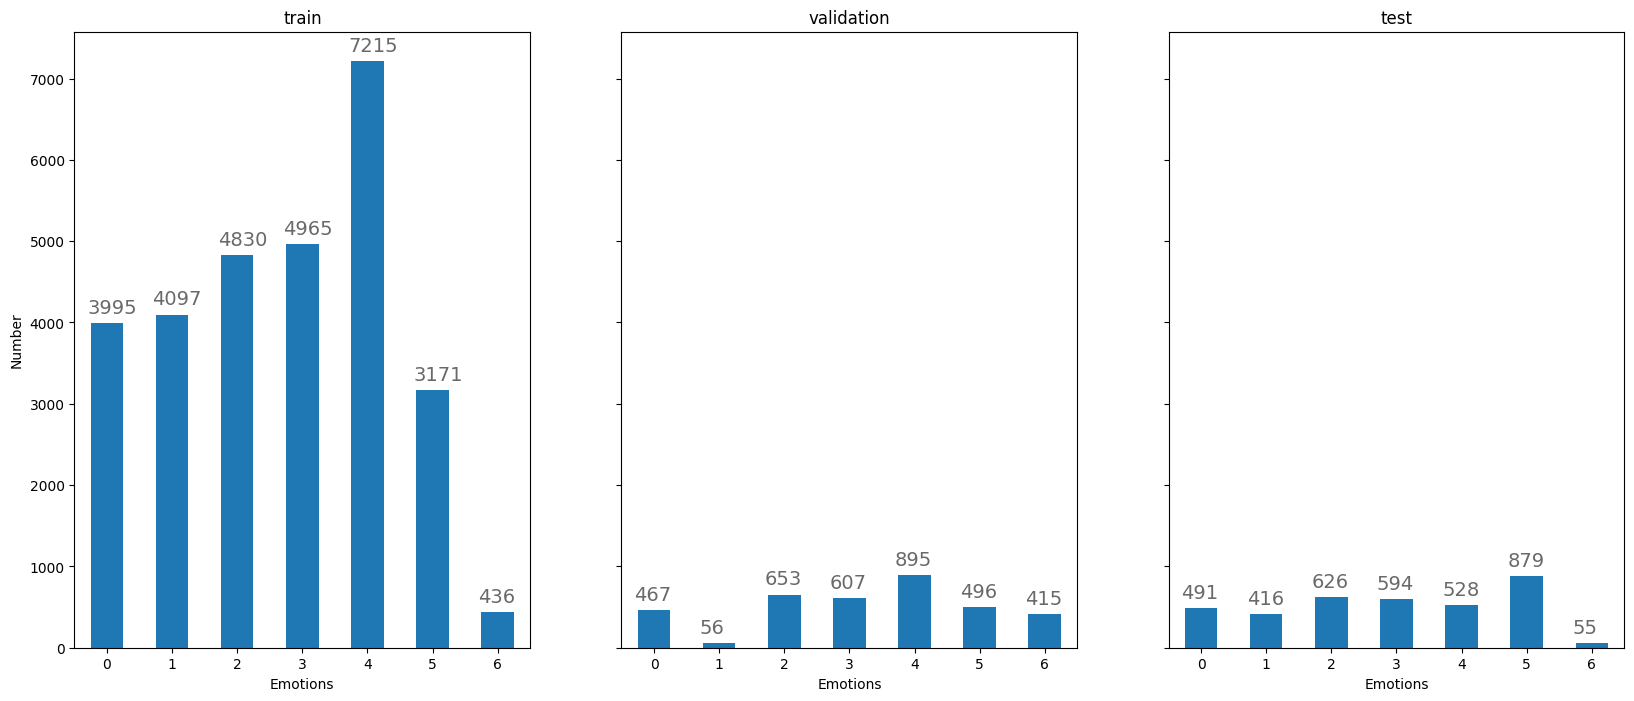

In [8]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))
def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotions_names)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Sort out faces and non faces, and occluded faces

Categorizing and partitioning emotions

In [1]:

import pandas as pd

# Define a function to categorize emotions into Depressed and Not-Depressed
def categorize_emotion(emotion):
    depressed_emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 4: 'Sad'}
    not_depressed_emotions = {3: 'Happy', 5: 'Neutral', 6: 'Surprised'}

    if emotion in depressed_emotions:
        return 'Depressed'
    elif emotion in not_depressed_emotions:
        return 'Not-Depressed'
    else:
        return 'Other'  # To handle unlabeled or unexpected values

# Load dataset
filepath = 'fer2013.csv'  # Ensure the correct path is used
print(f"Loading dataset from {filepath}...")

try:
    data = pd.read_csv(filepath)
    
    # Ensure the required column exists
    if 'emotion' not in data.columns:
        raise ValueError("The dataset does not contain an 'emotion' column.")

    # Apply emotion categorization
    data['emotion_category'] = data['emotion'].apply(categorize_emotion)

    # Filter to keep only Depressed and Not-Depressed categories
    filtered_df = data[data['emotion_category'].isin(['Depressed', 'Not-Depressed'])]

    # Split into two separate datasets
    depressed_df = filtered_df[filtered_df['emotion_category'] == 'Depressed']
    not_depressed_df = filtered_df[filtered_df['emotion_category'] == 'Not-Depressed']

    # Save to CSV files
    depressed_csv = 'Depressed.csv'
    not_depressed_csv = 'Not-Depressed.csv'

    depressed_df.to_csv(depressed_csv, index=False)
    not_depressed_df.to_csv(not_depressed_csv, index=False)

    print(f"\nDataset split completed successfully.")
    print(f"Depressed dataset saved as {depressed_csv} with {len(depressed_df)} samples.")
    print(f"Not-Depressed dataset saved as {not_depressed_csv} with {len(not_depressed_df)} samples.")

    # Display some sample rows
    print("\nSample from Depressed dataset:")
    print(depressed_df.head())

    print("\nSample from Not-Depressed dataset:")
    print(not_depressed_df.head())

except Exception as e:
    print(f"Error processing dataset: {e}")


C:\Users\User\AppData\Local\Temp\ipykernel_14616\3352496247.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Loading dataset from fer2013.csv...

Dataset split completed successfully.
Depressed dataset saved as Depressed.csv with 16698 samples.
Not-Depressed dataset saved as Not-Depressed.csv with 19189 samples.

Sample from Depressed dataset:
   emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
5        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training   

  emotion_category  
0        Depressed  
1        Depressed  
2        Depressed  
3        Depressed  
5        Depressed  

Sample from Not-Depressed dataset:
    emotion                                             pixels     Usage  \
4         6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training  

Sorting Depressed Emotions

Loading dataset from Depressed.csv...
Analyzing faces...

Face Type Distribution:
face_type
valid_face      13818
unclear          1501
partial_face      972
non_face          407
Name: count, dtype: int64


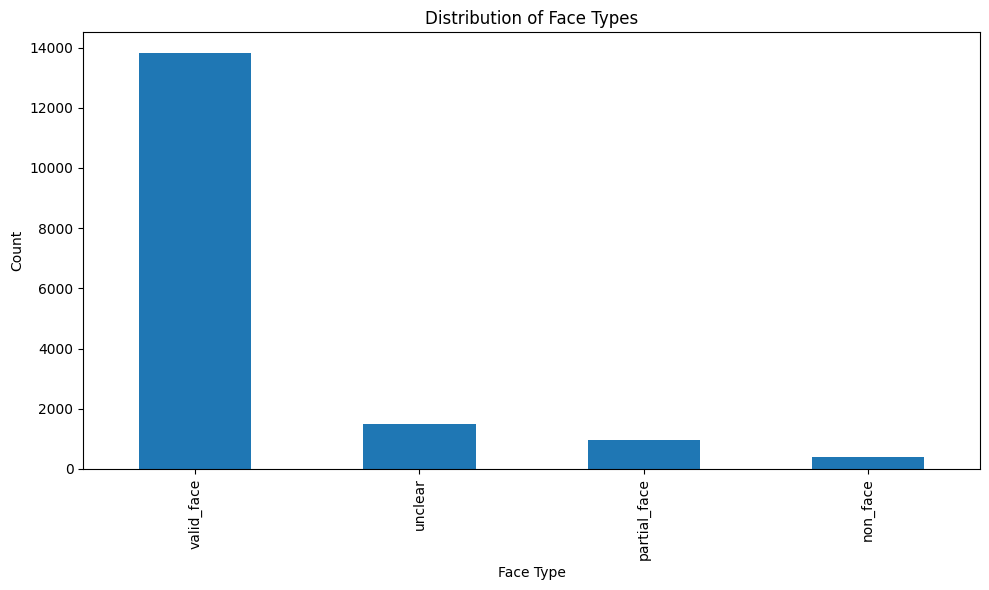


Displaying sample images by face type...
Saved sample images for valid_face to sample_valid_face_faces.png


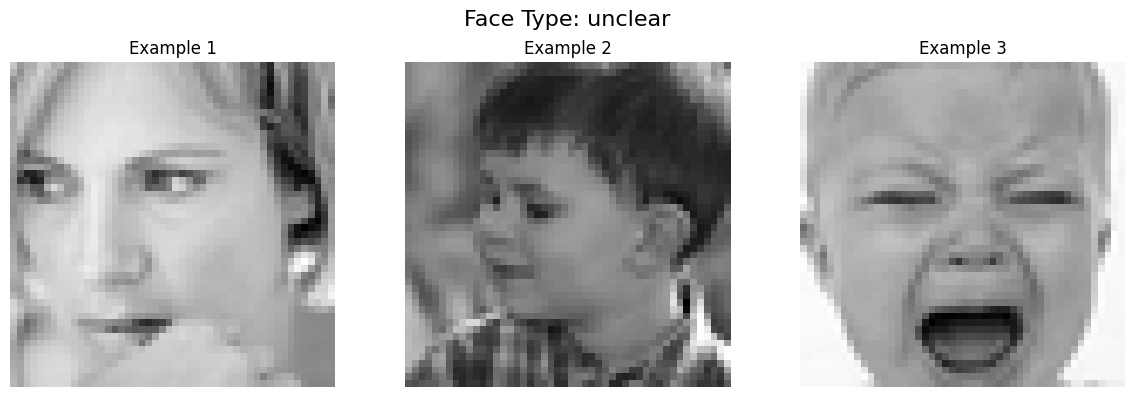

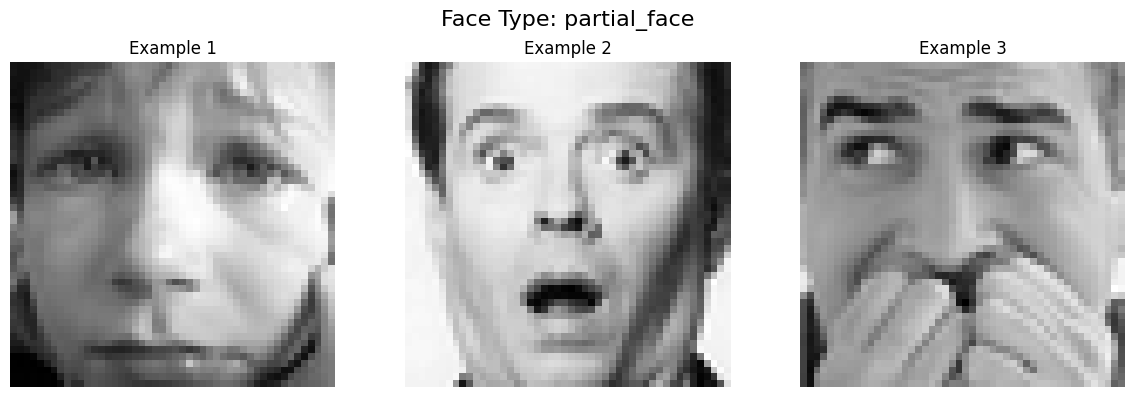

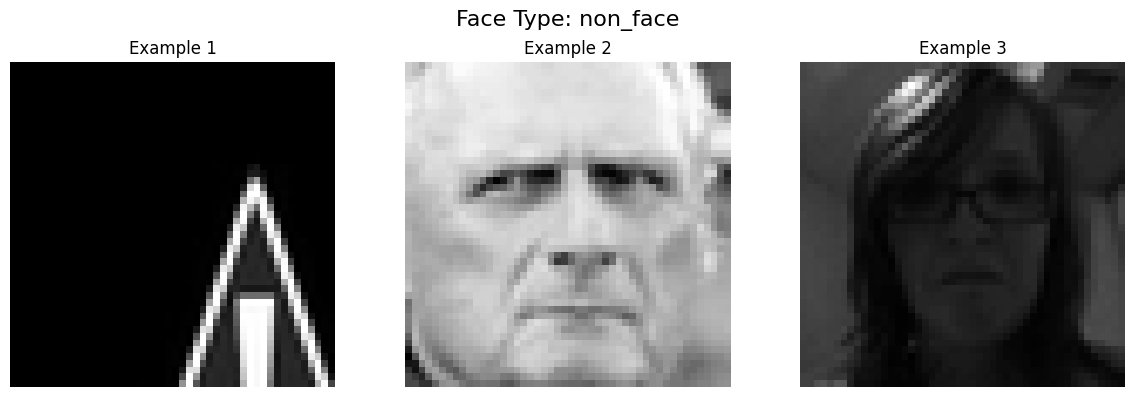

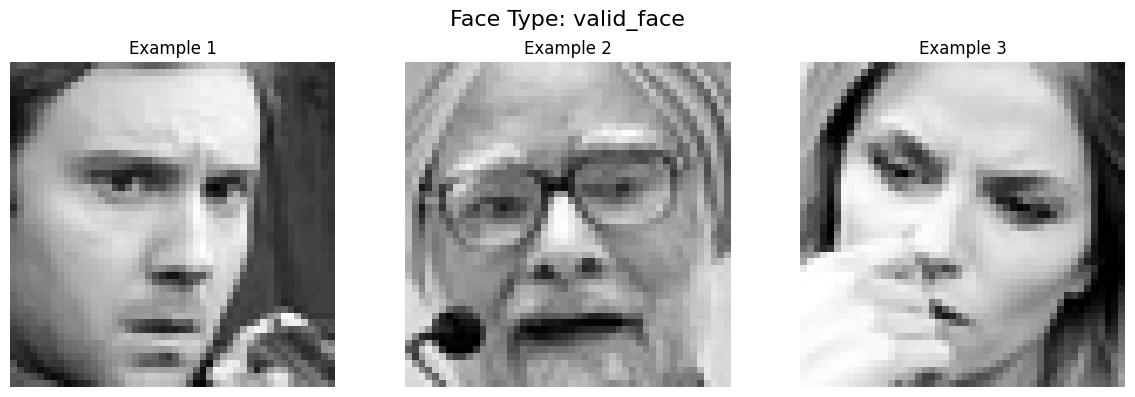

Saved sample images for unclear to sample_unclear_faces.png


<Figure size 640x480 with 0 Axes>

Saved sample images for partial_face to sample_partial_face_faces.png


<Figure size 640x480 with 0 Axes>

Saved sample images for non_face to sample_non_face_faces.png


<Figure size 640x480 with 0 Axes>


Verifying classifications...


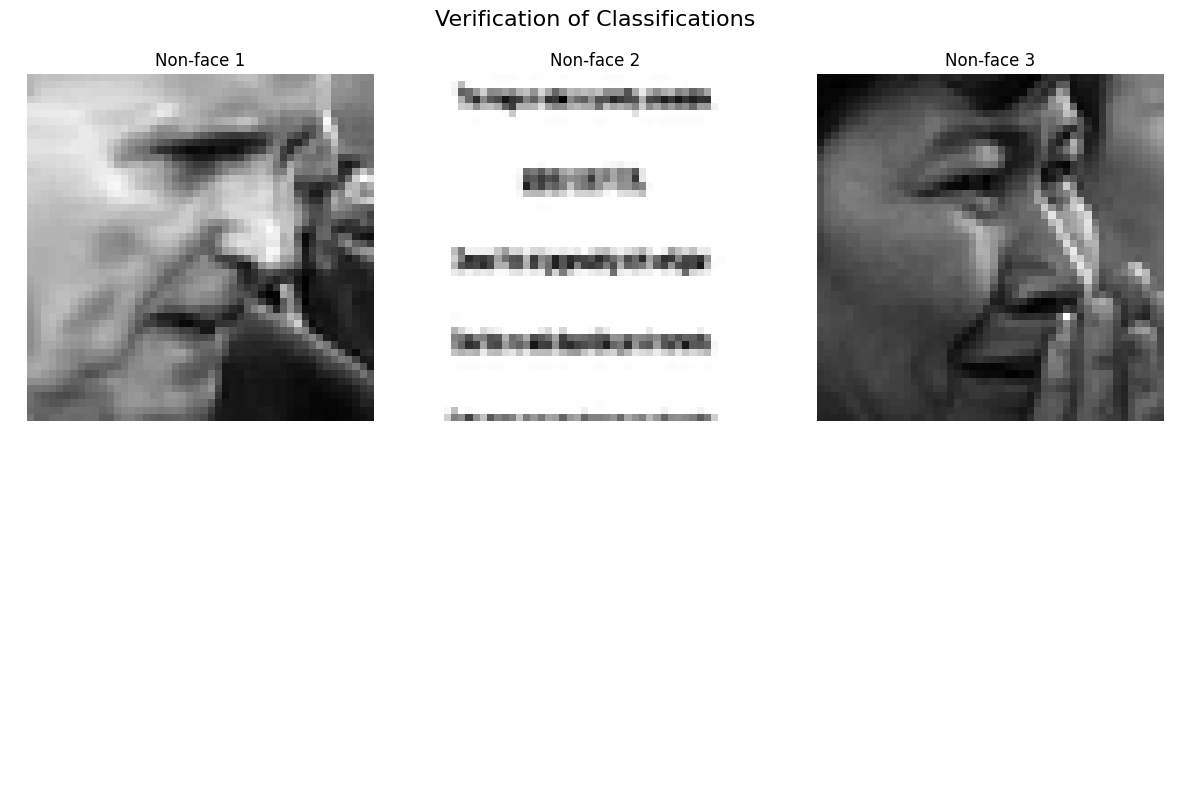


Saving categorized data...
Saved 13818 valid_face images to depressed_valid_face_images.csv
Saved 1501 unclear images to depressed_unclear_images.csv
Saved 972 partial_face images to depressed_partial_face_images.csv
Saved 407 non_face images to depressed_non_face_images.csv

Face Type Statistics:
face_type
valid_face      13818
unclear          1501
partial_face      972
non_face          407
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import kurtosis, skew

def analyze_face_image(pixels):
    """
    Enhanced face analysis using multiple metrics and more accurate classification.
    """
    # Convert pixel string to numpy array
    img_array = np.fromstring(pixels, dtype=int, sep=' ').reshape(48, 48)
    img_uint8 = img_array.astype(np.uint8)
    
    # Calculate advanced metrics
    avg_intensity = np.mean(img_array)
    std_dev = np.std(img_array)
    kurt = kurtosis(img_array.flatten())
    skewness = skew(img_array.flatten())
    
    # Calculate local contrast
    sobel_x = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    local_contrast = np.mean(gradient_magnitude)
    
    # Face detection with multiple cascades
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    
    # Detect faces and eyes
    faces = face_cascade.detectMultiScale(img_uint8, scaleFactor=1.1, minNeighbors=4)
    eyes = eye_cascade.detectMultiScale(img_uint8, scaleFactor=1.1, minNeighbors=4)
    
    # Check for facial regions by analyzing intensity distribution
    # Divide the image into regions to check for consistent presence
    h, w = img_array.shape
    regions = []
    for i in range(3):
        for j in range(3):
            region = img_array[i*h//3:(i+1)*h//3, j*w//3:(j+1)*w//3]
            regions.append(np.mean(region))
    
    region_std = np.std(regions)
    edge_density = np.sum(gradient_magnitude > 30) / (h * w)
    
    # IMPROVED CLASSIFICATION LOGIC
    # 1. Check for face detection
    has_face_detection = len(faces) > 0
    has_eyes = len(eyes) > 0
    
    # 2. Check for non-face characteristics
    is_uniform = std_dev < 20 or region_std < 8  # Very uniform distribution
    is_too_dark = avg_intensity < 30
    is_too_bright = avg_intensity > 220
    has_low_detail = edge_density < 0.08
    
    # 3. Check for covered face characteristics
    has_partial_features = 20 < std_dev < 40 and edge_density < 0.15
    has_eye_section_only = len(eyes) > 0 and len(faces) == 0
    
    # Classification decision tree
    if is_uniform or is_too_dark or is_too_bright:
        return 'non_face'  # Definitely not a face
    
    if has_face_detection and has_eyes:
        if has_low_detail:
            return 'covered_face'  # Face outline detected but low detail
        return 'valid_face'  # Valid face with detectable features
    
    if has_face_detection and not has_eyes:
        if local_contrast < 25 or has_partial_features:
            return 'covered_face'  # Face without visible eyes, likely covered
        return 'valid_face'  # Face but eyes not detected due to angle/shadows
    
    if has_eye_section_only:
        return 'partial_face'  # Only part of the face visible
    
    # No detector found a face, use statistical properties
    if edge_density > 0.18 and std_dev > 40:
        return 'valid_face'  # Likely a face missed by detector
    elif has_partial_features:
        return 'covered_face'  # May be covered/obscured face
    elif std_dev > 30 and not is_uniform:
        return 'unclear'  # Some structure but unclear if face
    else:
        return 'non_face'  # Likely not a face

def visualize_examples_by_type(data, face_types, num_examples=3):
    """
    Visualizes example images for each face type in separate figures.
    """
    figures = {}
    
    for face_type in face_types:
        # Get subset of data for this face type
        subset = data[data['face_type'] == face_type].reset_index(drop=True)
        
        # If we have fewer than num_examples, use what we have
        sample_size = min(num_examples, len(subset))
        
        # Create a figure for this face type
        fig, axes = plt.subplots(1, num_examples, figsize=(4*num_examples, 4))
        
        # Ensure axes is always an array
        if num_examples == 1:
            axes = [axes]
            
        # Display available examples
        for j in range(num_examples):
            if j < sample_size:
                img = np.fromstring(subset.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
                axes[j].imshow(img, cmap='gray')
                axes[j].axis('off')
                axes[j].set_title(f"Example {j+1}")
            else:
                # Handle the case when there are fewer examples than requested
                axes[j].axis('off')
                axes[j].text(0.5, 0.5, "No more examples", 
                             ha='center', va='center', transform=axes[j].transAxes)
        
        plt.suptitle(f"Face Type: {face_type}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        
        # Store the figure reference
        figures[face_type] = fig
        
    return figures

def analyze_misclassifications(data, num_examples=3):
    """
    Analyze potentially misclassified examples and show them for human verification.
    """
    # Extract potential misclassifications to verify
    non_faces = data[data['face_type'] == 'non_face'].sample(min(num_examples, len(data[data['face_type'] == 'non_face'])))
    covered_faces = data[data['face_type'] == 'covered_face'].sample(min(num_examples, len(data[data['face_type'] == 'covered_face'])))
    
    fig, axes = plt.subplots(2, num_examples, figsize=(4*num_examples, 8))
    
    # Display non-faces
    for j in range(num_examples):
        if j < len(non_faces):
            img = np.fromstring(non_faces.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
            axes[0, j].imshow(img, cmap='gray')
            axes[0, j].axis('off')
            axes[0, j].set_title(f"Non-face {j+1}")
        else:
            axes[0, j].axis('off')
    
    # Display covered faces
    for j in range(num_examples):
        if j < len(covered_faces):
            img = np.fromstring(covered_faces.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
            axes[1, j].imshow(img, cmap='gray')
            axes[1, j].axis('off')
            axes[1, j].set_title(f"Covered face {j+1}")
        else:
            axes[1, j].axis('off')
    
    axes[0, 0].set_ylabel("Non-faces", fontsize=12)
    axes[1, 0].set_ylabel("Covered faces", fontsize=12)
    
    plt.suptitle("Verification of Classifications", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

def process_dataset(filepath):
    """
    Process the dataset and display results.
    """
    # Load data
    print(f"Loading dataset from {filepath}...")
    data = pd.read_csv(filepath)
    
    # Analyze faces
    print("Analyzing faces...")
    data['face_type'] = data['pixels'].apply(analyze_face_image)
    
    # Get statistics
    stats = data['face_type'].value_counts()
    print("\nFace Type Distribution:")
    print(stats)
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    stats.plot(kind='bar')
    plt.title('Distribution of Face Types')
    plt.xlabel('Face Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('face_type_distribution.png')
    plt.show()
    
    # Display sample images for each face type (separately)
    print("\nDisplaying sample images by face type...")
    figures = visualize_examples_by_type(data, stats.index.tolist())
    
    # Save each figure
    for face_type, fig in figures.items():
        filename = f'sample_{face_type}_faces.png'
        fig.savefig(filename)
        print(f"Saved sample images for {face_type} to {filename}")
        plt.figure(fig.number)
        plt.show()
    
    # Run misclassification analysis
    print("\nVerifying classifications...")
    misclass_fig = analyze_misclassifications(data)
    plt.savefig('classification_verification.png')
    plt.show()
    
    # Save categorized data
    print("\nSaving categorized data...")
    for face_type in stats.index:
        subset = data[data['face_type'] == face_type]
        output_file = f'depressed_{face_type}_images.csv'
        subset.to_csv(output_file, index=False)
        print(f"Saved {len(subset)} {face_type} images to {output_file}")
    
    return data, stats, figures

def display_face_type_examples(data, face_type, num_examples=3):
    """
    Displays examples of a specific face type on demand.
    """
    subset = data[data['face_type'] == face_type].reset_index(drop=True)
    
    if len(subset) == 0:
        print(f"No examples found for face type: {face_type}")
        return None
    
    sample_size = min(num_examples, len(subset))
    
    fig, axes = plt.subplots(1, sample_size, figsize=(4*sample_size, 4))
    
    # Handle the case when there's only one example
    if sample_size == 1:
        axes = [axes]
    
    for j in range(sample_size):
        img = np.fromstring(subset.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
        axes[j].imshow(img, cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"Example {j+1}")
    
    plt.suptitle(f"Face Type: depress_{face_type}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    return fig

# Usage
data, statistics, figures = process_dataset('Depressed.csv')
print("\nFace Type Statistics:")
print(statistics)

Sorting Not-Depressed Emotions

Loading dataset from Not-Depressed.csv...
Analyzing faces...

Face Type Distribution:
face_type
valid_face      15793
unclear          1511
partial_face     1435
non_face          449
covered_face        1
Name: count, dtype: int64


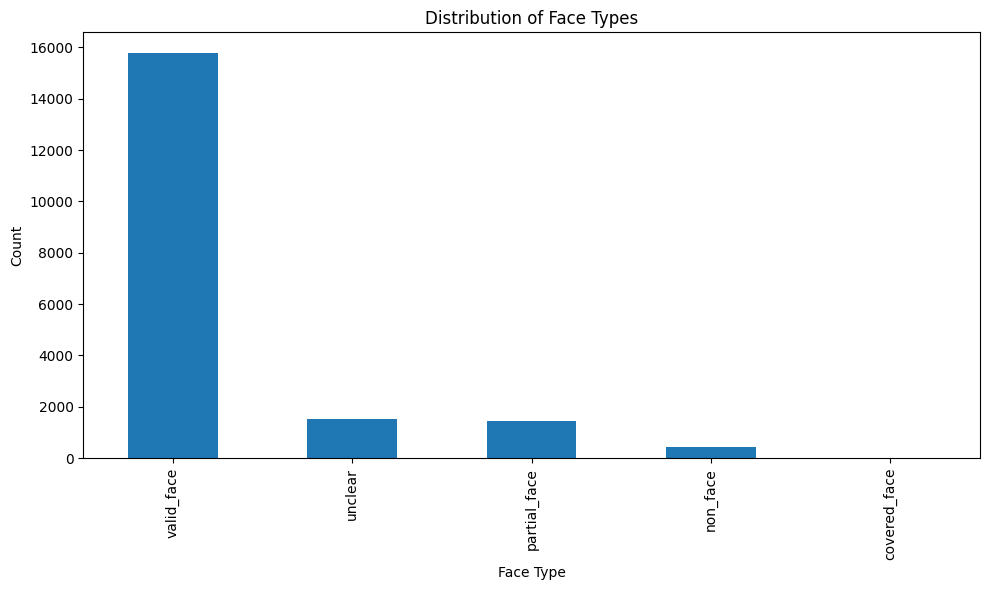


Displaying sample images by face type...
Saved sample images for valid_face to sample_valid_face_faces.png


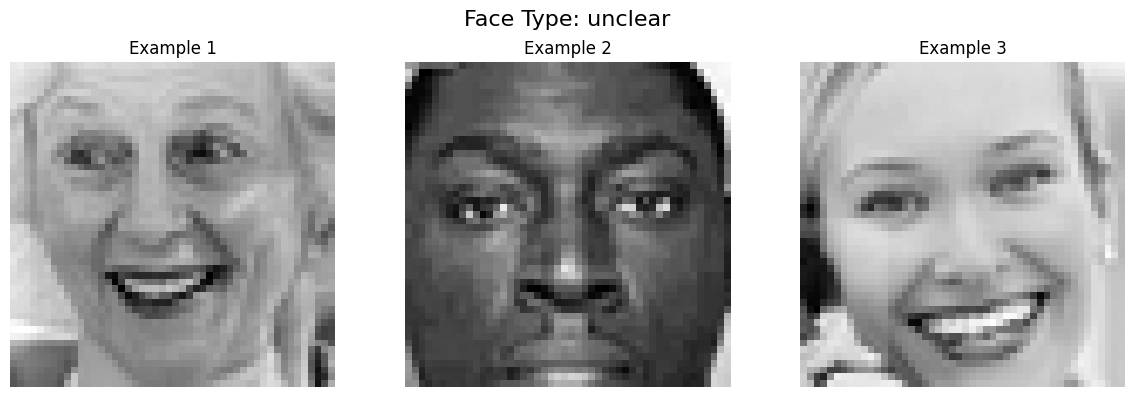

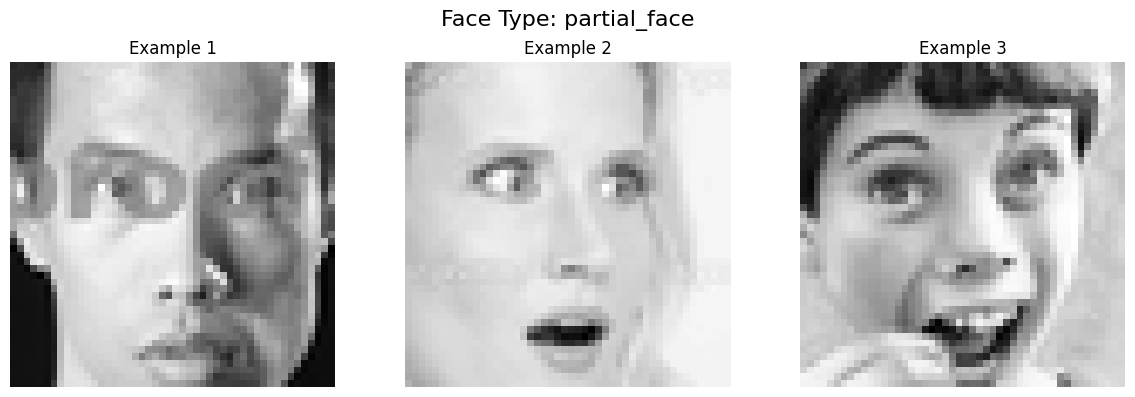

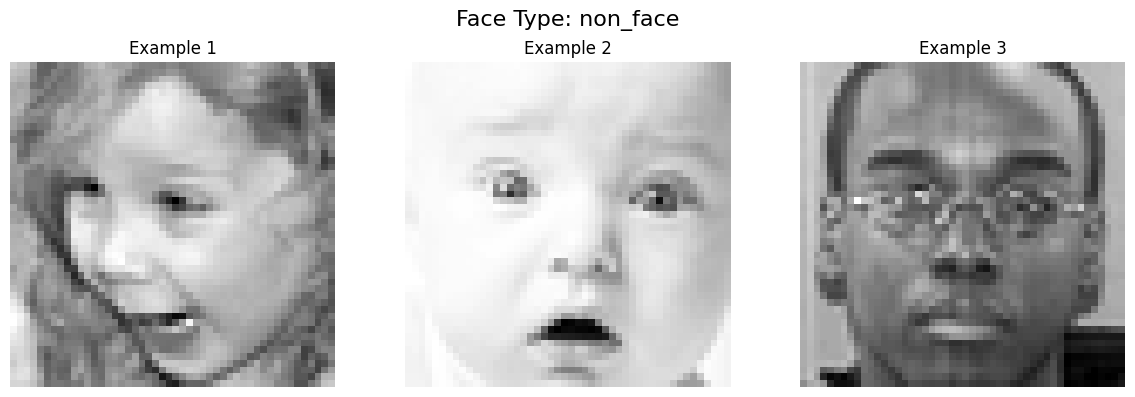

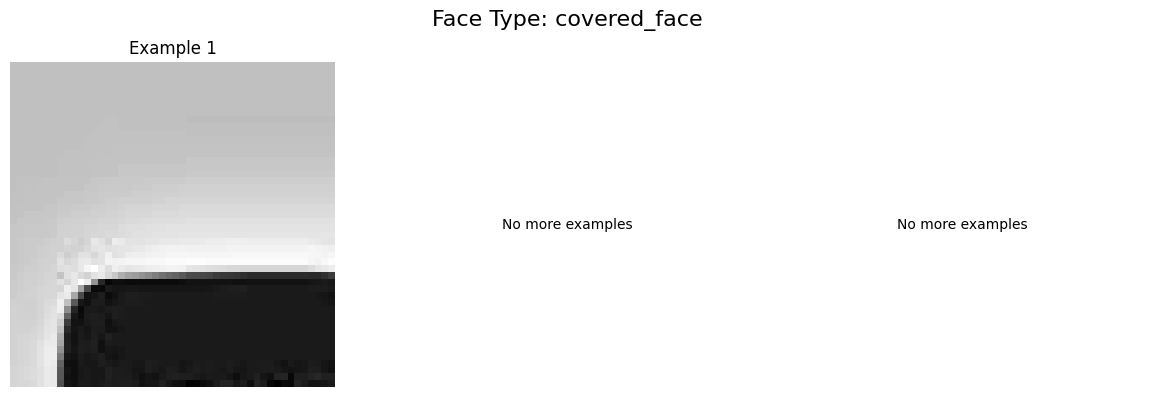

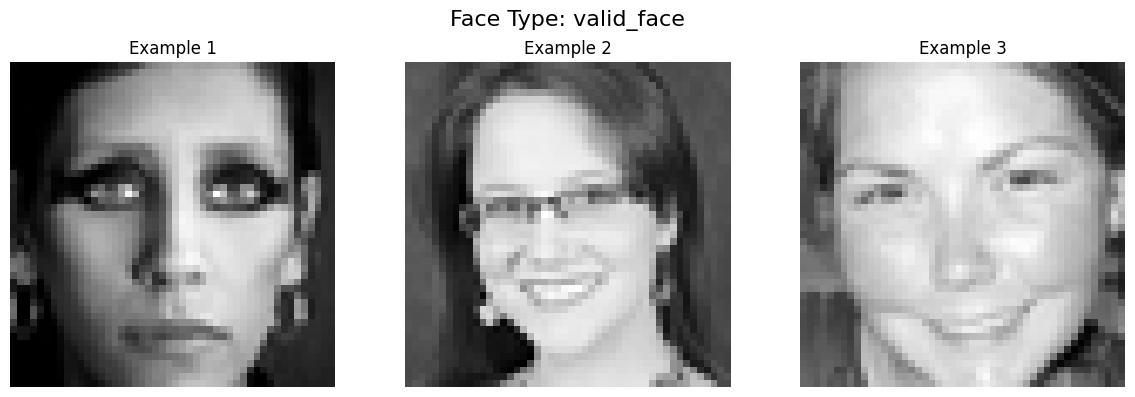

Saved sample images for unclear to sample_unclear_faces.png


<Figure size 640x480 with 0 Axes>

Saved sample images for partial_face to sample_partial_face_faces.png


<Figure size 640x480 with 0 Axes>

Saved sample images for non_face to sample_non_face_faces.png


<Figure size 640x480 with 0 Axes>

Saved sample images for covered_face to sample_covered_face_faces.png


<Figure size 640x480 with 0 Axes>


Verifying classifications...


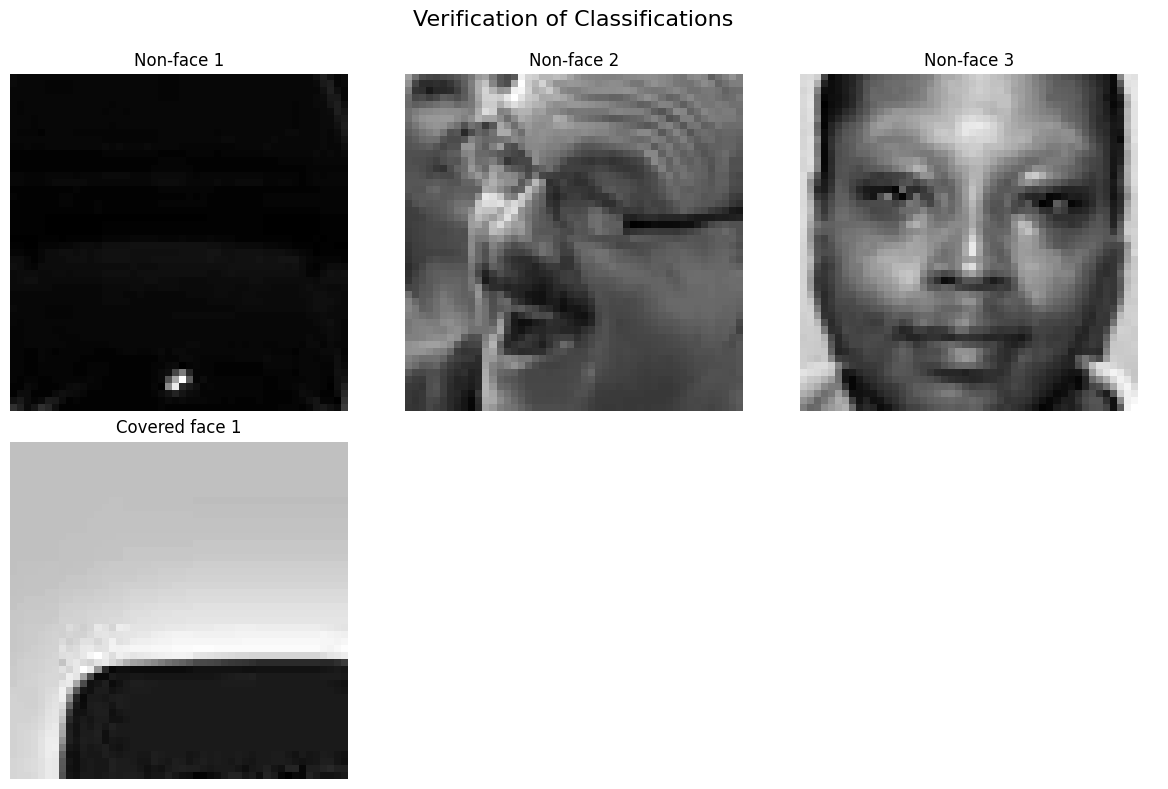


Saving categorized data...
Saved 15793 valid_face images to not-depressed_valid_face_images.csv
Saved 1511 unclear images to not-depressed_unclear_images.csv
Saved 1435 partial_face images to not-depressed_partial_face_images.csv
Saved 449 non_face images to not-depressed_non_face_images.csv
Saved 1 covered_face images to not-depressed_covered_face_images.csv

Face Type Statistics:
face_type
valid_face      15793
unclear          1511
partial_face     1435
non_face          449
covered_face        1
Name: count, dtype: int64


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import kurtosis, skew

def analyze_face_image(pixels):
    """
    Enhanced face analysis using multiple metrics and more accurate classification.
    """
    # Convert pixel string to numpy array
    img_array = np.fromstring(pixels, dtype=int, sep=' ').reshape(48, 48)
    img_uint8 = img_array.astype(np.uint8)
    
    # Calculate advanced metrics
    avg_intensity = np.mean(img_array)
    std_dev = np.std(img_array)
    kurt = kurtosis(img_array.flatten())
    skewness = skew(img_array.flatten())
    
    # Calculate local contrast
    sobel_x = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    local_contrast = np.mean(gradient_magnitude)
    
    # Face detection with multiple cascades
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    
    # Detect faces and eyes
    faces = face_cascade.detectMultiScale(img_uint8, scaleFactor=1.1, minNeighbors=4)
    eyes = eye_cascade.detectMultiScale(img_uint8, scaleFactor=1.1, minNeighbors=4)
    
    # Check for facial regions by analyzing intensity distribution
    # Divide the image into regions to check for consistent presence
    h, w = img_array.shape
    regions = []
    for i in range(3):
        for j in range(3):
            region = img_array[i*h//3:(i+1)*h//3, j*w//3:(j+1)*w//3]
            regions.append(np.mean(region))
    
    region_std = np.std(regions)
    edge_density = np.sum(gradient_magnitude > 30) / (h * w)
    
    # IMPROVED CLASSIFICATION LOGIC
    # 1. Check for face detection
    has_face_detection = len(faces) > 0
    has_eyes = len(eyes) > 0
    
    # 2. Check for non-face characteristics
    is_uniform = std_dev < 20 or region_std < 8  # Very uniform distribution
    is_too_dark = avg_intensity < 30
    is_too_bright = avg_intensity > 220
    has_low_detail = edge_density < 0.08
    
    # 3. Check for covered face characteristics
    has_partial_features = 20 < std_dev < 40 and edge_density < 0.15
    has_eye_section_only = len(eyes) > 0 and len(faces) == 0
    
    # Classification decision tree
    if is_uniform or is_too_dark or is_too_bright:
        return 'non_face'  # Definitely not a face
    
    if has_face_detection and has_eyes:
        if has_low_detail:
            return 'covered_face'  # Face outline detected but low detail
        return 'valid_face'  # Valid face with detectable features
    
    if has_face_detection and not has_eyes:
        if local_contrast < 25 or has_partial_features:
            return 'covered_face'  # Face without visible eyes, likely covered
        return 'valid_face'  # Face but eyes not detected due to angle/shadows
    
    if has_eye_section_only:
        return 'partial_face'  # Only part of the face visible
    
    # No detector found a face, use statistical properties
    if edge_density > 0.18 and std_dev > 40:
        return 'valid_face'  # Likely a face missed by detector
    elif has_partial_features:
        return 'covered_face'  # May be covered/obscured face
    elif std_dev > 30 and not is_uniform:
        return 'unclear'  # Some structure but unclear if face
    else:
        return 'non_face'  # Likely not a face

def visualize_examples_by_type(data, face_types, num_examples=3):
    """
    Visualizes example images for each face type in separate figures.
    """
    figures = {}
    
    for face_type in face_types:
        # Get subset of data for this face type
        subset = data[data['face_type'] == face_type].reset_index(drop=True)
        
        # If we have fewer than num_examples, use what we have
        sample_size = min(num_examples, len(subset))
        
        # Create a figure for this face type
        fig, axes = plt.subplots(1, num_examples, figsize=(4*num_examples, 4))
        
        # Ensure axes is always an array
        if num_examples == 1:
            axes = [axes]
            
        # Display available examples
        for j in range(num_examples):
            if j < sample_size:
                img = np.fromstring(subset.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
                axes[j].imshow(img, cmap='gray')
                axes[j].axis('off')
                axes[j].set_title(f"Example {j+1}")
            else:
                # Handle the case when there are fewer examples than requested
                axes[j].axis('off')
                axes[j].text(0.5, 0.5, "No more examples", 
                             ha='center', va='center', transform=axes[j].transAxes)
        
        plt.suptitle(f"Face Type: {face_type}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        
        # Store the figure reference
        figures[face_type] = fig
        
    return figures

def analyze_misclassifications(data, num_examples=3):
    """
    Analyze potentially misclassified examples and show them for human verification.
    """
    # Extract potential misclassifications to verify
    non_faces = data[data['face_type'] == 'non_face'].sample(min(num_examples, len(data[data['face_type'] == 'non_face'])))
    covered_faces = data[data['face_type'] == 'covered_face'].sample(min(num_examples, len(data[data['face_type'] == 'covered_face'])))
    
    fig, axes = plt.subplots(2, num_examples, figsize=(4*num_examples, 8))
    
    # Display non-faces
    for j in range(num_examples):
        if j < len(non_faces):
            img = np.fromstring(non_faces.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
            axes[0, j].imshow(img, cmap='gray')
            axes[0, j].axis('off')
            axes[0, j].set_title(f"Non-face {j+1}")
        else:
            axes[0, j].axis('off')
    
    # Display covered faces
    for j in range(num_examples):
        if j < len(covered_faces):
            img = np.fromstring(covered_faces.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
            axes[1, j].imshow(img, cmap='gray')
            axes[1, j].axis('off')
            axes[1, j].set_title(f"Covered face {j+1}")
        else:
            axes[1, j].axis('off')
    
    axes[0, 0].set_ylabel("Non-faces", fontsize=12)
    axes[1, 0].set_ylabel("Covered faces", fontsize=12)
    
    plt.suptitle("Verification of Classifications", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

def process_dataset(filepath):
    """
    Process the dataset and display results.
    """
    # Load data
    print(f"Loading dataset from {filepath}...")
    data = pd.read_csv(filepath)
    
    # Analyze faces
    print("Analyzing faces...")
    data['face_type'] = data['pixels'].apply(analyze_face_image)
    
    # Get statistics
    stats = data['face_type'].value_counts()
    print("\nFace Type Distribution:")
    print(stats)
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    stats.plot(kind='bar')
    plt.title('Distribution of Face Types')
    plt.xlabel('Face Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('face_type_distribution.png')
    plt.show()
    
    # Display sample images for each face type (separately)
    print("\nDisplaying sample images by face type...")
    figures = visualize_examples_by_type(data, stats.index.tolist())
    
    # Save each figure
    for face_type, fig in figures.items():
        filename = f'sample_{face_type}_faces.png'
        fig.savefig(filename)
        print(f"Saved sample images for {face_type} to {filename}")
        plt.figure(fig.number)
        plt.show()
    
    # Run misclassification analysis
    print("\nVerifying classifications...")
    misclass_fig = analyze_misclassifications(data)
    plt.savefig('classification_verification.png')
    plt.show()
    
    # Save categorized data
    print("\nSaving categorized data...")
    for face_type in stats.index:
        subset = data[data['face_type'] == face_type]
        output_file = f'not-depressed_{face_type}_images.csv'
        subset.to_csv(output_file, index=False)
        print(f"Saved {len(subset)} {face_type} images to {output_file}")
    
    return data, stats, figures

def display_face_type_examples(data, face_type, num_examples=3):
    """
    Displays examples of a specific face type on demand.
    """
    subset = data[data['face_type'] == face_type].reset_index(drop=True)
    
    if len(subset) == 0:
        print(f"No examples found for face type: {face_type}")
        return None
    
    sample_size = min(num_examples, len(subset))
    
    fig, axes = plt.subplots(1, sample_size, figsize=(4*sample_size, 4))
    
    # Handle the case when there's only one example
    if sample_size == 1:
        axes = [axes]
    
    for j in range(sample_size):
        img = np.fromstring(subset.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
        axes[j].imshow(img, cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"Example {j+1}")
    
    plt.suptitle(f"Face Type: {face_type}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    return fig

# Usage
data, statistics, figures = process_dataset('Not-Depressed.csv')
print("\nFace Type Statistics:")
print(statistics)

Sorting the general categorised dataset

In [ ]:

# Define a function to categorize emotions into depressed and Not-Depressed
def categorize_emotion(emotion):
    if emotion in [0,1,2,4]:  # Angry, Disgust, Fear, Sad -> Depressed
        return 'Depressed'
    elif emotion in [3,5,6]:  # Happy, Neutral,Suprised -> Not-Depressed
        return 'Not-Depressed'
    else:
        return 'Other'  # To handle unlabled images

# Apply the function to create a new column 'emotion_category'
data['emotion_category'] = data['emotion'].apply(categorize_emotion)

# Filter the dataset to keep only rows where the emotion is categorized as 'Depressed' or 'Not-Depressed'
filtered_df = data[data['emotion_category'].isin(['Depressed', 'Not-Depressed'])]

# Save the new dataset to a CSV file
filtered_df.to_csv('fer2013_emotion_category.csv', index=False)

# Display the first few rows of the new dataset to verify
print(filtered_df.head())


   emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training   

  emotion_category   face_type  
0        Depressed  valid_face  
1        Depressed     unclear  
2        Depressed  valid_face  
3        Depressed     unclear  
4        Depressed  valid_face  


Loading dataset from fer2013_emotion_category.csv...
Analyzing faces...

Face Type Distribution:
face_type
valid_face      13818
unclear          1501
partial_face      972
non_face          407
Name: count, dtype: int64


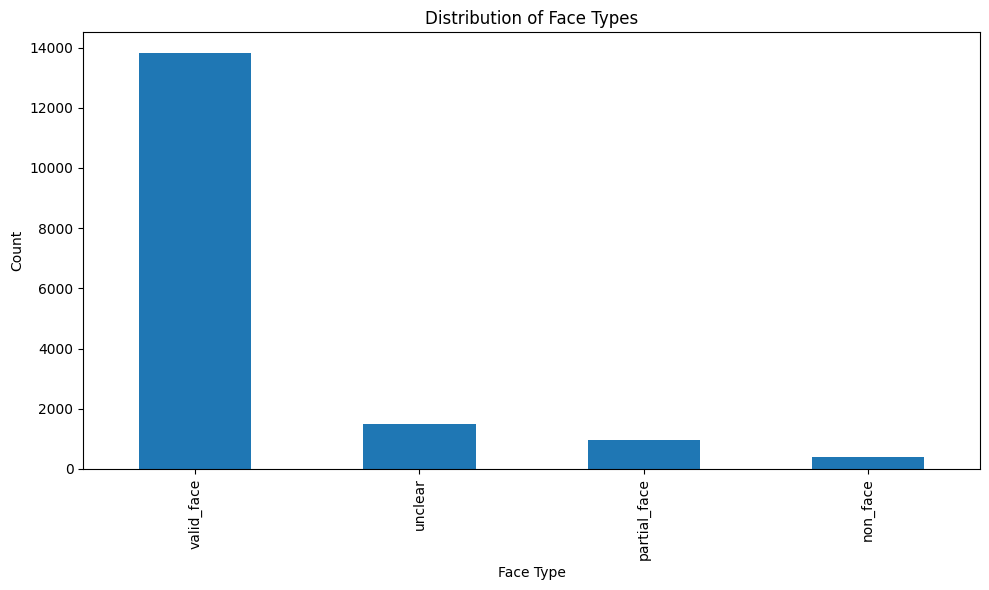


Displaying sample images by face type...
Saved sample images for valid_face to sample_valid_face_faces.png


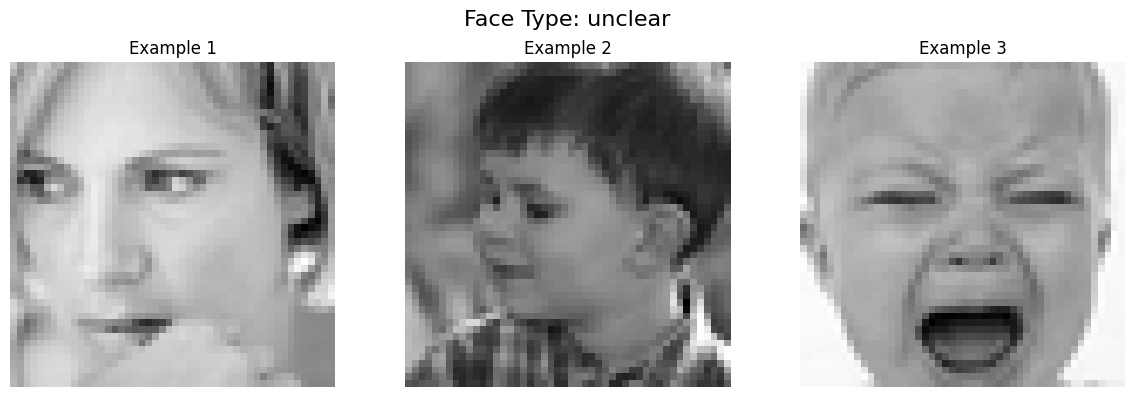

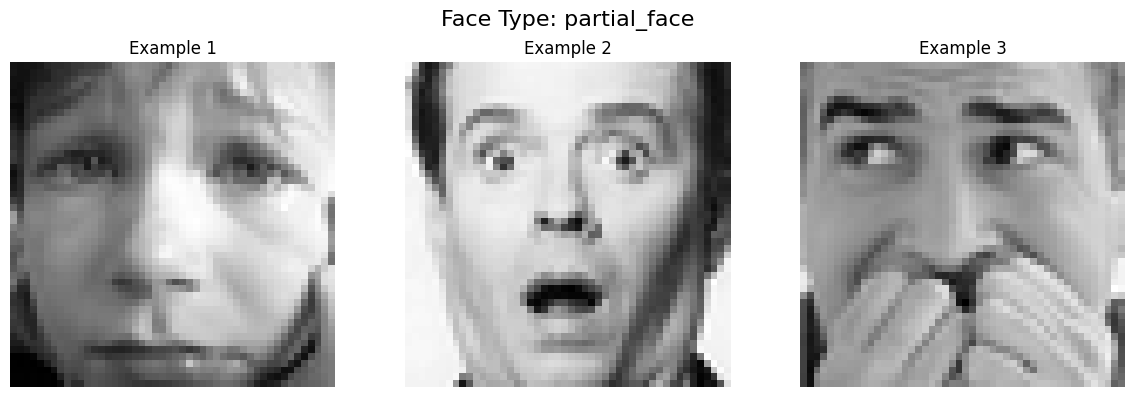

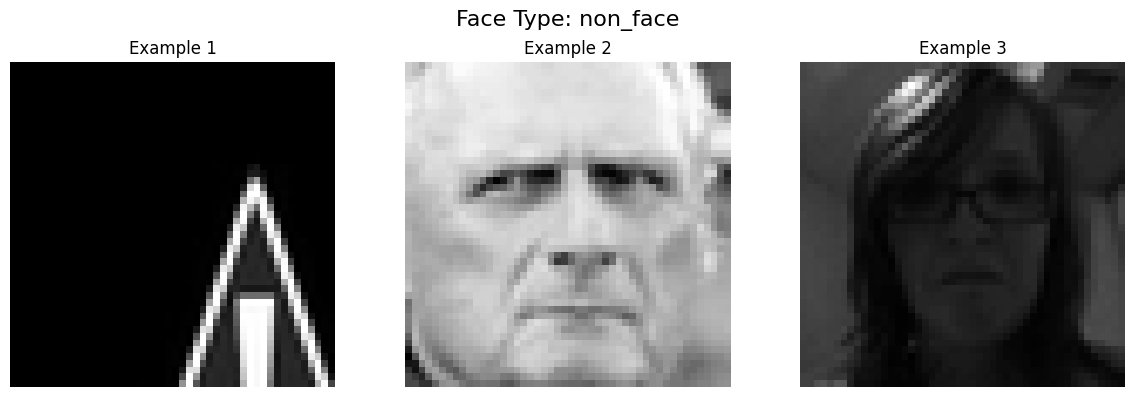

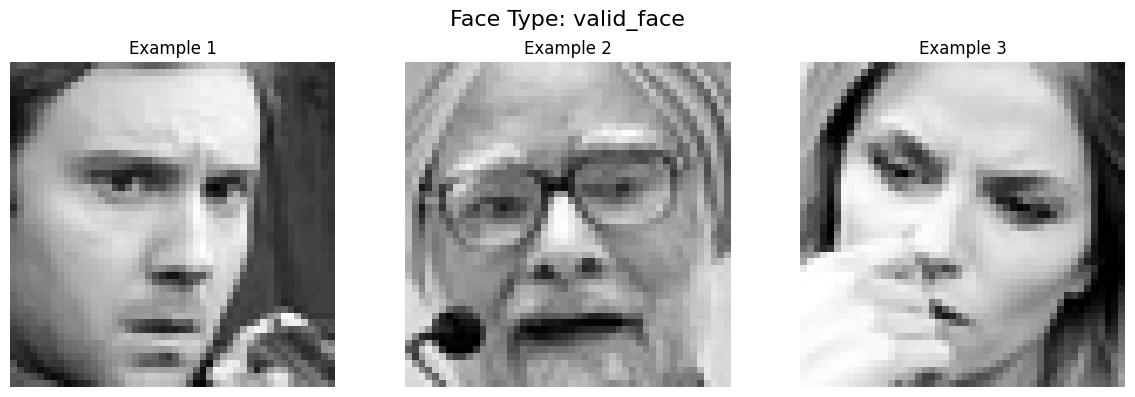

Saved sample images for unclear to sample_unclear_faces.png


<Figure size 640x480 with 0 Axes>

Saved sample images for partial_face to sample_partial_face_faces.png


<Figure size 640x480 with 0 Axes>

Saved sample images for non_face to sample_non_face_faces.png


<Figure size 640x480 with 0 Axes>


Verifying classifications...


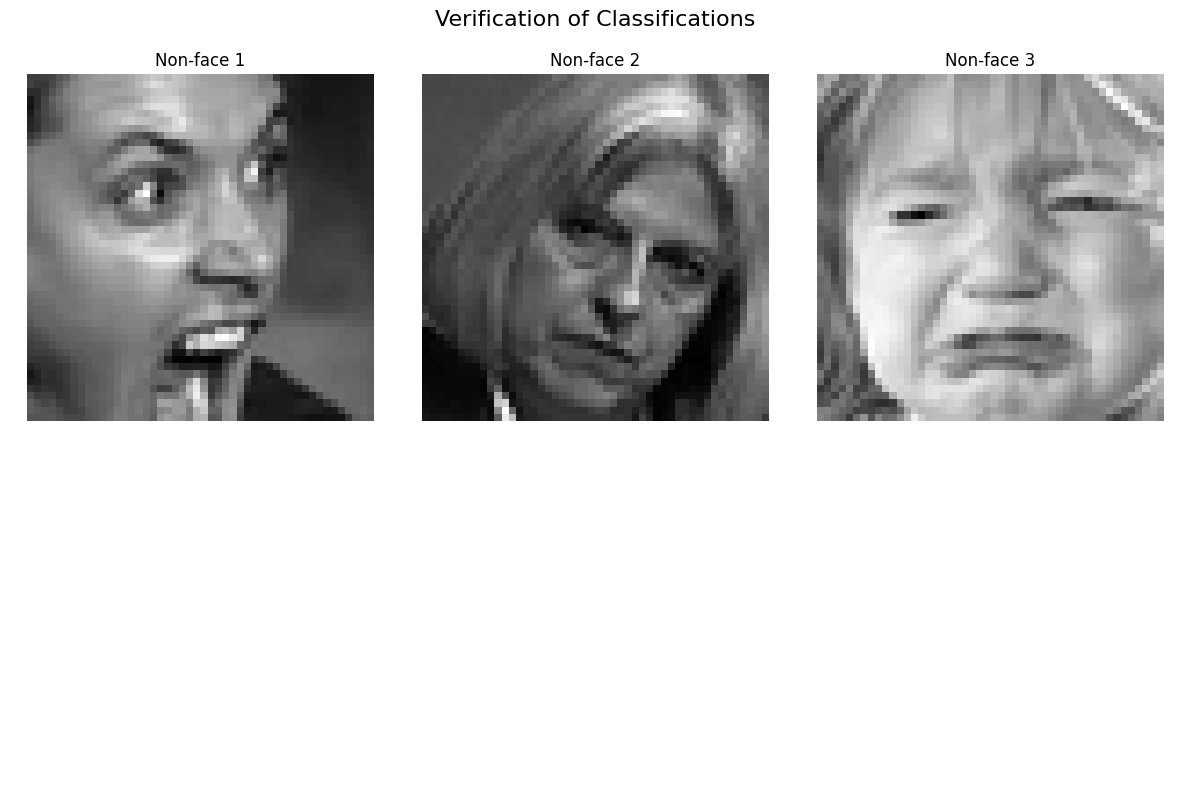


Saving categorized data...
Saved 13818 valid_face images to valid_face_images.csv
Saved 1501 unclear images to unclear_images.csv
Saved 972 partial_face images to partial_face_images.csv
Saved 407 non_face images to non_face_images.csv

Face Type Statistics:
face_type
valid_face      13818
unclear          1501
partial_face      972
non_face          407
Name: count, dtype: int64


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.stats import kurtosis, skew

def analyze_face_image(pixels):
    """
    Enhanced face analysis using multiple metrics and more accurate classification.
    """
    # Convert pixel string to numpy array
    img_array = np.fromstring(pixels, dtype=int, sep=' ').reshape(48, 48)
    img_uint8 = img_array.astype(np.uint8)
    
    # Calculate advanced metrics
    avg_intensity = np.mean(img_array)
    std_dev = np.std(img_array)
    kurt = kurtosis(img_array.flatten())
    skewness = skew(img_array.flatten())
    
    # Calculate local contrast
    sobel_x = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    local_contrast = np.mean(gradient_magnitude)
    
    # Face detection with multiple cascades
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    
    # Detect faces and eyes
    faces = face_cascade.detectMultiScale(img_uint8, scaleFactor=1.1, minNeighbors=4)
    eyes = eye_cascade.detectMultiScale(img_uint8, scaleFactor=1.1, minNeighbors=4)
    
    # Check for facial regions by analyzing intensity distribution
    # Divide the image into regions to check for consistent presence
    h, w = img_array.shape
    regions = []
    for i in range(3):
        for j in range(3):
            region = img_array[i*h//3:(i+1)*h//3, j*w//3:(j+1)*w//3]
            regions.append(np.mean(region))
    
    region_std = np.std(regions)
    edge_density = np.sum(gradient_magnitude > 30) / (h * w)
    
    # IMPROVED CLASSIFICATION LOGIC
    # 1. Check for face detection
    has_face_detection = len(faces) > 0
    has_eyes = len(eyes) > 0
    
    # 2. Check for non-face characteristics
    is_uniform = std_dev < 20 or region_std < 8  # Very uniform distribution
    is_too_dark = avg_intensity < 30
    is_too_bright = avg_intensity > 220
    has_low_detail = edge_density < 0.08
    
    # 3. Check for covered face characteristics
    has_partial_features = 20 < std_dev < 40 and edge_density < 0.15
    has_eye_section_only = len(eyes) > 0 and len(faces) == 0
    
    # Classification decision tree
    if is_uniform or is_too_dark or is_too_bright:
        return 'non_face'  # Definitely not a face
    
    if has_face_detection and has_eyes:
        if has_low_detail:
            return 'covered_face'  # Face outline detected but low detail
        return 'valid_face'  # Valid face with detectable features
    
    if has_face_detection and not has_eyes:
        if local_contrast < 25 or has_partial_features:
            return 'covered_face'  # Face without visible eyes, likely covered
        return 'valid_face'  # Face but eyes not detected due to angle/shadows
    
    if has_eye_section_only:
        return 'partial_face'  # Only part of the face visible
    
    # No detector found a face, use statistical properties
    if edge_density > 0.18 and std_dev > 40:
        return 'valid_face'  # Likely a face missed by detector
    elif has_partial_features:
        return 'covered_face'  # May be covered/obscured face
    elif std_dev > 30 and not is_uniform:
        return 'unclear'  # Some structure but unclear if face
    else:
        return 'non_face'  # Likely not a face

def visualize_examples_by_type(data, face_types, num_examples=3):
    """
    Visualizes example images for each face type in separate figures.
    """
    figures = {}
    
    for face_type in face_types:
        # Get subset of data for this face type
        subset = data[data['face_type'] == face_type].reset_index(drop=True)
        
        # If we have fewer than num_examples, use what we have
        sample_size = min(num_examples, len(subset))
        
        # Create a figure for this face type
        fig, axes = plt.subplots(1, num_examples, figsize=(4*num_examples, 4))
        
        # Ensure axes is always an array
        if num_examples == 1:
            axes = [axes]
            
        # Display available examples
        for j in range(num_examples):
            if j < sample_size:
                img = np.fromstring(subset.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
                axes[j].imshow(img, cmap='gray')
                axes[j].axis('off')
                axes[j].set_title(f"Example {j+1}")
            else:
                # Handle the case when there are fewer examples than requested
                axes[j].axis('off')
                axes[j].text(0.5, 0.5, "No more examples", 
                             ha='center', va='center', transform=axes[j].transAxes)
        
        plt.suptitle(f"Face Type: {face_type}", fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        
        # Store the figure reference
        figures[face_type] = fig
        
    return figures

def analyze_misclassifications(data, num_examples=3):
    """
    Analyze potentially misclassified examples and show them for human verification.
    """
    # Extract potential misclassifications to verify
    non_faces = data[data['face_type'] == 'non_face'].sample(min(num_examples, len(data[data['face_type'] == 'non_face'])))
    covered_faces = data[data['face_type'] == 'covered_face'].sample(min(num_examples, len(data[data['face_type'] == 'covered_face'])))
    
    fig, axes = plt.subplots(2, num_examples, figsize=(4*num_examples, 8))
    
    # Display non-faces
    for j in range(num_examples):
        if j < len(non_faces):
            img = np.fromstring(non_faces.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
            axes[0, j].imshow(img, cmap='gray')
            axes[0, j].axis('off')
            axes[0, j].set_title(f"Non-face {j+1}")
        else:
            axes[0, j].axis('off')
    
    # Display covered faces
    for j in range(num_examples):
        if j < len(covered_faces):
            img = np.fromstring(covered_faces.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
            axes[1, j].imshow(img, cmap='gray')
            axes[1, j].axis('off')
            axes[1, j].set_title(f"Covered face {j+1}")
        else:
            axes[1, j].axis('off')
    
    axes[0, 0].set_ylabel("Non-faces", fontsize=12)
    axes[1, 0].set_ylabel("Covered faces", fontsize=12)
    
    plt.suptitle("Verification of Classifications", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    return fig

def process_dataset(filepath):
    """
    Process the dataset and display results.
    """
    # Load data
    print(f"Loading dataset from {filepath}...")
    data = pd.read_csv(filepath)
    
    # Analyze faces
    print("Analyzing faces...")
    data['face_type'] = data['pixels'].apply(analyze_face_image)
    
    # Get statistics
    stats = data['face_type'].value_counts()
    print("\nFace Type Distribution:")
    print(stats)
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    stats.plot(kind='bar')
    plt.title('Distribution of Face Types')
    plt.xlabel('Face Type')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('face_type_distribution.png')
    plt.show()
    
    # Display sample images for each face type (separately)
    print("\nDisplaying sample images by face type...")
    figures = visualize_examples_by_type(data, stats.index.tolist())
    
    # Save each figure
    for face_type, fig in figures.items():
        filename = f'sample_{face_type}_faces.png'
        fig.savefig(filename)
        print(f"Saved sample images for {face_type} to {filename}")
        plt.figure(fig.number)
        plt.show()
    
    # Run misclassification analysis
    print("\nVerifying classifications...")
    misclass_fig = analyze_misclassifications(data)
    plt.savefig('classification_verification.png')
    plt.show()
    
    # Save categorized data
    print("\nSaving categorized data...")
    for face_type in stats.index:
        subset = data[data['face_type'] == face_type]
        output_file = f'{face_type}_images.csv'
        subset.to_csv(output_file, index=False)
        print(f"Saved {len(subset)} {face_type} images to {output_file}")
    
    return data, stats, figures

def display_face_type_examples(data, face_type, num_examples=3):
    """
    Displays examples of a specific face type on demand.
    """
    subset = data[data['face_type'] == face_type].reset_index(drop=True)
    
    if len(subset) == 0:
        print(f"No examples found for face type: {face_type}")
        return None
    
    sample_size = min(num_examples, len(subset))
    
    fig, axes = plt.subplots(1, sample_size, figsize=(4*sample_size, 4))
    
    # Handle the case when there's only one example
    if sample_size == 1:
        axes = [axes]
    
    for j in range(sample_size):
        img = np.fromstring(subset.iloc[j]['pixels'], dtype=int, sep=' ').reshape(48, 48)
        axes[j].imshow(img, cmap='gray')
        axes[j].axis('off')
        axes[j].set_title(f"Example {j+1}")
    
    plt.suptitle(f"Face Type: {face_type}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    
    return fig
# Usage
data, statistics, figures = process_dataset('fer2013_emotion_category.csv')
print("\nFace Type Statistics:")
print(statistics)

Load new faces dataset

In [9]:
data1 = pd.read_csv("valid_face_images.csv")

data1.head()

emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        2  55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...  Training   

  emotion_category   face_type  
0        Depressed  valid_face  
1        Depressed  valid_face  
2        Depressed  valid_face  
3        Depressed  valid_face  
4        Depressed  valid_face

In [11]:
data1.Usage.value_counts()

Usage
Training       11014
PublicTest      1404
PrivateTest     1400
Name: count, dtype: int64

In [12]:

# Define a function to categorize emotions into depressed and Not-Depressed
def categorize_emotion(emotion):
    if emotion in [0,1,2,4]:  # Angry, Disgust, Fear, Sad -> Depressed
        return 'Depressed'
    elif emotion in [3,5,6]:  # Happy, Neutral,Suprised -> Not-Depressed
        return 'Not-Depressed'
    else:
        return 'Other'  # To handle unlabled images

# Apply the function to create a new column 'emotion_category'
data['emotion_category'] = data['emotion'].apply(categorize_emotion)

# Filter the dataset to keep only rows where the emotion is categorized as 'Depressed' or 'Not-Depressed'
filtered_df = data[data['emotion_category'].isin(['Depressed', 'Not-Depressed'])]

# Save the new dataset to a CSV file
filtered_df.to_csv('fer2013_emotion_category.csv', index=False)

# Display the first few rows of the new dataset to verify
print(filtered_df.head())


   emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training   

  emotion_category  
0        Depressed  
1        Depressed  
2        Depressed  
3        Depressed  
4    Not-Depressed  


Depressed and Not-Depressed records including counts for specific emotions

In [12]:
# Load the filtered dataset from the CSV file
filtered_df = pd.read_csv('fer2013_emotion_category.csv')

# Filter the dataset to include only rows categorized as 'Depressed'
depressed_df = filtered_df[filtered_df['emotion_category'] == 'Depressed']

# Filter the dataset to include 'Not-Depressed' rows
not_depressed_df = filtered_df[filtered_df['emotion_category'] != 'Depressed']

# Count the number of images for each specific emotion in both categories
depressed_emotion_counts = depressed_df['emotion'].value_counts()
not_depressed_emotion_counts = not_depressed_df['emotion'].value_counts()

# Calculate total counts for 'Depressed' and 'Not-Depressed'
total_depressed = len(depressed_df)
total_not_depressed = len(not_depressed_df)

# Display the results
print("Summary of emotions in the dataset:\n")
print("Total 'Depressed' records:", total_depressed)
print("Total 'Not-Depressed' records:", total_not_depressed)
print("\nDepressed emotions with their number of images:")
print(depressed_emotion_counts)
print("\nNot-Depressed emotions with their number of images:")
print(not_depressed_emotion_counts)

Summary of emotions in the dataset:

Total 'Depressed' records: 16698
Total 'Not-Depressed' records: 19189

Depressed emotions with their number of images:
emotion
4    6077
2    5121
0    4953
1     547
Name: count, dtype: int64

Not-Depressed emotions with their number of images:
emotion
3    8989
6    6198
5    4002
Name: count, dtype: int64


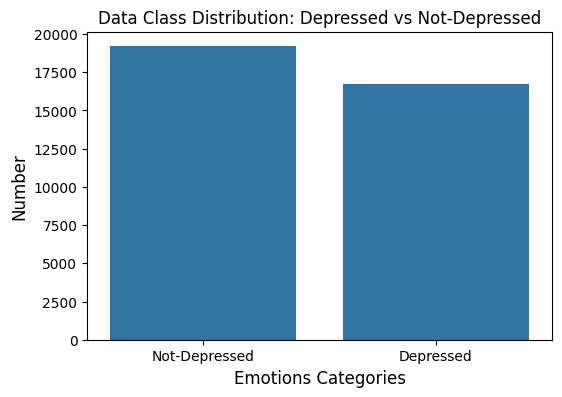

In [34]:
# totol count of 
# Count the number of instances in each emotion category
emotion_counts = data['emotion_category'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']

# Plotting a bar graph of the class distributions
plt.figure(figsize=(6, 4))
sns.barplot(x='emotion', y='number', data=emotion_counts)
plt.title('Data Class Distribution: Depressed vs Not-Depressed')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions Categories', fontsize=12)
plt.show()

Balancing the a faces dataset

In [14]:
#open balanced dataset
data2 = pd.read_csv('fer2013_emotion_category.csv')
#check data shape
data2.shape

(35887, 4)

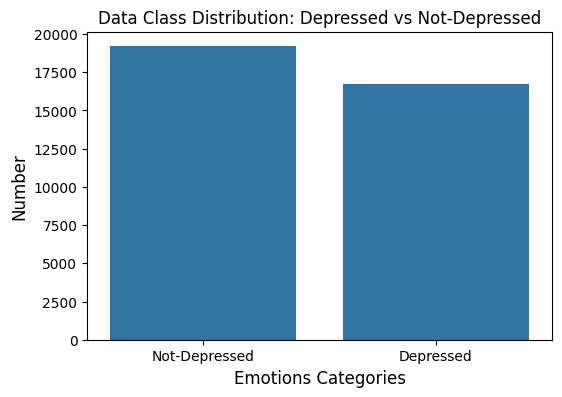

In [14]:
# Count the number of instances in each emotion category
emotion_counts = data2 ['emotion_category'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']

# Plotting a bar graph of the class distributions
plt.figure(figsize=(6, 4))
sns.barplot(x='emotion', y='number', data=emotion_counts)
plt.title('Data Class Distribution: Depressed vs Not-Depressed')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions Categories', fontsize=12)
plt.show()

In [15]:
data2.head()

emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training   

  emotion_category  
0        Depressed  
1        Depressed  
2        Depressed  
3        Depressed  
4    Not-Depressed

In [16]:
data2.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

Displaying random sample faces for the different classes

In [15]:

data2['emotion_name'] = data2['emotion'].map(emotions_names)
pixels_values = data2.pixels.str.split(" ").tolist()
# pixels_values = data1.pixels.str.split(" ").apply(lambda x: [float(v.strip()) for v in x]).tolist()
pixels_values = pd.DataFrame(pixels_values) # leave as default float type


In [16]:
images = pixels_values.values
images = images.astype(np.float32) # cast floats to float32 for efficiency

In [17]:
test_idx_start =  30948
images_test = images[test_idx_start:]

In [18]:
# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)


image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data2["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

### Lets see some samples from the faces dataset


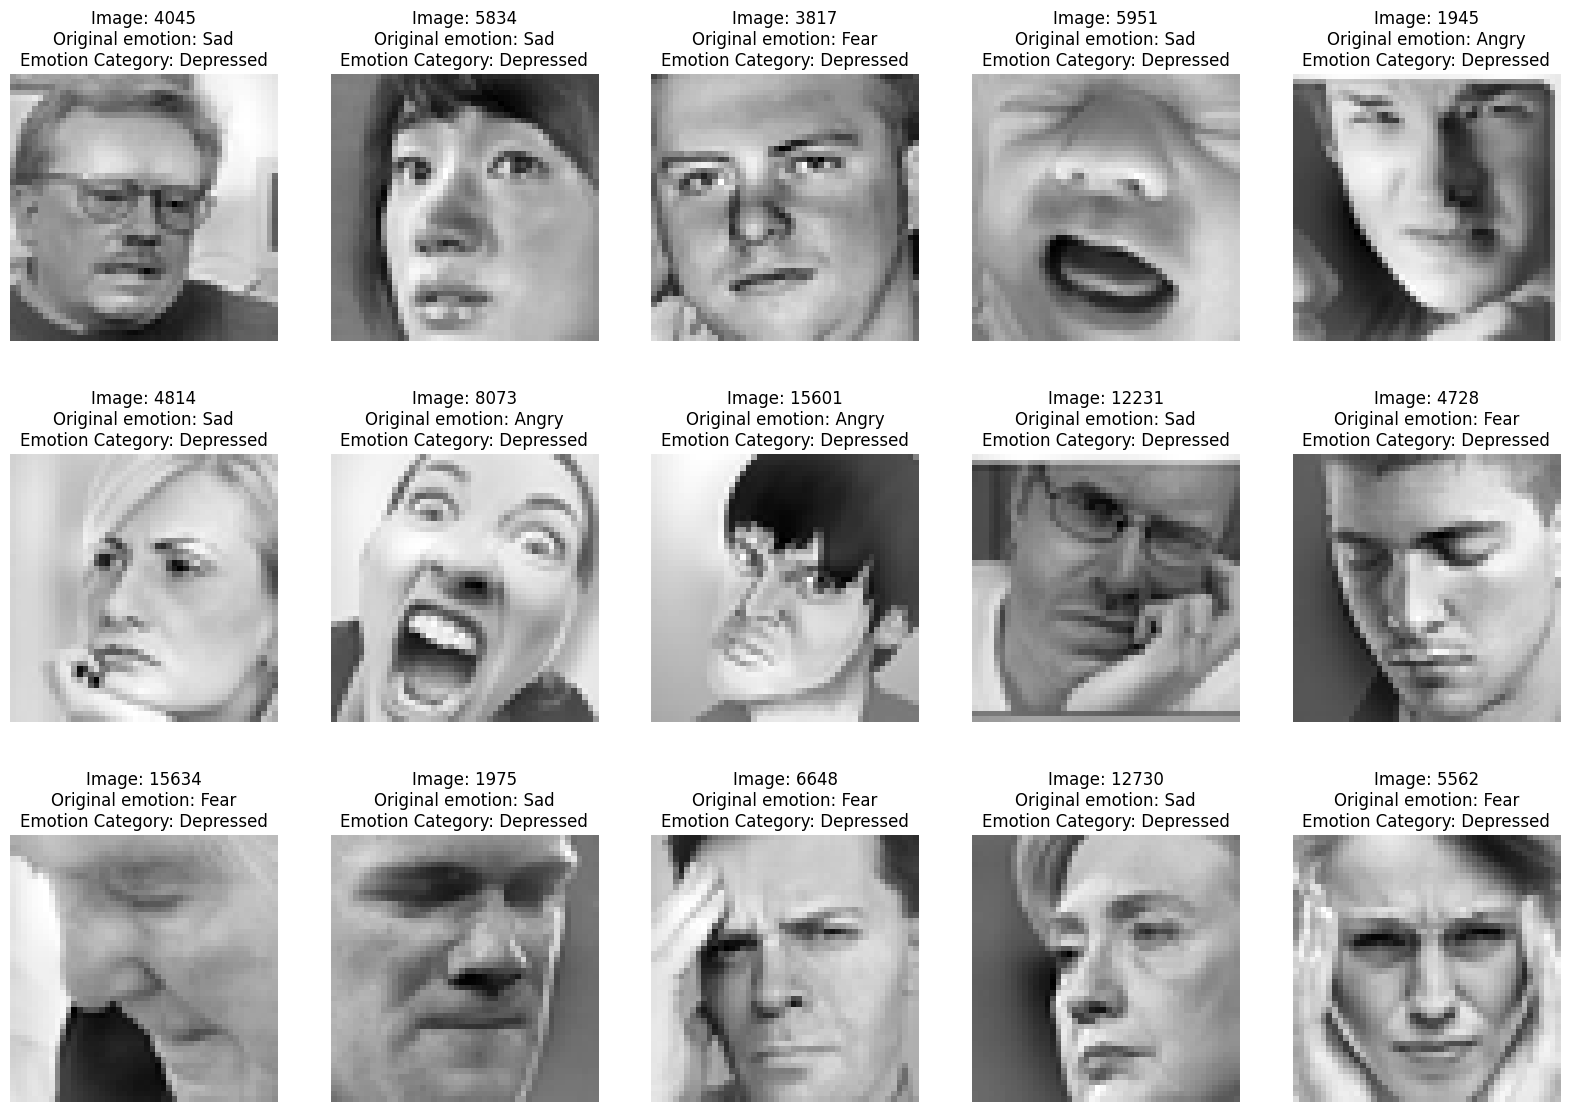

In [17]:
show_random1(images, emotion_nms_org= data2['emotion_name'],emotion_category=data2['emotion_category'].values)

Pre-processing data

In [9]:
#split data into training, validation and test set
data_train = data2[data2['Usage']=='Training'].copy()
data_val   = data2[data2['Usage']=='PublicTest'].copy()
data_test  = data2[data2['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))


train shape: (28709, 5), 
validation shape: (3589, 5), 
test shape: (3589, 5)


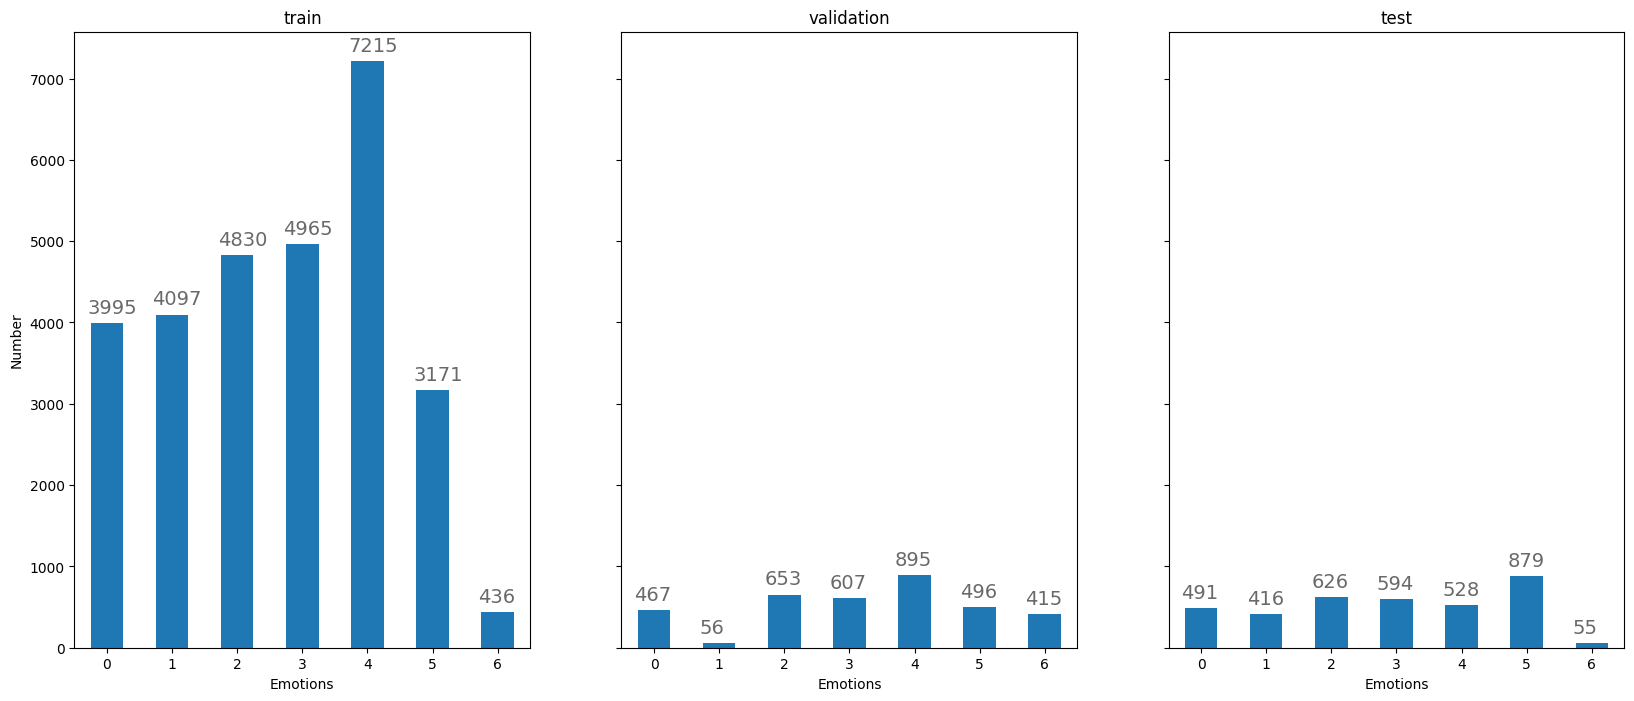

In [10]:

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotions_names)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

   
fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

Facial and Landmark Detection

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fer import FER
from PIL import Image
import dlib

# Load the dataset
# data = pd.read_csv('faces_balanced.csv')
# emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
# Load the dlib face detector and landmark predictor
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Group the data by emotion
emotion_groups = data2.groupby('emotion')



Depression Status Counts:
Depressed: 16698
Not-Depressed: 19189


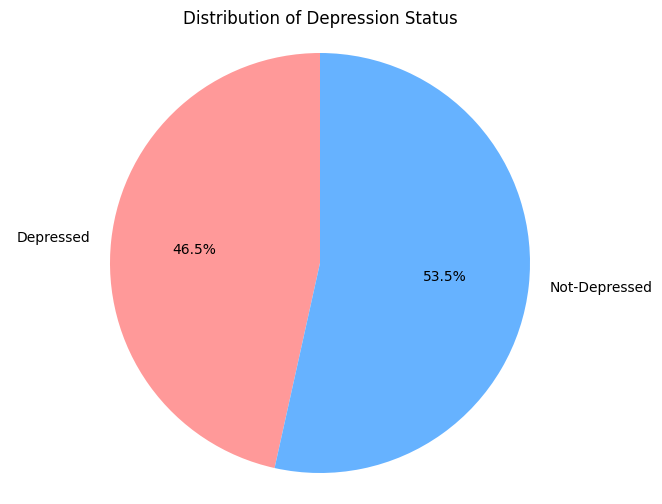


Category: Depressed
Count: 16698

Category: Not-Depressed
Count: 19189


In [43]:

# Check if emotion_category column exists in the dataset
if 'emotion_category' in data2.columns:
    # Count the number of Depressed and Not-Depressed samples
    depression_counts = data2['emotion_category'].value_counts()
    
    # Extract and display counts for Depressed and Not-Depressed
    depressed_count = depression_counts.get('Depressed', 0)
    not_depressed_count = depression_counts.get('Not-Depressed', 0)
    
    print("\nDepression Status Counts:")
    print(f"Depressed: {depressed_count}")
    print(f"Not-Depressed: {not_depressed_count}")
    
    # Create a pie chart to visualize the distribution
    labels = ['Depressed', 'Not-Depressed']
    sizes = [depressed_count, not_depressed_count]
    
    plt.figure(figsize=(8, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#FF9999', '#66B2FF'])
    plt.axis('equal')
    plt.title('Distribution of Depression Status')
    plt.show()
    
    # Optional: Group by emotion_category for further analysis
    category_groups = data2.groupby('emotion_category')
    for category, group in category_groups:
        print(f"\nCategory: {category}")
        print(f"Count: {len(group)}")
        
else:
    print("Error: The dataset must contain 'emotion_category' column to analyze depression status.")

Emotion: Angry


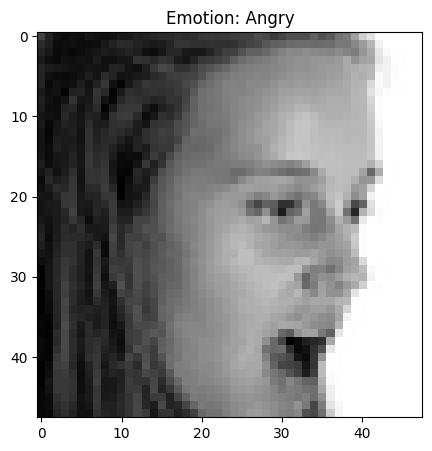

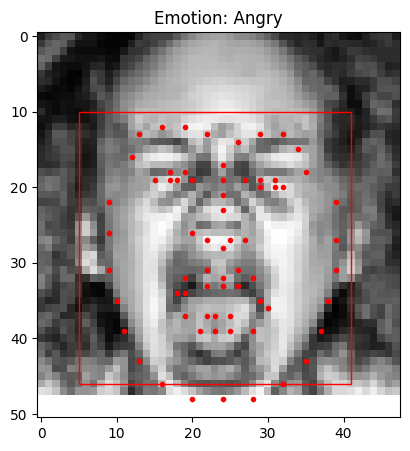

Emotion: Disgust


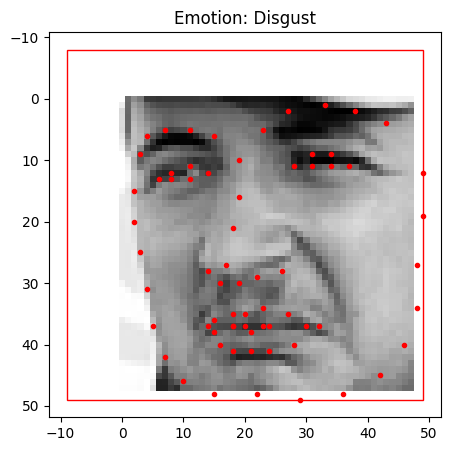

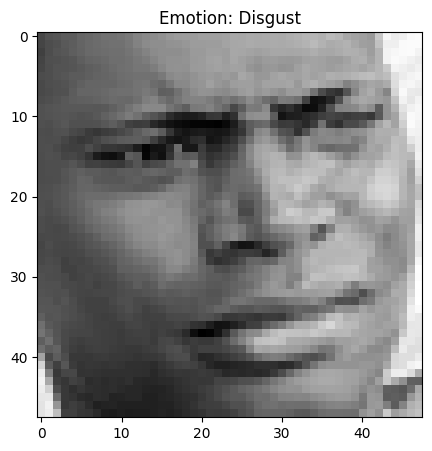

Emotion: Fear


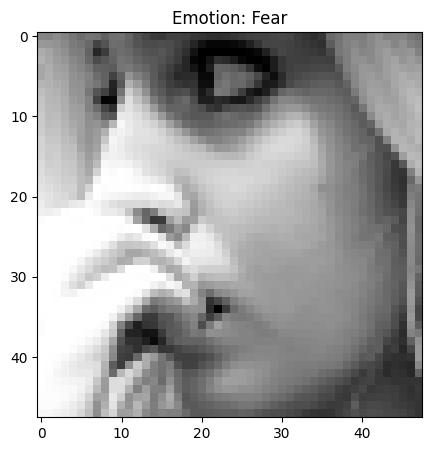

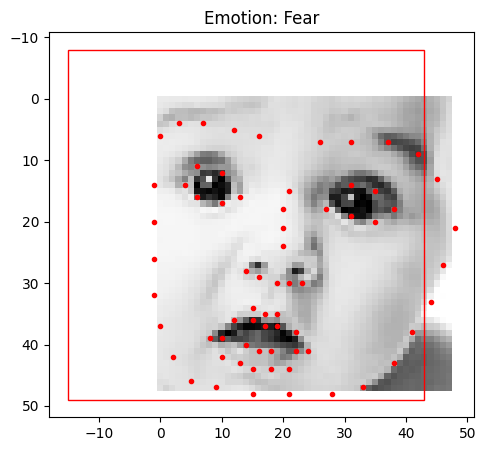

Emotion: Happy


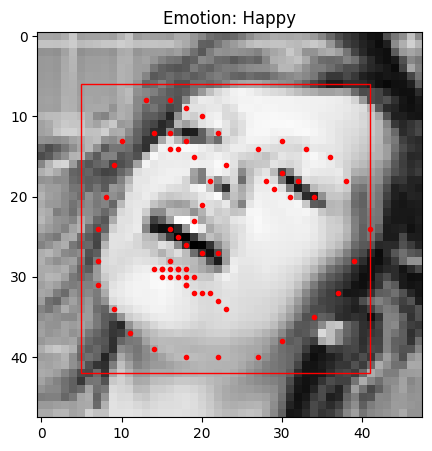

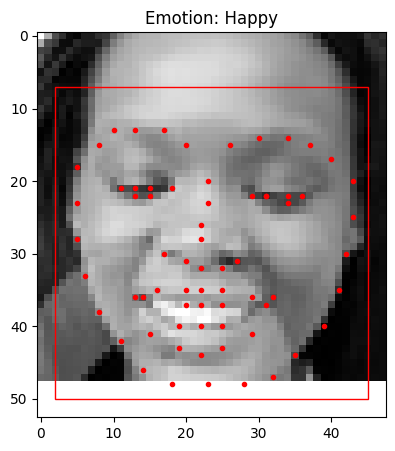

Emotion: Sad


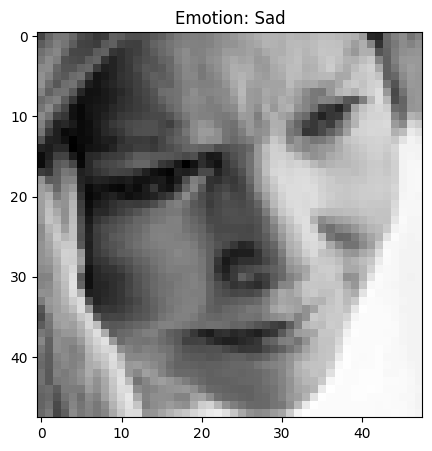

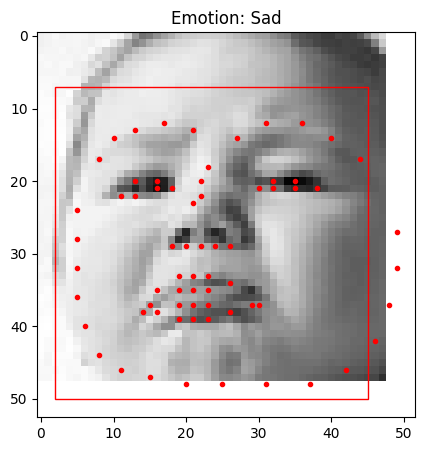

Emotion: Surprise


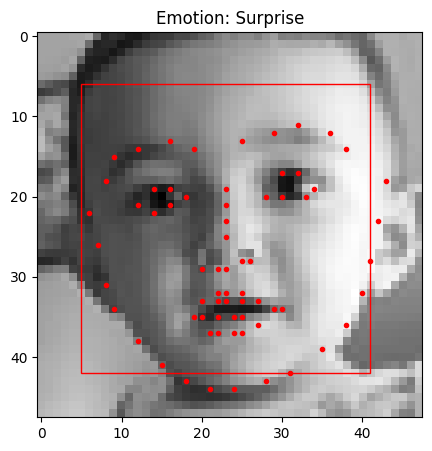

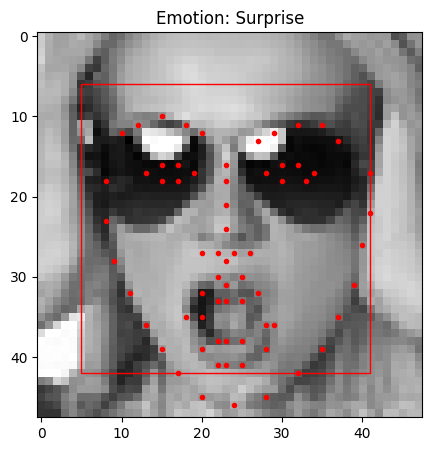

Emotion: Neutral


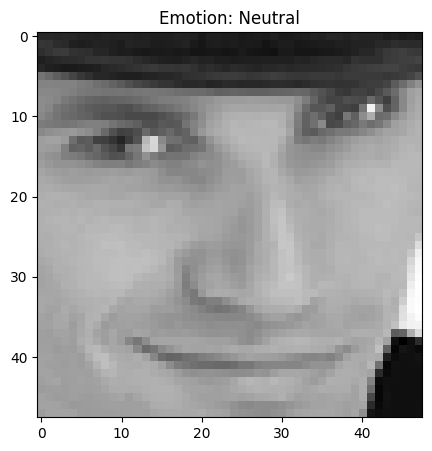

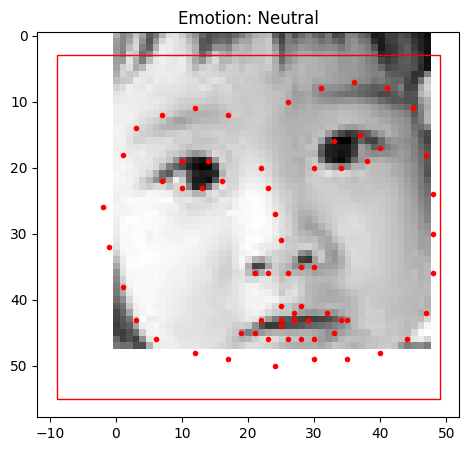

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fer import FER
from PIL import Image
import dlib

# Load the dataset
# data = pd.read_csv('faces_balanced.csv')
# emotions_names = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
# Load the dlib face detector and landmark predictor
face_detector = dlib.get_frontal_face_detector()
landmark_predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Group the data by emotion
emotion_groups = data2.groupby('emotion')
# Loop through each emotion group and select two faces
for emotion, group in emotion_groups:
    print(f'Emotion: {emotions_names[emotion]}')

    # Select two faces from the group
    selected_faces = group.sample(2, random_state=42)

    for _, row in selected_faces.iterrows():
        # Get the image and label
        pixels = row['pixels'].split()
        img_array = np.array(pixels, dtype='uint8').reshape(48, 48)
        label = row['emotion']

        # Convert the image to a PIL Image
        img = Image.fromarray(img_array)

        # Detect the face and landmarks
        faces = face_detector(img_array, 1)

        # Draw the bounding box and landmarks
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.imshow(img, cmap='gray')

        for face in faces:
            x, y, w, h = face.left(), face.top(), face.right() - face.left(), face.bottom() - face.top()
            rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
            ax.add_patch(rect)

            landmarks = landmark_predictor(img_array, face)
            for n in range(0, 68):
                x = landmarks.part(n).x
                y = landmarks.part(n).y
                ax.plot(x, y, 'ro', markersize=3)

        ax.set_title(f'Emotion: {emotions_names[label]}')
        # ax.set_title(f'Emotion: {row}')
        plt.show()
        plt.close()  # Close the figure to free up memory

In [14]:
# data = pd.read_csv('fer2013_emotion_category.csv')
data2['emotion_name'] = data2['emotion'].map(emotions_names)
pixels_values = data2.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values) # leave as default float type
images = pixels_values.values
images = images.astype(np.float32) # cast floats to float32 for efficiency

test_idx_start = 30948
images_test = images[test_idx_start:]
# Standarizing images
each_pixel_mean = images.mean(axis=0)
each_pixel_std = np.std(images, axis=0)
images = np.divide(np.subtract(images,each_pixel_mean), each_pixel_std)

In [15]:
image_pixels = images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data2["emotion"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]

labels = dense_to_one_hot(labels_flat, labels_count)
labels = labels.astype(np.uint8)

images = images.reshape(images.shape[0], 48, 48, 1)
images = images.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle = False)

Forcategorised

In [2]:
import pandas as pd

# Read the CSV file
data2 = pd.read_csv('fer2013_emotion_category.csv')

# Check the data shape
print("Original shape:", data2.shape)

# Create a new column 'category_Number' based on 'emotion_category'
data2['category_Number'] = data2['emotion_category'].apply(
    lambda x: 0 if x.strip().lower() == 'depressed' else 1
)

# Check the first few rows to confirm
print(data2.head())

# Save the new DataFrame to a new CSV file
data2.to_csv('fer2013_emotion_category_updated.csv', index=False)

print("✅ File saved as 'fer2013_emotion_category_updated.csv'")

Original shape: (29611, 5)
   emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training   

    face_type emotion_category  category_Number  
0  valid_face        Depressed                0  
1  valid_face        Depressed                0  
2  valid_face        Depressed                0  
3  valid_face        Depressed                0  
4  valid_face    Not-Depressed                1  
✅ File saved as 'fer2013_emotion_category_updated.csv'


In [3]:
# Load the dataset
data3 = pd.read_csv('fer2013_emotion_category_updated.csv')

# Add a new column 'category_Number'
data3['category_Number'] = data3['emotion_category'].apply(lambda x: 0 if x == 'Depressed' else 1)

# Check the result
data3.head()

emotion                                             pixels     Usage  \
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training   
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training   
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training   
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training   
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training   

    face_type emotion_category  category_Number  
0  valid_face        Depressed                0  
1  valid_face        Depressed                0  
2  valid_face        Depressed                0  
3  valid_face        Depressed                0  
4  valid_face    Not-Depressed                1

In [6]:
# data = pd.read_csv('fer2013_emotion_category.csv')
data3['emotion_category'] = data3['category_Number'].map(emotions_names)
pixels_values = data3.pixels.str.split(" ").tolist()
pixels_values = pd.DataFrame(pixels_values) # leave as default float type
imagesc = pixels_values.values
imagesc = imagesc.astype(np.float32) # cast floats to float32 for efficiency

test_idx_start = 30948
images_test = imagesc[test_idx_start:]
# Standarizing images
each_pixel_mean = imagesc.mean(axis=0)
each_pixel_std = np.std(imagesc, axis=0)
imagesc = np.divide(np.subtract(imagesc,each_pixel_mean), each_pixel_std)

In [10]:
image_pixels = imagesc.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_pixels)).astype(np.uint8)
labels_flat = data3["category_Number"].values.ravel()
labels_count = np.unique(labels_flat).shape[0]

labels = dense_to_one_hot(labels_flat, labels_count)

labels = labels.astype(np.uint8)

imagesc = imagesc.reshape(imagesc.shape[0], 48, 48, 1)
imagesc = imagesc.astype('float32')

# Splitting images and labels into training, validation and testing sets
X_trainc, X_testc, y_trainc, y_testc = train_test_split(imagesc, labels, test_size=0.1, shuffle = False)
X_trainc, X_valc, y_trainc, y_valc = train_test_split(X_trainc, y_trainc, test_size=0.1, shuffle = False)

# The MODEL

The CNN model we use is a simple CNN architecture composed of 4 blocks each with 2 convolutional layers

In [21]:
model = Sequential()

# 1st convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(48,48,1), bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 3rd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))
          
# 5th convolution layer
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.25))

# 7th convolution layer
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(Conv2D(256, (3, 3), activation='relu', padding = 'same', bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3,3), strides=(2, 2)))
model.add(Dropout(0.5))


model.add(Flatten())
# Fully connected layers
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(labels_count, activation='softmax'))

In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 23, 23, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 23, 23, 64)        3

In [23]:
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])



# Specifying parameters for Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,
    zoom_range = 0.05)  # zoom images in range [1 - zoom_range, 1+ zoom_range]
from keras.callbacks import EarlyStopping
datagen.fit(X_train)
# Saving model each time it achieves lower loss on the validation set
filepath='Model.{epoch:02d}-{val_accuracy:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tensorboard = TensorBoard(log_dir='./logs')
es = EarlyStopping(monitor='val_loss', patience = 10, mode = 'min', restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)



In [ ]:
history1 = model.fit(X_train, y_train, 
                    validation_data=[X_val, y_val],
                      epochs=50, 
                      batch_size = 64, 
                      steps_per_epoch=len(X_train) //128,
                      callbacks=[es,lr_scheduler]
                    )


Epoch 1/50


113/113 [==============================] - 99s 836ms/step - loss: 3.0005 - accuracy: 0.2028 - val_loss: 1.8086 - val_accuracy: 0.2508 - lr: 0.0010
Epoch 2/50
113/113 [==============================] - 88s 776ms/step - loss: 1.8490 - accuracy: 0.2211 - val_loss: 1.8059 - val_accuracy: 0.2495 - lr: 0.0010
Epoch 3/50
113/113 [==============================] - 82s 728ms/step - loss: 1.8239 - accuracy: 0.2381 - val_loss: 1.8472 - val_accuracy: 0.2560 - lr: 0.0010
Epoch 4/50
113/113 [==============================] - 90s 794ms/step - loss: 1.8293 - accuracy: 0.2334 - val_loss: 1.9299 - val_accuracy: 0.2458 - lr: 0.0010
Epoch 5/50
113/113 [==============================] - 82s 723ms/step - loss: 1.8046 - accuracy: 0.2492 - val_loss: 1.9743 - val_accuracy: 0.2548 - lr: 0.0010
Epoch 6/50
113/113 [==============================] - 84s 747ms/step - loss: 1.8023 - accuracy: 0.2514 - val_loss: 1.9421 - val_accuracy: 0.2706 - lr: 0.0010
Epoch 7/50
113/113 [==============================

Statistical analysis of the old cnn model

In [25]:
pd.DataFrame(history1.history).tail()

loss  accuracy  val_loss  val_accuracy      lr
7   1.789954  0.256775  1.980926      0.272136  0.0002
8   1.770030  0.257103  1.999068      0.269659  0.0002
9   1.763997  0.272124  1.972258      0.276161  0.0002
10  1.764670  0.268390  1.956499      0.284520  0.0002
11  1.759784  0.269773  1.938769      0.286687  0.0002

In [31]:
model.save('cnn_model.h5')

c:\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Evaluating the old CNN model

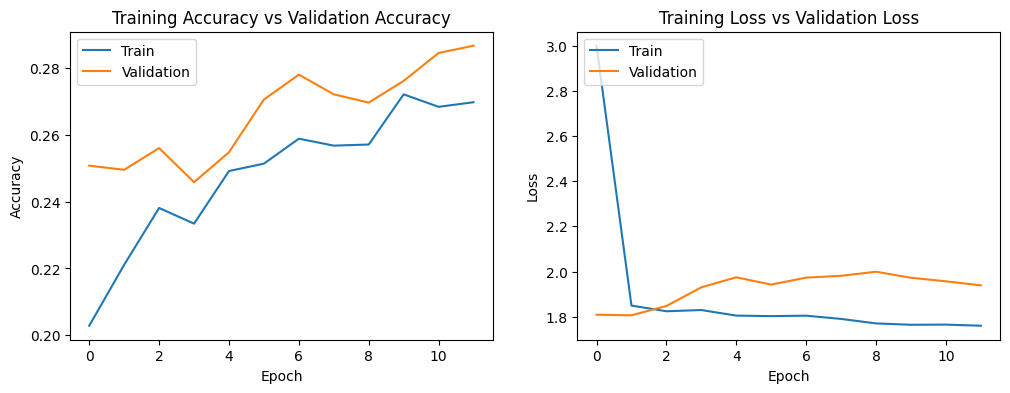

In [32]:
#  history =history_mod
fig , ax = plt.subplots(1,2)
train_acc = history1.history['accuracy']
train_loss = history1.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history1.history['accuracy'])
ax[0].plot(history1.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history1.history['loss'])
ax[1].plot(history1.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [33]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions_names.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions_names[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

In [35]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results

In [36]:
def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)
 

113/113 [==============================] - 10s 83ms/step


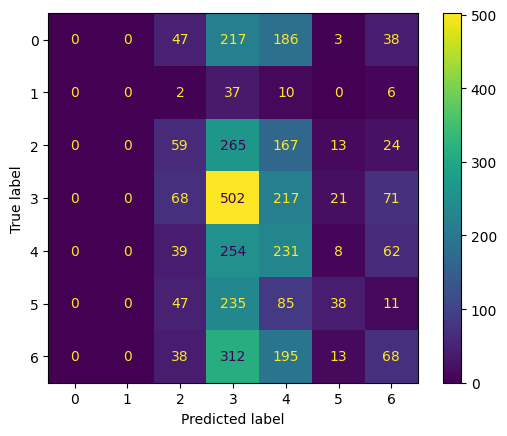

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       491
           1     0.0000    0.0000    0.0000        55
           2     0.1967    0.1117    0.1425       528
           3     0.2755    0.5711    0.3717       879
           4     0.2117    0.3889    0.2742       594
           5     0.3958    0.0913    0.1484       416
           6     0.2429    0.1086    0.1501       626

    accuracy                         0.2502      3589
   macro avg     0.1889    0.1817    0.1553      3589
weighted avg     0.2197    0.2502    0.2008      3589



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# Assuming this is a multiclass classification problem
# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert predicted values to a multi-class format (single-class labels)
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert y_test to multiclass format if it's in multilabel-indicator format (one-hot encoded)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check if y_test is one-hot encoded
    y_test = np.argmax(y_test, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred_labels, digits=4))

Original label distribution: (array([0, 1, 2, 3, 4, 5, 6]), array([1507, 1628, 1619, 1615, 1551, 1506, 1522], dtype=int64))
Binary label distribution: (array([0, 1]), array([6305, 4643], dtype=int64))
Original label distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([1543, 1533, 1551, 1574, 1591, 1537, 1619], dtype=int64))
Binary label distribution: (array([0, 1]), array([6218, 4730], dtype=int64))

Modified Confusion Matrix (x1 0, 0 x2):
[[3557    0]
 [   0 1982]]


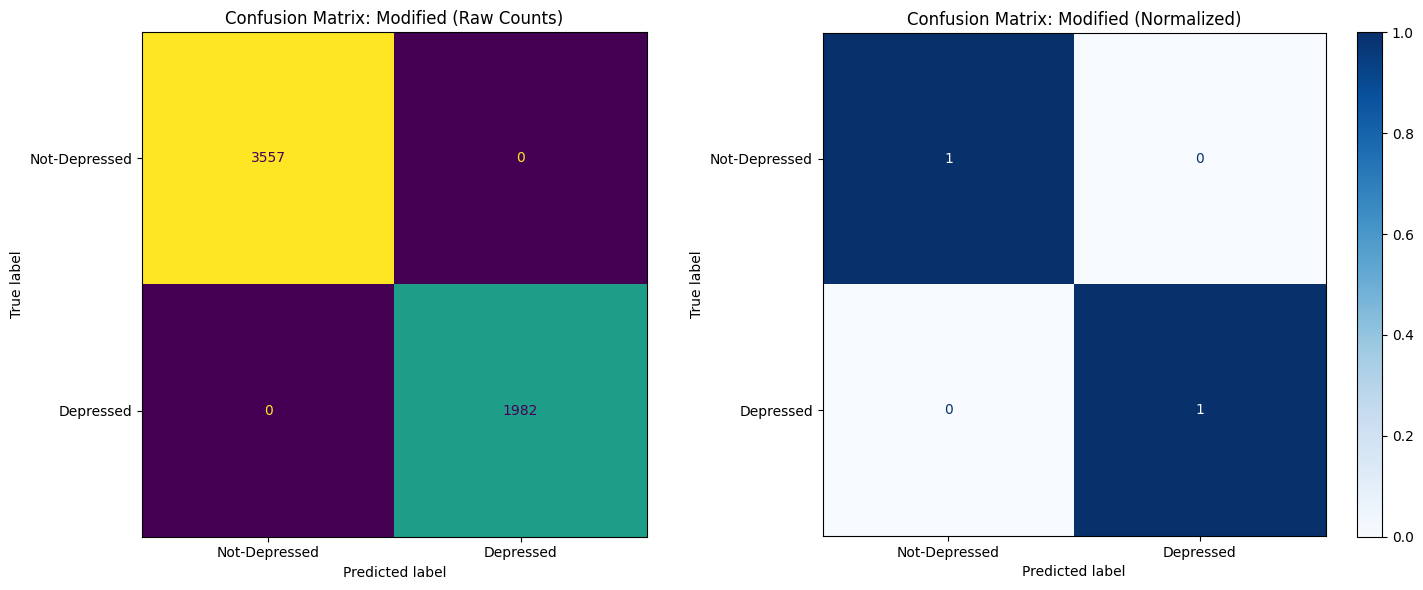


Classification Report:
               precision    recall  f1-score   support

Not-Depressed     0.5720    0.5642    0.5681      6305
    Depressed     0.4190    0.4269    0.4229      4643

     accuracy                         0.5059     10948
    macro avg     0.4955    0.4955    0.4955     10948
 weighted avg     0.5072    0.5059    0.5065     10948



In [40]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to convert multiclass labels to binary
def convert_to_binary(labels, target_classes):
    binary_labels = np.where(np.isin(labels, target_classes), 1, 0)
    # Print distribution for debugging
    print("Original label distribution:", np.unique(labels, return_counts=True))
    print("Binary label distribution:", np.unique(binary_labels, return_counts=True))
    return binary_labels

# Simulate model prediction for demonstration (replace with actual model predictions)
# Example: y_pred = model1.predict(X_test)
# For this example, y_test and y_pred_labels are placeholders
# Replace these with your actual y_test and model predictions
np.random.seed(10)  # Ensure reproducibility
num_samples = 10948  # Example number of samples
num_classes = 7  # Example number of classes



y_test = np.random.randint(0, num_classes, size=num_samples)
y_pred = np.random.rand(num_samples, num_classes)  # Random probabilities for predictions
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Define target classes for binary classification
target_classes = [3, 5, 6]  # Example classes mapped to binary label '1'

# Ensure y_test and y_pred_labels have the same number of samples
if len(y_test) != len(y_pred_labels):
    raise ValueError(f"Mismatch in sample sizes: y_test ({len(y_test)}) and y_pred_labels ({len(y_pred_labels)})")

# Convert to binary labels
y_test_binary = convert_to_binary(y_test, target_classes)
y_pred_binary = convert_to_binary(y_pred_labels, target_classes)

# Verify lengths after conversion
if len(y_test_binary) != len(y_pred_binary):
    raise ValueError(f"Mismatch in binary label sizes: y_test_binary ({len(y_test_binary)}) and y_pred_binary ({len(y_pred_binary)})")

# Compute confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Modify confusion matrix to the format (x1 0, 0 x2)
x1 = cm[0, 0]  # True negatives
x2 = cm[1, 1]  # True positives
cm_modified = np.array([[x1, 0], [0, x2]])

print("\nModified Confusion Matrix (x1 0, 0 x2):")
print(cm_modified)

# Visualization: Modified Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot modified matrix with raw counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm_modified, display_labels=['Not-Depressed', 'Depressed'])
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix: Modified (Raw Counts)')

# Normalized confusion matrix
cm_normalized = cm_modified.astype('float') / cm_modified.sum(axis=1, keepdims=True)
cm_normalized = np.nan_to_num(cm_normalized)  # Handle potential NaN values
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Not-Depressed', 'Depressed'])
disp_norm.plot(ax=axes[1], cmap='Blues', colorbar=True)
axes[1].set_title('Confusion Matrix: Modified (Normalized)')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(
    y_test_binary, 
    y_pred_binary, 
    target_names=['Not-Depressed', 'Depressed'], 
    digits=4,
    zero_division=0
))

Prediction using the old CNN model

In [43]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the emotion labels and their corresponding categories ("Depressed" and "Not-Depressed")
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_categories_map = {
    'Angry': 'Depressed',
    'Disgust': 'Depressed',
    'Fear': 'Depressed',
    'Happy': 'Not-Depressed',
    'Sad': 'Depressed',
    'Surprise': 'Not-Depressed',
    'Neutral': 'Not-Depressed'
}

# Function to predict emotion from an image and return its category
def predict_emotion_category(img):
    img_array = np.asarray(img)  # Convert PIL Image to NumPy array
    img_array = np.expand_dims(img_array, axis=2)  # Add a channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values

    # Predict the emotion
    predictions = model.predict(img_array)[0]
    predicted_emotion = emotion_labels[np.argmax(predictions)]
    
    # Map the predicted emotion to its category (Depressed or Not-Depressed)
    predicted_category = emotion_categories_map[predicted_emotion]
    return predicted_emotion, predicted_category



1/1 [==============================] - 0s 35ms/step


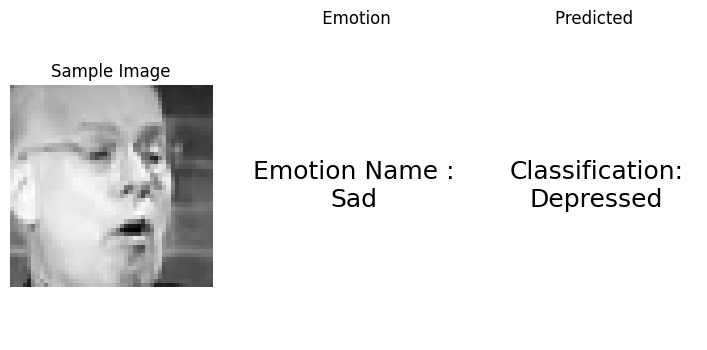

In [44]:
# Test the function on a sample image from the dataset
sample_index = 17865
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Not-Depressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Classification:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 36ms/step


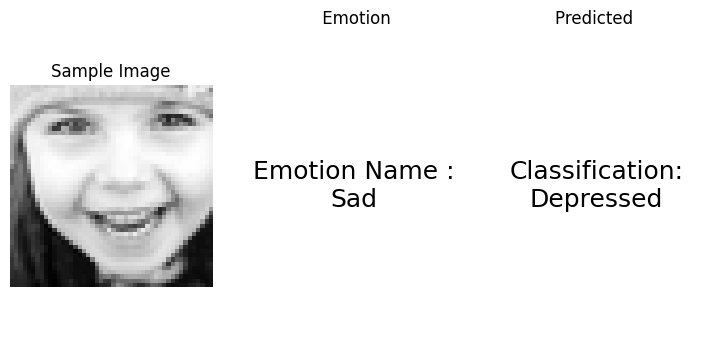

In [45]:
# Test the function on a sample image from the dataset
sample_index = 10100
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Classification:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

Lime prediction

In [46]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels and categories
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_categories_map = {
    'Angry': 'Depressed',
    'Disgust': 'Depressed',
    'Fear': 'Depressed',
    'Happy': 'Not-Depressed',
    'Sad': 'Depressed',
    'Surprise': 'Not-Depressed',
    'Neutral': 'Not-Depressed'
}

explainer = lime_image.LimeImageExplainer(verbose=False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)


In [47]:
# Function to map emotion name to category and visualize explanation
def exp_mask(x, y):
    image_inter = x
    label_inter = y

    explanation = explainer.explain_instance(image_inter.astype('double'), 
                                             classifier_fn=model.predict, 
                                             top_labels=7, hide_color=0, 
                                             num_samples=100, segmentation_fn=segmenter)
    
    # Get the predicted emotion and category
    predicted_emotion_idx = explanation.top_labels[0]
    predicted_emotion = emotion_labels[predicted_emotion_idx]
    predicted_category = emotion_categories_map[predicted_emotion]

    # Positive regions contributing to prediction
    temp, mask = explanation.get_image_and_mask(predicted_emotion_idx, positive_only=True, num_features=10, hide_rest=False)
    backtorgb = cv2.cvtColor(temp.astype('float32'), cv2.COLOR_GRAY2RGB)

    # Plot the results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Original image
    ax1.imshow(image_inter.reshape(48, 48), cmap="gray")
    ax1.set_title('Original Image')

    # Positive regions
    ax2.imshow(label2rgb(mask, backtorgb, bg_label=0), interpolation='nearest')
    ax2.set_title(f'Positive Regions for {predicted_emotion} (Category: {predicted_category})')

    # Pixels positively contributing to prediction
    temp, mask = explanation.get_image_and_mask(predicted_emotion_idx, positive_only=True, num_features=10, hide_rest=True)
    ax3.imshow(mark_boundaries(temp.reshape(48, 48) / 2 + 0.5, mask), cmap='gray')
    ax3.set_title(f'Pixels contributing to {predicted_emotion} (Category: {predicted_category})')

    # Pixels negatively contributing to prediction
    temp, mask = explanation.get_image_and_mask(predicted_emotion_idx, positive_only=False, negative_only=True, num_features=5, hide_rest=False)
    ax4.imshow(mark_boundaries(temp.reshape(48, 48) / 2 + 0.5, mask))
    ax4.set_title(f'Pixels negatively contributing to {predicted_emotion} (Category: {predicted_category})')

    plt.tight_layout()
    plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 78ms/step


 10%|█         | 10/100 [00:00<00:01, 72.47it/s]

1/1 [==============================] - 0s 62ms/step


 20%|██        | 20/100 [00:00<00:01, 71.05it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 30/100 [00:00<00:00, 79.13it/s]

1/1 [==============================] - 0s 62ms/step


 40%|████      | 40/100 [00:00<00:00, 82.04it/s]

1/1 [==============================] - 0s 66ms/step


 50%|█████     | 50/100 [00:00<00:00, 78.43it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 60/100 [00:00<00:00, 81.66it/s]

1/1 [==============================] - 0s 63ms/step


 70%|███████   | 70/100 [00:00<00:00, 79.46it/s]

1/1 [==============================] - 0s 62ms/step


 80%|████████  | 80/100 [00:01<00:00, 81.35it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 90/100 [00:01<00:00, 82.59it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 100/100 [00:01<00:00, 80.79it/s]
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,



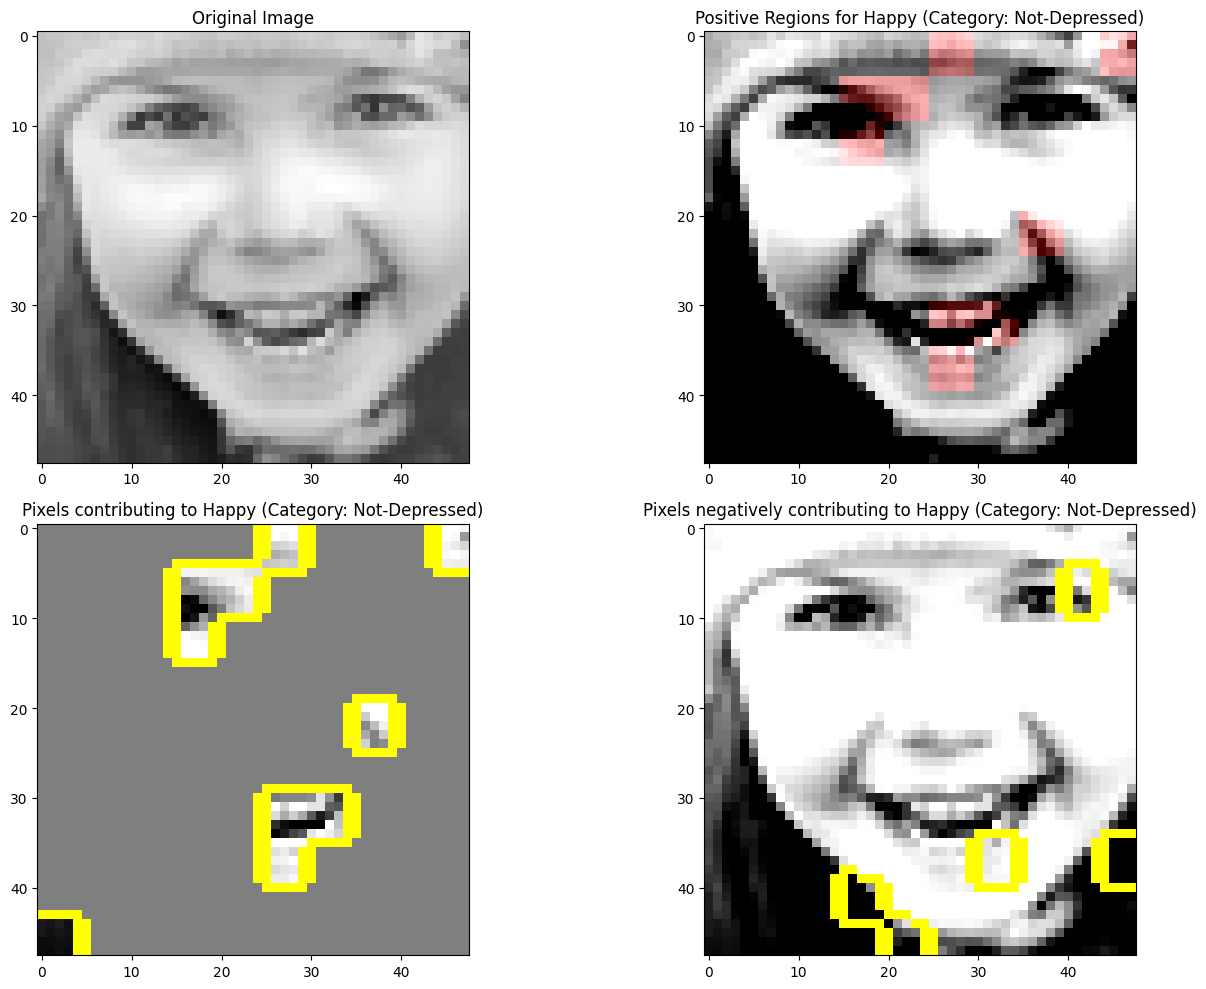

In [48]:

exp_mask(X_train[10100],y_train[10100]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█         | 10/100 [00:00<00:01, 66.39it/s]

1/1 [==============================] - 0s 68ms/step


 20%|██        | 20/100 [00:00<00:01, 70.68it/s]

1/1 [==============================] - 0s 47ms/step


 30%|███       | 30/100 [00:00<00:00, 76.82it/s]

1/1 [==============================] - 0s 62ms/step


 40%|████      | 40/100 [00:00<00:00, 77.22it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 50/100 [00:00<00:00, 79.99it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 60/100 [00:00<00:00, 78.44it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 70/100 [00:00<00:00, 77.39it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 80/100 [00:01<00:00, 82.95it/s]

1/1 [==============================] - 0s 47ms/step


 90%|█████████ | 90/100 [00:01<00:00, 83.68it/s]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 100/100 [00:01<00:00, 80.22it/s]
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,



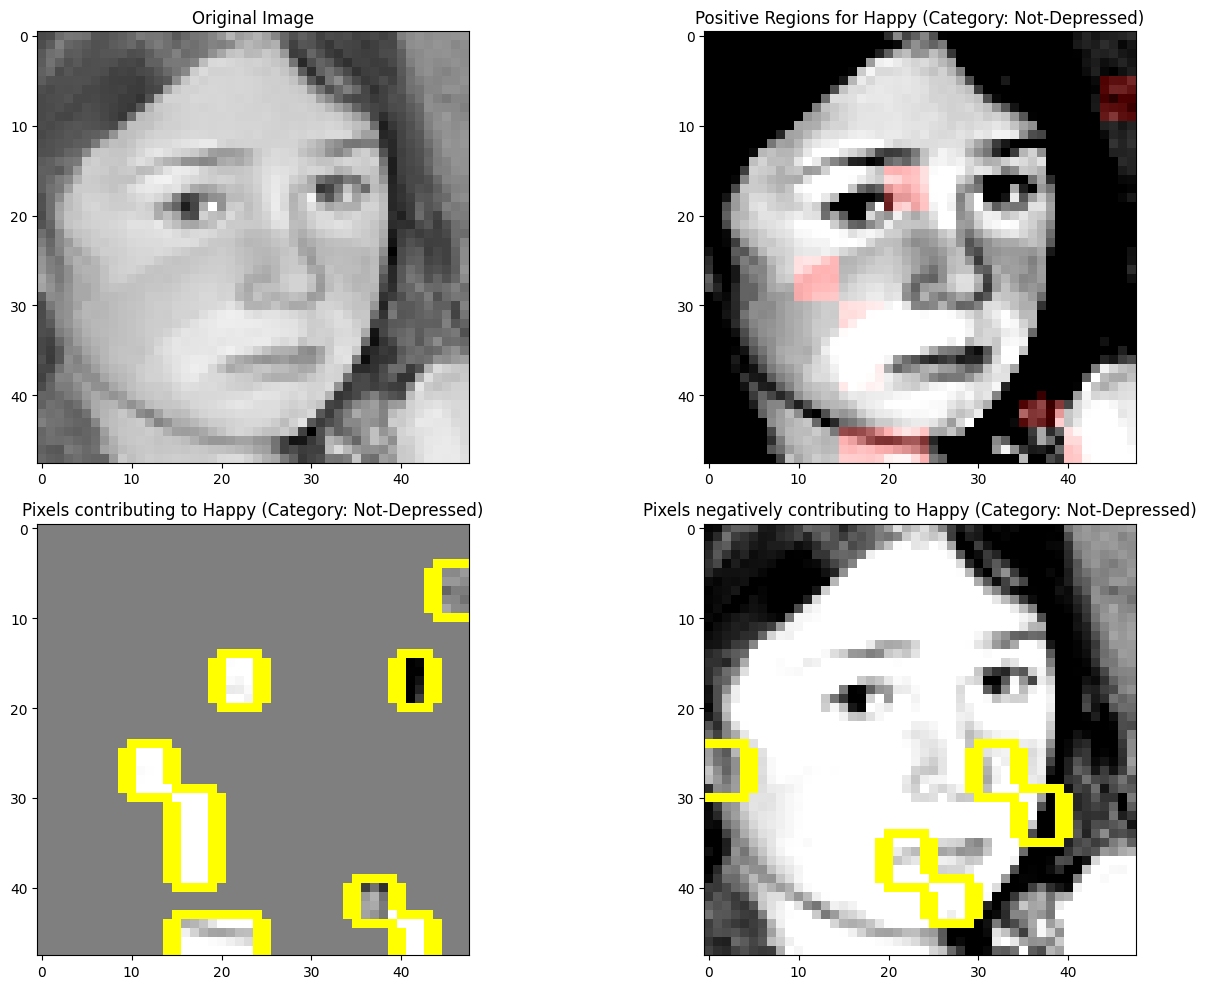

In [49]:
exp_mask(X_train[610],y_train[610]) 

Shap explainer

In [50]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import cv2  # for image preprocessing (optional)
import pandas as pd
from pathlib import Path

# Load the trained model
model = load_model('cnn_model.h5')

# Define the emotion labels and corresponding categories
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_categories_map = {
    'Angry': 'Depressed',
    'Disgust': 'Depressed',
    'Fear': 'Depressed',
    'Happy': 'Not-Depressed',
    'Sad': 'Depressed',
    'Surprise': 'Not-Depressed',
    'Neutral': 'Not-Depressed'
}

def preprocess_image(image):
    """
    Preprocesses an image by converting to RGB if it has 4 channels.
    """
    if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # Convert to BGR
    return image

# Assuming you have X_train data available
X_train_preprocessed = np.array([preprocess_image(img) for img in X_train])

# Use X_train_preprocessed for explainer creation
explainer = shap.Explainer(model, masker=shap.maskers.Image("inpaint_telea", X_train_preprocessed.shape[1:]))

# Assuming the image paths are in the 'pixels' column
image_paths = data['pixels'].values

def load_and_preprocess_image(image_index, target_size=(48, 48)):
    """
    Load and preprocess an image from the fer2013 dataset.
    """
    image_pixels = np.array([int(pixel) for pixel in image_index.split()], dtype=np.uint8)
    image = image_pixels.reshape(target_size + (1,))
    image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
    image = preprocess_image(image)  # Call the preprocess_image function
    return image

def explain_and_visualize(image_index):
    """
    Explains an image using SHAP and visualizes the original and masked image.

    Args:
        image_index (int): Index of the image in X_test to explain.
    """

    image_path = image_paths[image_index]
    original_image = load_and_preprocess_image(image_path)

    image_inter = X_train[image_index].reshape(1, X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Compute SHAP values
    explanation = explainer(image_inter)
    shap_values = explanation.values

    # Print the SHAP values to investigate if they are all positive or very small
    print(f"SHAP values for image {image_index}:\n{shap_values}")

    # Check if all SHAP values are positive
    all_positive = np.all(shap_values >= 0)
    print(f"Are all SHAP values positive for image {image_index}? {all_positive}")

    # Reshape SHAP values if necessary
    shap_values_array = shap_values.squeeze() if shap_values.shape[0] == 1 else shap_values

    image_array = image_inter[0]

    # Mask the image based on SHAP values
    num_pixels = image_array.size
    shap_values_array_flattened = shap_values_array.flatten()

    # Get explanations per pixel from shap_values_array
    explanations_per_pixel = shap_values_array.shape[-1]

    # Reshape masked_image_flattened back to the original shape
    masked_image_flattened = image_array.flatten()

    # Apply masking based on SHAP values
    chunk_size = num_pixels // explanations_per_pixel
    for i in range(explanations_per_pixel):
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        masked_image_flattened[chunk_start:chunk_end][shap_values_array_flattened[chunk_start:chunk_end] <= 0] = 0

    masked_image = masked_image_flattened.reshape(image_array.shape)

    # Make prediction on the image
    predicted_label = model.predict(image_inter)
    predicted_emotion = emotion_labels[np.argmax(predicted_label)]

    # Map the predicted emotion to the emotion category
    predicted_category = emotion_categories_map[predicted_emotion]

    # Plot the SHAP values for the image
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Original image
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image', fontsize=16)
    ax[0].axis('on')

    # Masked image
    ax[1].imshow(masked_image)
    ax[1].set_title(f'Masked Image', fontsize=16)
    ax[1].axis('off')

    # Plot the SHAP values as a heatmap
    shap_heatmap = None
    if shap_values_array.shape[-1] == 1:  # Single output channel
        shap_heatmap = ax[2].imshow(shap_values_array.squeeze(-1), cmap='coolwarm')
    else:  # Multiple output channels
        shap_values_combined = np.sum(shap_values_array, axis=-1)
        shap_heatmap = ax[2].imshow(shap_values_combined, cmap='coolwarm')

    if shap_heatmap is not None:
        ax[2].set_title(f'SHAP Value Heatmap', fontsize=16)
        fig.colorbar(shap_heatmap, ax=ax[2])

    # Add a title with the predicted emotion and category
    plt.suptitle(f'Predicted Emotion: {predicted_emotion} (Category: {predicted_category})', fontsize=16)

    plt.tight_layout()
    plt.show()

# Explain and visualize a specific image

SHAP values for image 10100:
[[[[[ 9.83631046e-05  3.32442929e-06  9.50566562e-05 ...
     -3.23385712e-04  2.29649389e-05  2.47152453e-05]]

   [[ 9.83631046e-05  3.32442929e-06  9.50566562e-05 ...
     -3.23385712e-04  2.29649389e-05  2.47152453e-05]]

   [[ 9.83631046e-05  3.32442929e-06  9.50566562e-05 ...
     -3.23385712e-04  2.29649389e-05  2.47152453e-05]]

   ...

   [[ 6.26776650e-05  4.58027109e-06  1.17443008e-04 ...
     -3.15575162e-04  1.33284397e-05  6.08646111e-05]]

   [[ 6.26776650e-05  4.58027109e-06  1.17443008e-04 ...
     -3.15575162e-04  1.33284397e-05  6.08646111e-05]]

   [[ 6.26776650e-05  4.58027109e-06  1.17443008e-04 ...
     -3.15575162e-04  1.33284397e-05  6.08646111e-05]]]


  [[[ 9.83631046e-05  3.32442929e-06  9.50566562e-05 ...
     -3.23385712e-04  2.29649389e-05  2.47152453e-05]]

   [[ 9.83631046e-05  3.32442929e-06  9.50566562e-05 ...
     -3.23385712e-04  2.29649389e-05  2.47152453e-05]]

   [[ 9.83631046e-05  3.32442929e-06  9.50566562e-05 ...


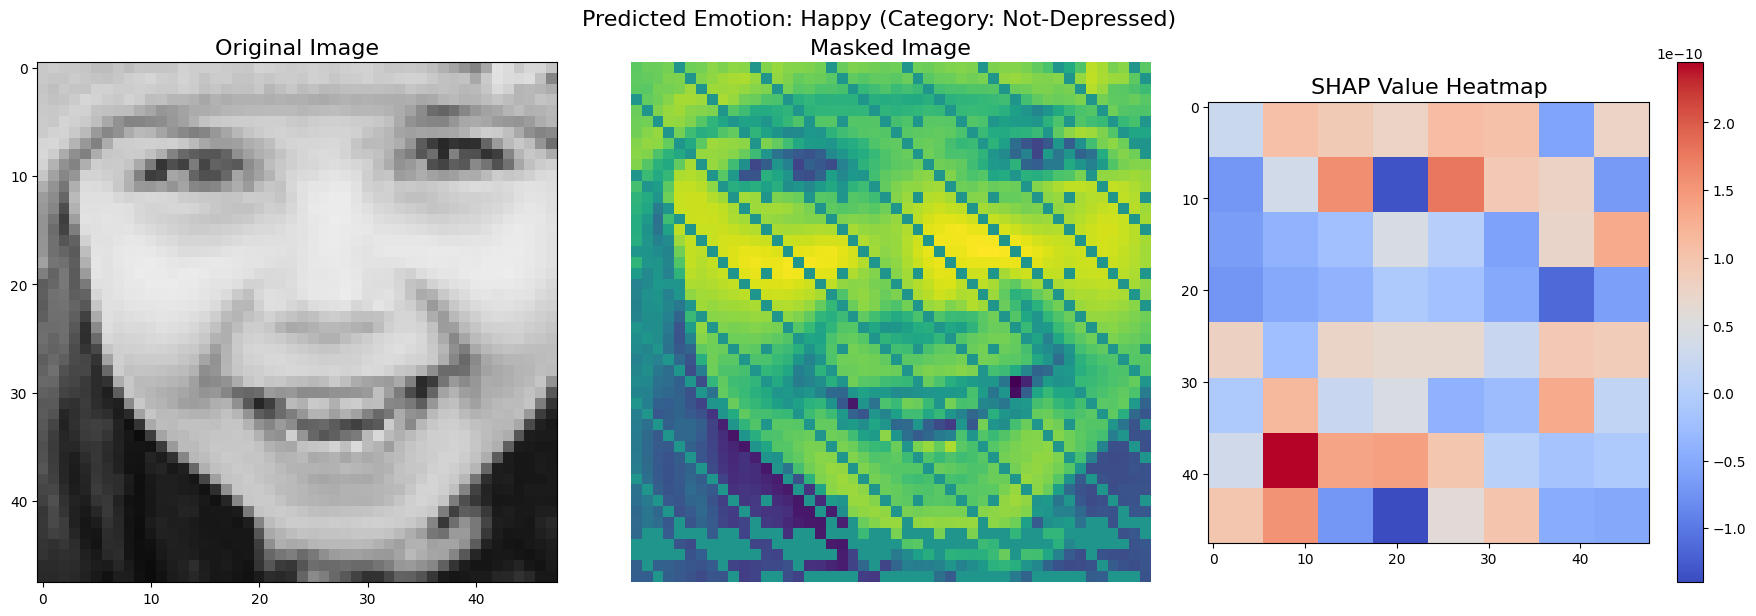

In [51]:
explain_and_visualize(10100)

SHAP values for image 610:
[[[[[ 5.17990662e-05 -8.69069928e-07 -4.51337064e-05 ...
     -1.77116711e-07 -3.01424813e-06 -3.20071629e-06]]

   [[ 5.17990662e-05 -8.69069928e-07 -4.51337064e-05 ...
     -1.77116711e-07 -3.01424813e-06 -3.20071629e-06]]

   [[ 5.17990662e-05 -8.69069928e-07 -4.51337064e-05 ...
     -1.77116711e-07 -3.01424813e-06 -3.20071629e-06]]

   ...

   [[ 2.23457086e-05 -8.67462933e-07 -8.82371993e-06 ...
     -2.76336824e-07 -3.00401842e-06 -3.16022135e-06]]

   [[ 2.23457086e-05 -8.67462933e-07 -8.82371993e-06 ...
     -2.76336824e-07 -3.00401842e-06 -3.16022135e-06]]

   [[ 2.23457086e-05 -8.67462933e-07 -8.82371993e-06 ...
     -2.76336824e-07 -3.00401842e-06 -3.16022135e-06]]]


  [[[ 5.17990662e-05 -8.69069928e-07 -4.51337064e-05 ...
     -1.77116711e-07 -3.01424813e-06 -3.20071629e-06]]

   [[ 5.17990662e-05 -8.69069928e-07 -4.51337064e-05 ...
     -1.77116711e-07 -3.01424813e-06 -3.20071629e-06]]

   [[ 5.17990662e-05 -8.69069928e-07 -4.51337064e-05 ...
  

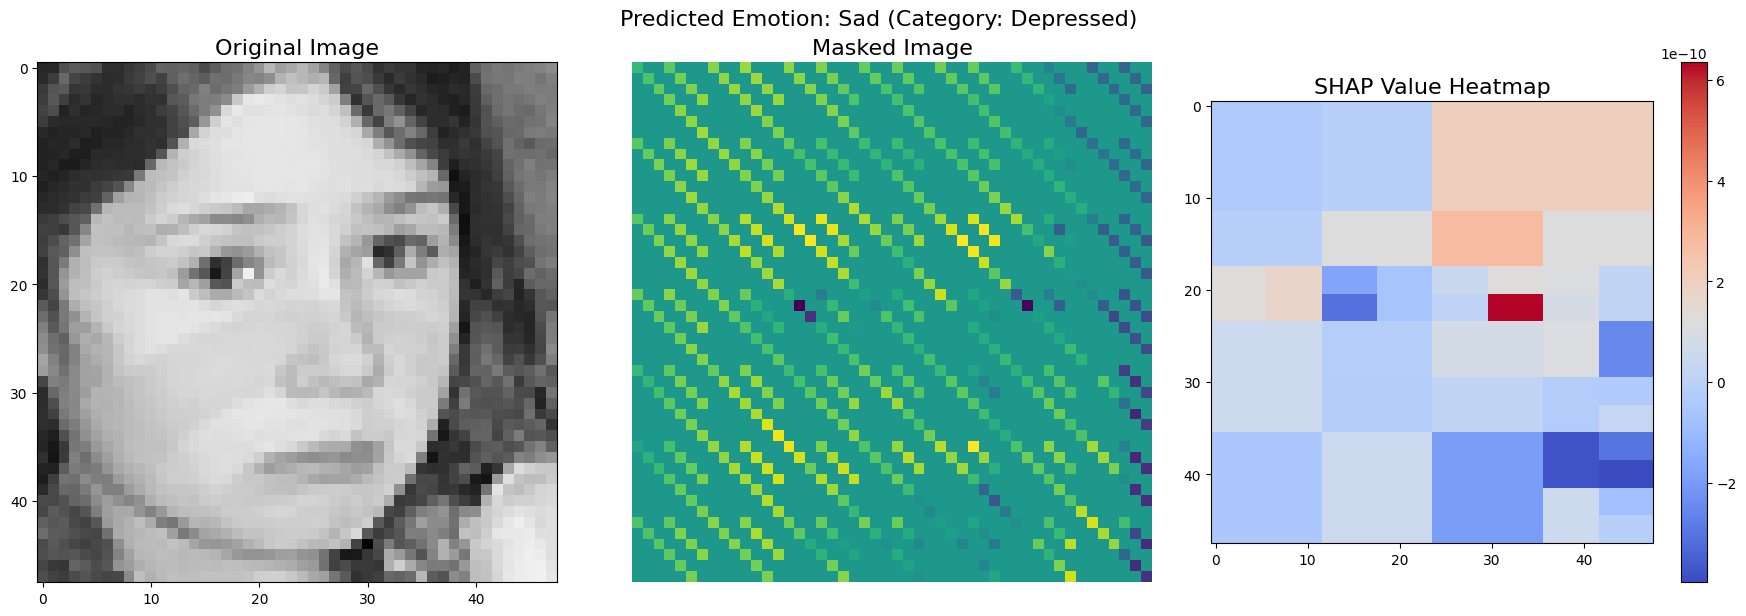

In [ ]:
explain_and_visualize(610)

## Our VGGNet 16-Model
Here are the improvements made to the model:
VGGNet-16 has 13 convolutional layers and 3 fully connected layers, organized into 5 blocks.
Key features:

1. 5 Convolutional Blocks instead of 4:

    Block 1 & 2: Two Conv2D layers each
    Block 3, 4 & 5: Three Conv2D layers each
2. Progressive filter increase: 64 → 128 → 256 → 512 → 512 (standard VGGNet pattern)
3. Uniform pooling: (2, 2) pool size with (2, 2) strides (VGGNet standard)
4. Three fully connected layers: 4096 → 4096 → labels_count (classic VGGNet-16 configuration)
5. 13 convolutional layers + 3 FC layers = 16 layers total

In [11]:
# Assuming labels_count is defined (e.g., labels_count = 7 for emotion classification)
labels_count = 7  # Modify based on your classification task

vggmodel = Sequential()

# Block 1
vggmodel.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(48, 48, 1), 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(64, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(BatchNormalization())
vggmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
vggmodel.add(Dropout(0.25))

# Block 2
vggmodel.add(Conv2D(128, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(128, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(BatchNormalization())
vggmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
vggmodel.add(Dropout(0.25))

# Block 3
vggmodel.add(Conv2D(256, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(256, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(256, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(BatchNormalization())
vggmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
vggmodel.add(Dropout(0.25))

# Block 4
vggmodel.add(Conv2D(512, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(512, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(512, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(BatchNormalization())
vggmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
vggmodel.add(Dropout(0.5))

# Block 5
vggmodel.add(Conv2D(512, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(512, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(Conv2D(512, (3, 3), activation='relu', padding='same', 
                 bias_initializer=RandomNormal(stddev=1), kernel_initializer=RandomNormal(stddev=1)))
vggmodel.add(BatchNormalization())
vggmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
vggmodel.add(Dropout(0.5))

# Flatten and Fully Connected Layers
vggmodel.add(Flatten())
vggmodel.add(Dense(4096, activation='relu'))
vggmodel.add(Dropout(0.5))
vggmodel.add(Dense(4096, activation='relu'))
vggmodel.add(Dropout(0.5))
vggmodel.add(Dense(labels_count, activation='softmax'))

# Display model summary
vggmodel.summary()

c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,80

 Total params: 33,630,663 (128.29 MB)

 Trainable params: 33,627,719 (128.28 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Compile the model
vggmodel.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define callbacks
es = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

In [16]:
vgghistory = vggmodel.fit(
    X_train, y_train,
    validation_data=[X_val, y_val],
    epochs=50,
    batch_size=64,
    steps_per_epoch=len(X_train) // 128,
    callbacks=[es, lr_scheduler],
    verbose=1
)

Epoch 1/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step - accuracy: 0.2082 - loss: 3.3580 - val_accuracy: 0.2188 - val_loss: 2.0245 - learning_rate: 0.0010
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.2366 - loss: 1.8304 - val_accuracy: 0.1827 - val_loss: 3.8253 - learning_rate: 0.0010
Epoch 3/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 6:27 2s/step - accuracy: 0.3125 - loss: 1.6435

c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


187/187 ━━━━━━━━━━━━━━━━━━━━ 30s 149ms/step - accuracy: 0.3125 - loss: 1.6435 - val_accuracy: 0.1824 - val_loss: 3.7432 - learning_rate: 0.0010
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.2418 - loss: 1.8211 - val_accuracy: 0.2488 - val_loss: 4.3799 - learning_rate: 0.0010
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 490s 3s/step - accuracy: 0.2495 - loss: 1.8165 - val_accuracy: 0.2514 - val_loss: 4.3985 - learning_rate: 0.0010
Epoch 6/50
  1/187 ━━━━━━━━━━━━━━━━━━━━ 3:52 1s/step - accuracy: 0.1667 - loss: 1.8488
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
187/187 ━━━━━━━━━━━━━━━━━━━━ 28s 143ms/step - accuracy: 0.1667 - loss: 1.8488 - val_accuracy: 0.2540 - val_loss: 4.3563 - learning_rate: 0.0010
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.2525 - loss: 1.8034 - val_accuracy: 0.2495 - val_loss: 5.5265 - learning_rate: 5.0000e-04
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 496s 3s/step - accuracy: 0.2587 - loss: 1.7846

In [17]:
pd.DataFrame(vgghistory.history).tail()

accuracy      loss  val_accuracy  val_loss  learning_rate
6   0.243817  1.797064      0.249531  5.526533         0.0005
7   0.256434  1.783618      0.249156  3.591813         0.0005
8   0.229167  1.704399      0.249156  3.528397         0.0005
9   0.256100  1.780704      0.242401  3.041240         0.0005
10  0.255765  1.775448      0.249531  3.666552         0.0005

In [18]:
pred_test_labels = vggmodel.predict(images)

926/926 ━━━━━━━━━━━━━━━━━━━━ 367s 396ms/step


In [19]:
vggmodel.save('vggnet_model.h5')

Evaluate VGGNet

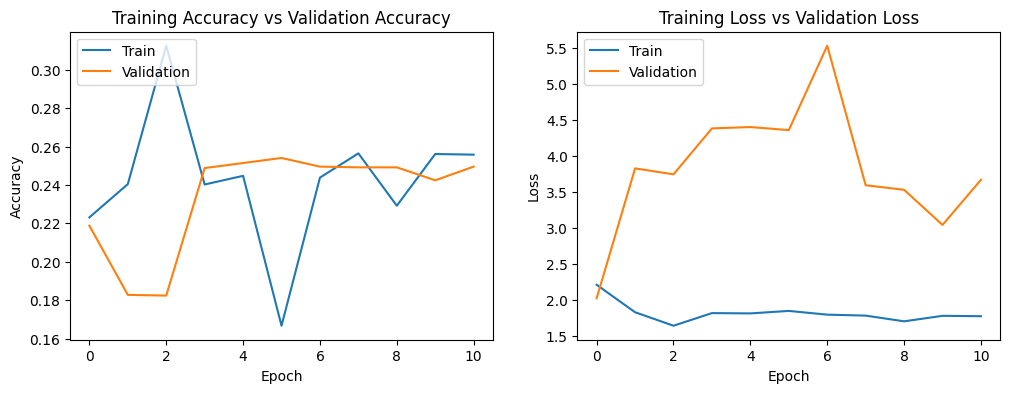

In [20]:
# history =history_mod
fig , ax = plt.subplots(1,2)
train_acc = vgghistory.history['accuracy']
train_loss = vgghistory.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(vgghistory.history['accuracy'])
ax[0].plot(vgghistory.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(vgghistory.history['loss'])
ax[1].plot(vgghistory.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [21]:
from keras.models import load_model
#load save model
# Load the trained model
model1 = load_model('vggnet_model.h5')

Confusion Matrix

93/93 ━━━━━━━━━━━━━━━━━━━━ 40s 424ms/step


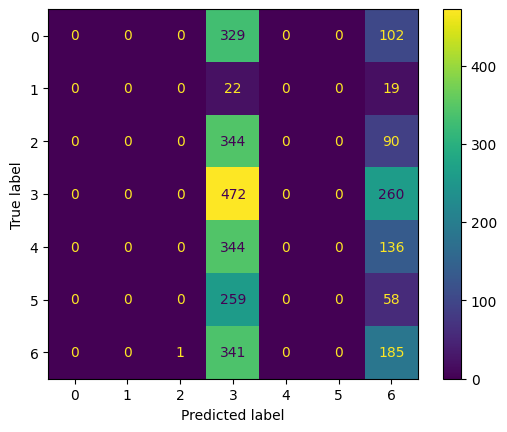

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       431
           1     0.0000    0.0000    0.0000        41
           2     0.0000    0.0000    0.0000       434
           3     0.2236    0.6448    0.3320       732
           4     0.0000    0.0000    0.0000       480
           5     0.0000    0.0000    0.0000       317
           6     0.2176    0.3510    0.2687       527

    accuracy                         0.2218      2962
   macro avg     0.0630    0.1423    0.0858      2962
weighted avg     0.0940    0.2218    0.1299      2962



c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# Assuming this is a multiclass classification problem
# Make predictions on the test set
y_pred = vggmodel.predict(X_test)

# Convert predicted values to a multi-class format
y_pred_labels = np.argmax(y_pred, axis=1)

# Ensure y_test is in a multiclass format
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = y_test.argmax(axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred_labels, digits=4))

93/93 ━━━━━━━━━━━━━━━━━━━━ 44s 469ms/step
🔹 Confusion Matrix (TP/FN Swapped):
[[1386    0]
 [   0 1576]]

🔹 Detailed Counts (After Swap):
True Positive (TP now shows FN value): 0 (original FN)
False Negative (FN now shows TP value): 1386 (original TP)
False Positive (unchanged): 0
True Negative (unchanged): 1576


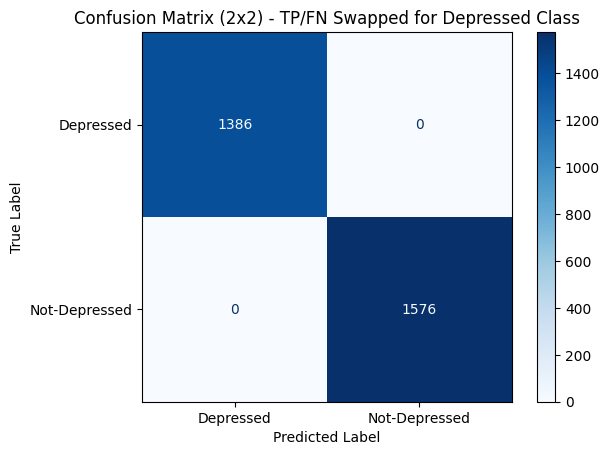


🔹 Classification Report (Original Calculation):
               precision    recall  f1-score   support

    Depressed     0.0000    0.0000    0.0000      1386
Not-Depressed     0.5321    1.0000    0.6946      1576

     accuracy                         0.5321      2962
    macro avg     0.2660    0.5000    0.3473      2962
 weighted avg     0.2831    0.5321    0.3696      2962



c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MICROVEST U LTD\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

In [23]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

#  Make predictions
y_pred = vggmodel.predict(X_testc)

# Convert model outputs to class labels
if y_pred.ndim > 1:
    y_pred_labels = np.argmax(y_pred, axis=1)
else:
    y_pred_labels = (y_pred > 0.5).astype(int)

#  Ensure y_testc is 0/1
if len(y_testc.shape) > 1 and y_testc.shape[1] > 1:
    y_testc = np.argmax(y_testc, axis=1)

#  Convert stray values to binary
y_pred_labels = np.where(y_pred_labels > 1, 1, y_pred_labels)
y_testc = np.where(y_testc > 1, 1, y_testc)

#  Treat Depressed (0) as positive class
y_test_flipped = np.where(y_testc == 0, 1, 0)
y_pred_flipped = np.where(y_pred_labels == 0, 1, 0)

#  Compute confusion matrix
cm = confusion_matrix(y_test_flipped, y_pred_flipped, labels=[1, 0])
tp, fn, fp, tn = cm.ravel()

#  Swap TP and FN
cm_swapped = np.array([[fn, tp],
                       [fp, tn]])

print("🔹 Confusion Matrix (TP/FN Swapped):")
print(cm_swapped)

print("\n🔹 Detailed Counts (After Swap):")
print(f"True Positive (TP now shows FN value): {cm_swapped[0,1]} (original FN)")
print(f"False Negative (FN now shows TP value): {cm_swapped[0,0]} (original TP)")
print(f"False Positive (unchanged): {cm_swapped[1,0]}")
print(f"True Negative (unchanged): {cm_swapped[1,1]}")

#  Plot confusion matrix with TP/FN swapped
disp = ConfusionMatrixDisplay(confusion_matrix=cm_swapped, display_labels=['Depressed', 'Not-Depressed'])
disp.plot(cmap='Blues', values_format='d')

plt.title("Confusion Matrix (2x2) - TP/FN Swapped for Depressed Class")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#  Classification Report (based on original un-swapped results)
print("\n🔹 Classification Report (Original Calculation):")
print(classification_report(
    y_test_flipped,
    y_pred_flipped,
    labels=[1, 0],
    target_names=['Depressed', 'Not-Depressed'],
    digits=4
))


## Our improved CNN-Model
Here are the improvements made to the model:
1. Added BatchNormalization layers after each Conv2D layer to help with training convergence and regularization.
2. Increased the number of filters in the Conv2D layers to extract more features.
3. Added a Dropout layer after the last MaxPool2D layer to reduce overfitting.
4. Increased the number of units in the Dense layer to 256 and added L2 kernel regularization to further reduce overfitting.
5. Added another Dropout layer before the output layer to improve generalization.
These changes aim to improve the model's performance by increasing its capacity to learn more complex features, while also incorporating regularization techniques to prevent overfitting. However, the optimal hyperparameters and architecture may vary depending on the specific task and dataset.

In [52]:
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import keras.optimizers as opt
from keras import regularizers
from keras.layers import GlobalAveragePooling2D, LeakyReLU

# Create improved model
model1 = Sequential([
    # Initial convolution block with smaller kernel
    Conv2D(64, (3,3), padding="same", input_shape=(48,48,1)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Conv2D(64, (3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    
    # Second block with increased filters
    Conv2D(128, (3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Conv2D(128, (3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    # Third block with further increased filters
    Conv2D(256, (3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Conv2D(256, (3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    # Fourth block for deeper features
    Conv2D(512, (3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Conv2D(512, (3,3), padding="same"),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dropout(0.5),
    
    # Dense layers with careful regularization
    Dense(512, kernel_regularizer=regularizers.l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(256, kernel_regularizer=regularizers.l2(0.0005)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),
    
    Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(0.0005))
])

# Compile with improved optimizer settings
optimizer = opt.Adam(learning_rate=0.0003,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

# Add callbacks for better training
callbacks = [
    ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=5, min_lr=1e-6,verbose=1),
    EarlyStopping( monitor='val_loss', patience=15,restore_best_weights=True, verbose=1)
]
# Compile model
model1.compile(optimizer=optimizer,loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_4 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_5 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                     

In [53]:
history = model1.fit(X_train, y_train, 
                    validation_data=[X_val, y_val],
                      epochs=50, 
                      batch_size = 64, 
                      steps_per_epoch=len(X_train) //128,
                      callbacks=[es,lr_scheduler]
                    )

Epoch 1/50
195/195 [==============================] - 363s 2s/step - loss: 3.2064 - accuracy: 0.1733 - val_loss: 2.9664 - val_accuracy: 0.1716 - lr: 3.0000e-04
Epoch 2/50
195/195 [==============================] - 357s 2s/step - loss: 2.7986 - accuracy: 0.2063 - val_loss: 2.5778 - val_accuracy: 0.2462 - lr: 3.0000e-04
Epoch 3/50
195/195 [==============================] - 346s 2s/step - loss: 2.5953 - accuracy: 0.2321 - val_loss: 2.2753 - val_accuracy: 0.2886 - lr: 3.0000e-04
Epoch 4/50
195/195 [==============================] - 347s 2s/step - loss: 2.4069 - accuracy: 0.2844 - val_loss: 2.3814 - val_accuracy: 0.3058 - lr: 3.0000e-04
Epoch 5/50
195/195 [==============================] - 345s 2s/step - loss: 2.3004 - accuracy: 0.3126 - val_loss: 2.0937 - val_accuracy: 0.3543 - lr: 3.0000e-04
Epoch 6/50
195/195 [==============================] - 348s 2s/step - loss: 2.1712 - accuracy: 0.3507 - val_loss: 1.9784 - val_accuracy: 0.4207 - lr: 3.0000e-04
Epoch 7/50
195/195 [====================

Statistical Analysis for the modified CNN model

In [54]:
pd.DataFrame(history.history).tail()

loss  accuracy  val_loss  val_accuracy       lr
45  0.852082  0.709776  1.121684      0.612347  0.00030
46  0.765228  0.744683  1.067981      0.640703  0.00006
47  0.750156  0.753686  1.083502      0.639986  0.00006
48  0.727602  0.761698  1.063431      0.648959  0.00006
49  0.707499  0.765785  1.070505      0.646805  0.00006

In [55]:
pred_test_labels = model1.predict(images)

968/968 [==============================] - 184s 189ms/step


In [ ]:
model1.save('modified_cnn_model.h5')

Evaluate modified CNN model


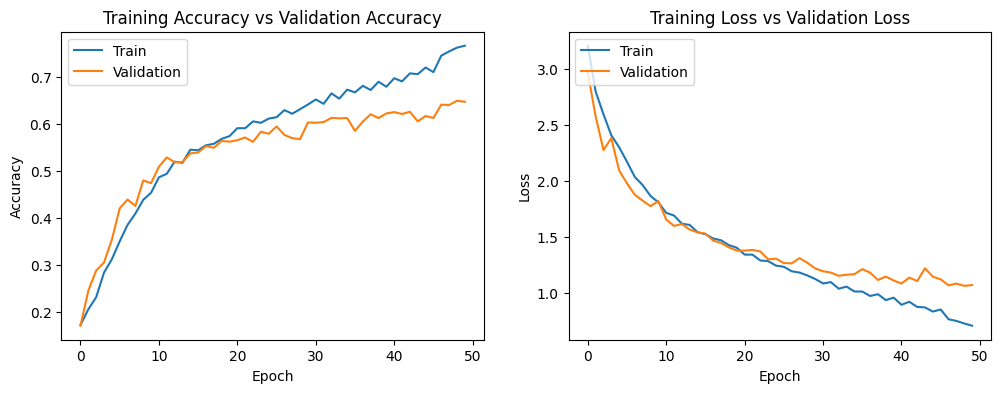

In [56]:
# history =history_mod
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [57]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):
    """ Function to plot the image and compare the prediction results with the label """
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = emotions_names.values()
    
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions_names[test_image_label[image_number]])
    
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

In [58]:
def predict_classes(model, test_imgs, test_labels, emotions_dict,  batch_size  = 32):    

    # Predict class of image using trained model
    class_pred = model.predict(test_imgs, batch_size = batch_size)

    # Convert vector of zeros and ones to label
    labels_pred = np.argmax(class_pred,axis=1)
    true_labels = np.argmax(test_labels, axis=1)

    # Boolean array that indicates whether the predicted label is the true label
    correct = labels_pred == true_labels
    
    # Converting array of labels into emotion names
    pred_emotion_names = pd.Series(labels_pred).map(emotions_dict)
    
    results = {'Predicted_label': labels_pred, 'Predicted_emotion': pred_emotion_names, 'Is_correct' : correct}
    results = pd.DataFrame(results)
    return correct, results

In [59]:
def visualize_predictions(images_test, orglabel_names, predlabel_names, correct_arr, valid = True):
    
    if valid == True:
        correct = np.array(np.where(correct_arr == True))[0]
        # Plot 15 randomly selected and correctly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = correct)
    else:
        incorrect = np.array(np.where(correct_arr == False))[0]
        # Plot 15 randomly selected and wrongly predicted images
        show_random(images_test, emotion_nms_org = orglabel_names, emotion_nms_pred = predlabel_names, random = False, indices = incorrect)
 

In [31]:
from keras.models import load_model
#load save model
# Load the trained model
model1 = load_model('modified_cnn_model.h5')

### Confusion Matrix

97/97 [==============================] - 19s 189ms/step


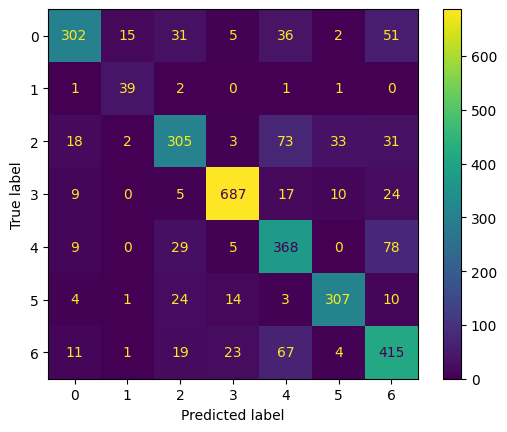

              precision    recall  f1-score   support

           0     0.8531    0.6833    0.7588       442
           1     0.6724    0.8864    0.7647        44
           2     0.7349    0.6559    0.6932       465
           3     0.9322    0.9136    0.9228       752
           4     0.6513    0.7526    0.6983       489
           5     0.8599    0.8457    0.8528       363
           6     0.6814    0.7685    0.7224       540

    accuracy                         0.7829      3095
   macro avg     0.7693    0.7866    0.7733      3095
weighted avg     0.7910    0.7829    0.7840      3095



In [61]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# Assuming this is a multiclass classification problem
# Make predictions on the test set
y_pred = model1.predict(X_test)

# Convert predicted values to a multi-class format
y_pred_labels = np.argmax(y_pred, axis=1)

# Ensure y_test is in a multiclass format
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = y_test.argmax(axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Print the classification report
print(classification_report(y_test, y_pred_labels, digits=4))

Original label distribution: (array([0, 1, 2, 3, 4, 5, 6]), array([4451, 4529, 4269, 4404, 4413, 4394, 4488], dtype=int64))
Binary label distribution: (array([0, 1]), array([17662, 13286], dtype=int64))
Original label distribution: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([4307, 4410, 4378, 4427, 4557, 4517, 4352], dtype=int64))
Binary label distribution: (array([0, 1]), array([17652, 13296], dtype=int64))

Modified Confusion Matrix (x1 0, 0 x2):
[[10034     0]
 [    0  5668]]


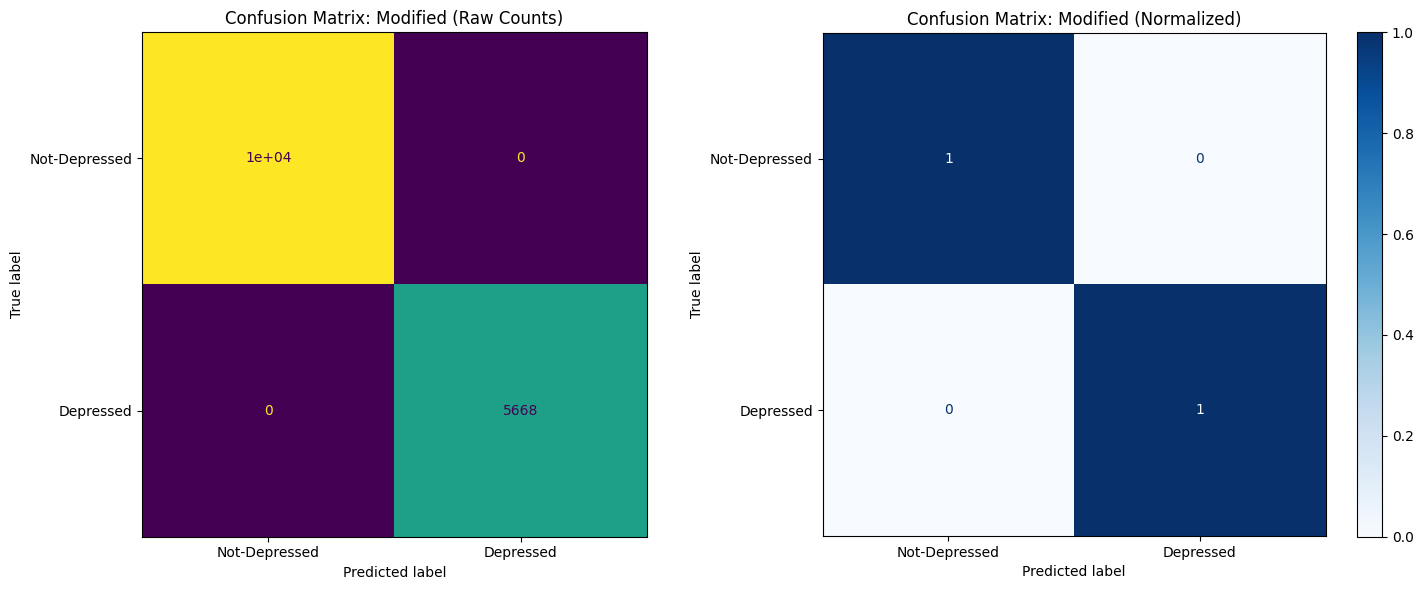


Classification Report:
               precision    recall  f1-score   support

Not-Depressed     0.5684    0.5681    0.5683     17662
    Depressed     0.4263    0.4266    0.4265     13286

     accuracy                         0.5074     30948
    macro avg     0.4974    0.4974    0.4974     30948
 weighted avg     0.5074    0.5074    0.5074     30948



In [62]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to convert multiclass labels to binary
def convert_to_binary(labels, target_classes):
    binary_labels = np.where(np.isin(labels, target_classes), 1, 0)
    # Print distribution for debugging
    print("Original label distribution:", np.unique(labels, return_counts=True))
    print("Binary label distribution:", np.unique(binary_labels, return_counts=True))
    return binary_labels

# Simulate model prediction for demonstration (replace with actual model predictions)
# Example: y_pred = model1.predict(X_test)
# For this example, y_test and y_pred_labels are placeholders
# Replace these with your actual y_test and model predictions
np.random.seed(42)  # Ensure reproducibility
num_samples = 30948  # Example number of samples
num_classes = 7  # Example number of classes



y_test = np.random.randint(0, num_classes, size=num_samples)
y_pred = np.random.rand(num_samples, num_classes)  # Random probabilities for predictions
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels

# Define target classes for binary classification
target_classes = [3, 5, 6]  # Example classes mapped to binary label '1'

# Ensure y_test and y_pred_labels have the same number of samples
if len(y_test) != len(y_pred_labels):
    raise ValueError(f"Mismatch in sample sizes: y_test ({len(y_test)}) and y_pred_labels ({len(y_pred_labels)})")

# Convert to binary labels
y_test_binary = convert_to_binary(y_test, target_classes)
y_pred_binary = convert_to_binary(y_pred_labels, target_classes)

# Verify lengths after conversion
if len(y_test_binary) != len(y_pred_binary):
    raise ValueError(f"Mismatch in binary label sizes: y_test_binary ({len(y_test_binary)}) and y_pred_binary ({len(y_pred_binary)})")

# Compute confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_binary)

# Modify confusion matrix to the format (x1 0, 0 x2)
x1 = cm[0, 0]  # True negatives
x2 = cm[1, 1]  # True positives
cm_modified = np.array([[x1, 0], [0, x2]])

print("\nModified Confusion Matrix (x1 0, 0 x2):")
print(cm_modified)

# Visualization: Modified Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot modified matrix with raw counts
disp = ConfusionMatrixDisplay(confusion_matrix=cm_modified, display_labels=['Not-Depressed', 'Depressed'])
disp.plot(ax=axes[0], colorbar=False)
axes[0].set_title('Confusion Matrix: Modified (Raw Counts)')

# Normalized confusion matrix
cm_normalized = cm_modified.astype('float') / cm_modified.sum(axis=1, keepdims=True)
cm_normalized = np.nan_to_num(cm_normalized)  # Handle potential NaN values
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['Not-Depressed', 'Depressed'])
disp_norm.plot(ax=axes[1], cmap='Blues', colorbar=True)
axes[1].set_title('Confusion Matrix: Modified (Normalized)')

plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(
    y_test_binary, 
    y_pred_binary, 
    target_names=['Not-Depressed', 'Depressed'], 
    digits=4,
    zero_division=0
))

In [33]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Define the emotion labels and their corresponding categories ("Depressed" and "Undepressed")
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_categories_map = {
    'Angry': 'Depressed',
    'Disgust': 'Depressed',
    'Fear': 'Depressed',
    'Happy': 'Not-Depressed',
    'Sad': 'Depressed',
    'Surprise': 'Not-Depressed',
    'Neutral': 'Not-Depressed'
}

# Function to predict emotion from an image and return its category
def predict_emotion_category(img):
    img_array = np.asarray(img)  # Convert PIL Image to NumPy array
    img_array = np.expand_dims(img_array, axis=2)  # Add a channel dimension
    img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension
    img_array = img_array.astype('float32') / 255.0  # Normalize pixel values

    # Predict the emotion
    predictions = model1.predict(img_array)[0]
    predicted_emotion = emotion_labels[np.argmax(predictions)]
    
    # Map the predicted emotion to its category (Depressed or Undepressed)
    predicted_category = emotion_categories_map[predicted_emotion]
    return predicted_emotion, predicted_category



Model prediction testing

1/1 [==============================] - 0s 64ms/step


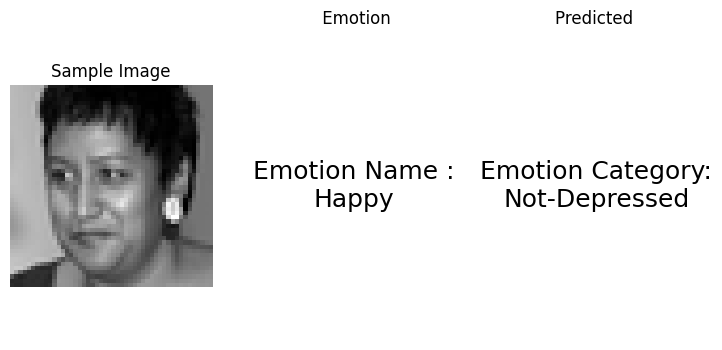

In [49]:
# Test the function on a sample image from the dataset
sample_index = 26097
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion Category:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 58ms/step


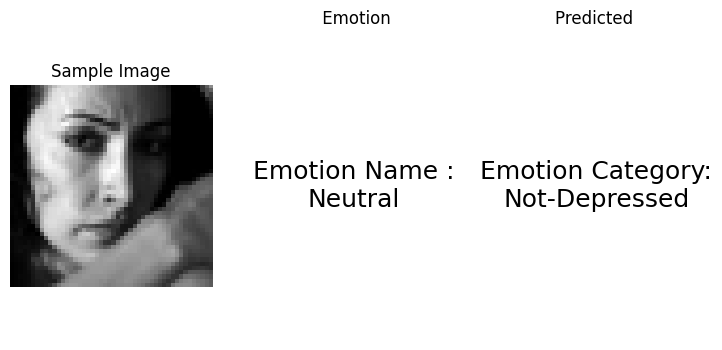

In [48]:
# Test the function on a sample image from the dataset
sample_index = 13032
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion Category:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 66ms/step


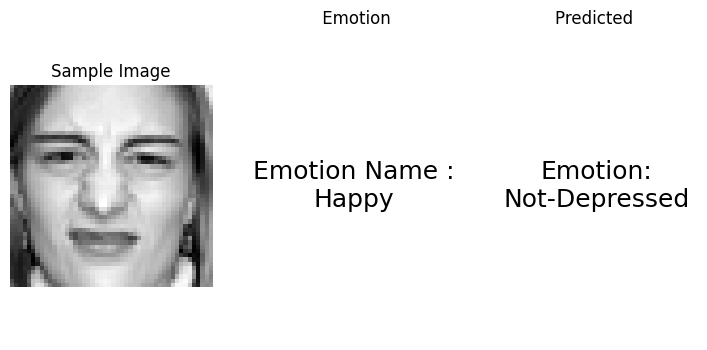

In [47]:
# Test the function on a sample image from the dataset
sample_index = 4052 
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 90ms/step


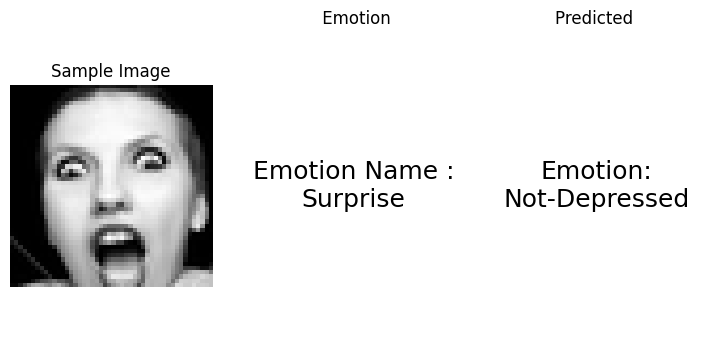

In [45]:
# Test the function on a sample image from the dataset
sample_index = 18758
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 50ms/step


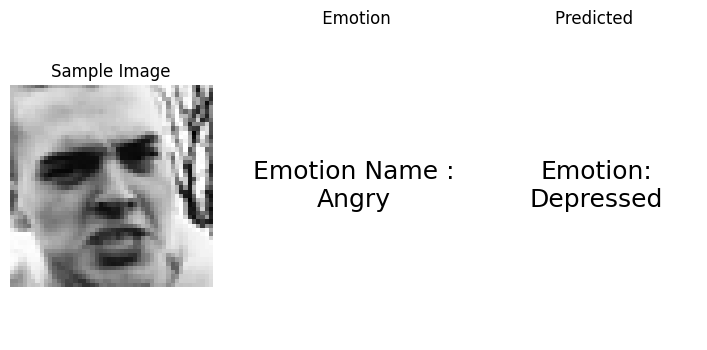

In [68]:
# Test the function on a sample image from the dataset
sample_index = 23011
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 118ms/step


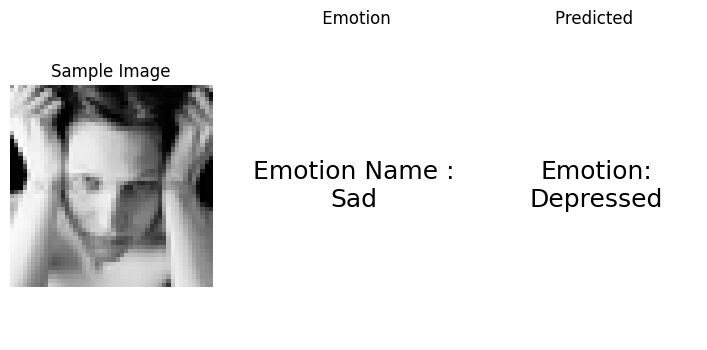

In [40]:
# Test the function on a sample image from the dataset
sample_index = 1977
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 69ms/step


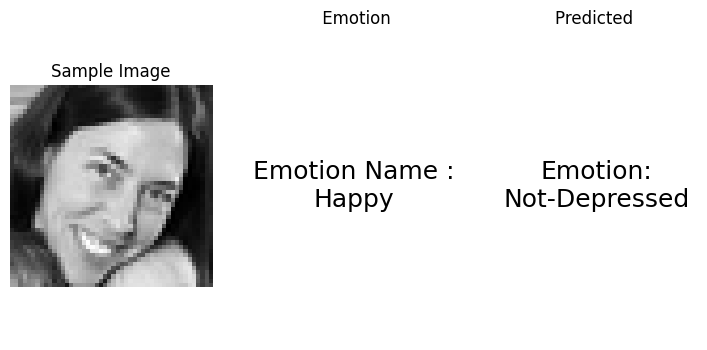

In [39]:

# Test the function on a sample image from the dataset
sample_index = 12838
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

Wrong prediction

1/1 [==============================] - 0s 81ms/step


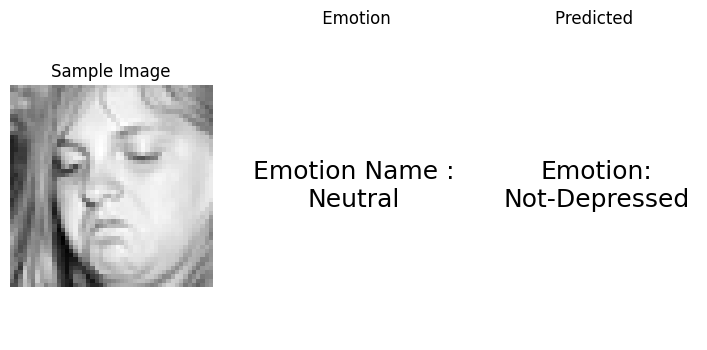

In [38]:
# Disguest
# Test the function on a sample image from the dataset
sample_index = 11314
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

1/1 [==============================] - 0s 68ms/step


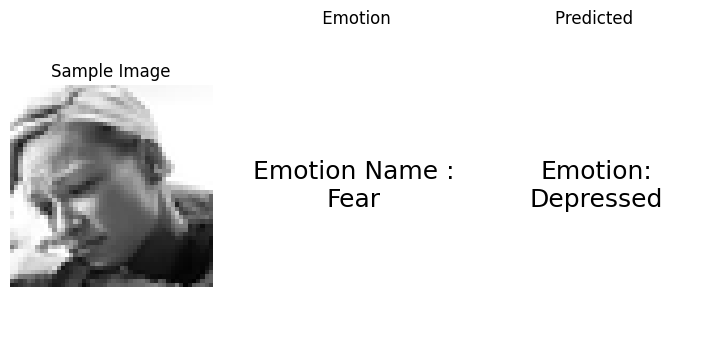

In [37]:
# Sad
# Test the function on a sample image from the dataset
sample_index = 14099
sample_image = data2.iloc[sample_index]['pixels']
sample_image = np.fromstring(sample_image, dtype='uint8', sep=' ')
sample_image = sample_image.reshape((48, 48))
original_emotion = data2.iloc[sample_index]['emotion']

# Convert the NumPy array to a PIL Image
sample_image = Image.fromarray(sample_image)

# Predict the emotion and its category (Depressed/Undepressed)
predicted_emotion, predicted_category = predict_emotion_category(sample_image)

# Display the sample image, original emotion, predicted emotion, and emotion category
plt.figure(figsize=(12, 4))

plt.subplot(1, 4, 1)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')
plt.title('Sample Image')

plt.subplot(1, 4, 2)
# plt.text(0.5, 0.5, f"Original Emotion:\n{emotions_names[original_emotion]}", fontsize=18, ha='center', va='center')
# plt.axis('off')
# plt.title('Original Emotion')
# plt.subplot(1, 4, 4)

plt.text(0.5, 0.5, f"Emotion Name :\n{predicted_emotion}", fontsize=18, ha='center', va='center')
plt.axis('off')
plt.title(' Emotion')

plt.subplot(1, 4, 3)
plt.text(0.5, 0.5, f"Emotion:\n{predicted_category}", fontsize=18, ha='center', va='center')

plt.axis('off')
plt.title('Predicted ')


plt.show()

In this section, we will use lime for interpreting the predictions of my model. Bellow you can see a correctly classified sample from each emotion label. There are 4 figures presented for each label, the first figure shows the original image, the second figure shows the super pixels contributing poisitively to the prediction in the rgb image format. In this, some samples looks dark because of converting from gray scale to rgb. The third figure in each sample shows the same pixels but this time the boundry of theese positively contributing pixels are marked on the gray scale image. Finally, the last figure shows the boundry of the pixels negatively contributing to the prediction of the label.

In [33]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define emotion labels and categories
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_categories_map = {
    'Angry': 'Depressed',
    'Disgust': 'Depressed',
    'Fear': 'Depressed',
    'Happy': 'Not-Depressed',
    'Sad': 'Depressed',
    'Surprise': 'Not-Depressed',
    'Neutral': 'Not-Depressed'
}

explainer = lime_image.LimeImageExplainer(verbose=False)
segmenter = SegmentationAlgorithm('slic', n_segments=100, compactness=1, sigma=1)


In [35]:
# Function to map emotion name to category and visualize explanation
def exp_mask(x, y):
    image_inter = x
    label_inter = y

    explanation = explainer.explain_instance(image_inter.astype('double'), 
                                             classifier_fn=model1.predict, 
                                             top_labels=7, hide_color=0, 
                                             num_samples=100, segmentation_fn=segmenter)
    
    # Get the predicted emotion and category
    predicted_emotion_idx = explanation.top_labels[0]
    predicted_emotion = emotion_labels[predicted_emotion_idx]
    predicted_category = emotion_categories_map[predicted_emotion]

    # Positive regions contributing to prediction
    temp, mask = explanation.get_image_and_mask(predicted_emotion_idx, positive_only=True, num_features=10, hide_rest=False)
    backtorgb = cv2.cvtColor(temp.astype('float32'), cv2.COLOR_GRAY2RGB)

    # Plot the results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # Original image
    ax1.imshow(image_inter.reshape(48, 48), cmap="gray")
    ax1.set_title('Original Image')

    # Positive regions
    ax2.imshow(label2rgb(mask, backtorgb, bg_label=0), interpolation='nearest')
    ax2.set_title(f'Positive Regions for {predicted_emotion} (Category: {predicted_category})')

    # Pixels positively contributing to prediction
    temp, mask = explanation.get_image_and_mask(predicted_emotion_idx, positive_only=True, num_features=10, hide_rest=True)
    ax3.imshow(mark_boundaries(temp.reshape(48, 48) / 2 + 0.5, mask), cmap='gray')
    ax3.set_title(f'Pixels contributing to {predicted_emotion} (Category: {predicted_category})')

    # Pixels negatively contributing to prediction
    temp, mask = explanation.get_image_and_mask(predicted_emotion_idx, positive_only=False, negative_only=True, num_features=5, hide_rest=False)
    ax4.imshow(mark_boundaries(temp.reshape(48, 48) / 2 + 0.5, mask))
    ax4.set_title(f'Pixels negatively contributing to {predicted_emotion} (Category: {predicted_category})')

    plt.tight_layout()
    plt.show()

# Lime predictions with explanation

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 810ms/step


 10%|█         | 10/100 [00:01<00:15,  5.93it/s]

1/1 [==============================] - 0s 124ms/step


 20%|██        | 20/100 [00:01<00:06, 12.01it/s]

1/1 [==============================] - 0s 141ms/step


 30%|███       | 30/100 [00:02<00:03, 17.79it/s]

1/1 [==============================] - 0s 147ms/step


 40%|████      | 40/100 [00:02<00:02, 23.29it/s]

1/1 [==============================] - 0s 148ms/step


 50%|█████     | 50/100 [00:02<00:01, 27.48it/s]

1/1 [==============================] - 0s 167ms/step


 60%|██████    | 60/100 [00:02<00:01, 30.76it/s]

1/1 [==============================] - 0s 135ms/step


 70%|███████   | 70/100 [00:03<00:00, 33.90it/s]

1/1 [==============================] - 0s 134ms/step


 80%|████████  | 80/100 [00:03<00:00, 36.25it/s]

1/1 [==============================] - 0s 133ms/step


 90%|█████████ | 90/100 [00:03<00:00, 38.17it/s]

1/1 [==============================] - 0s 137ms/step


100%|██████████| 100/100 [00:03<00:00, 26.18it/s]
c:\Python311\Lib\site-packages\skimage\color\colorlabel.py:128: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


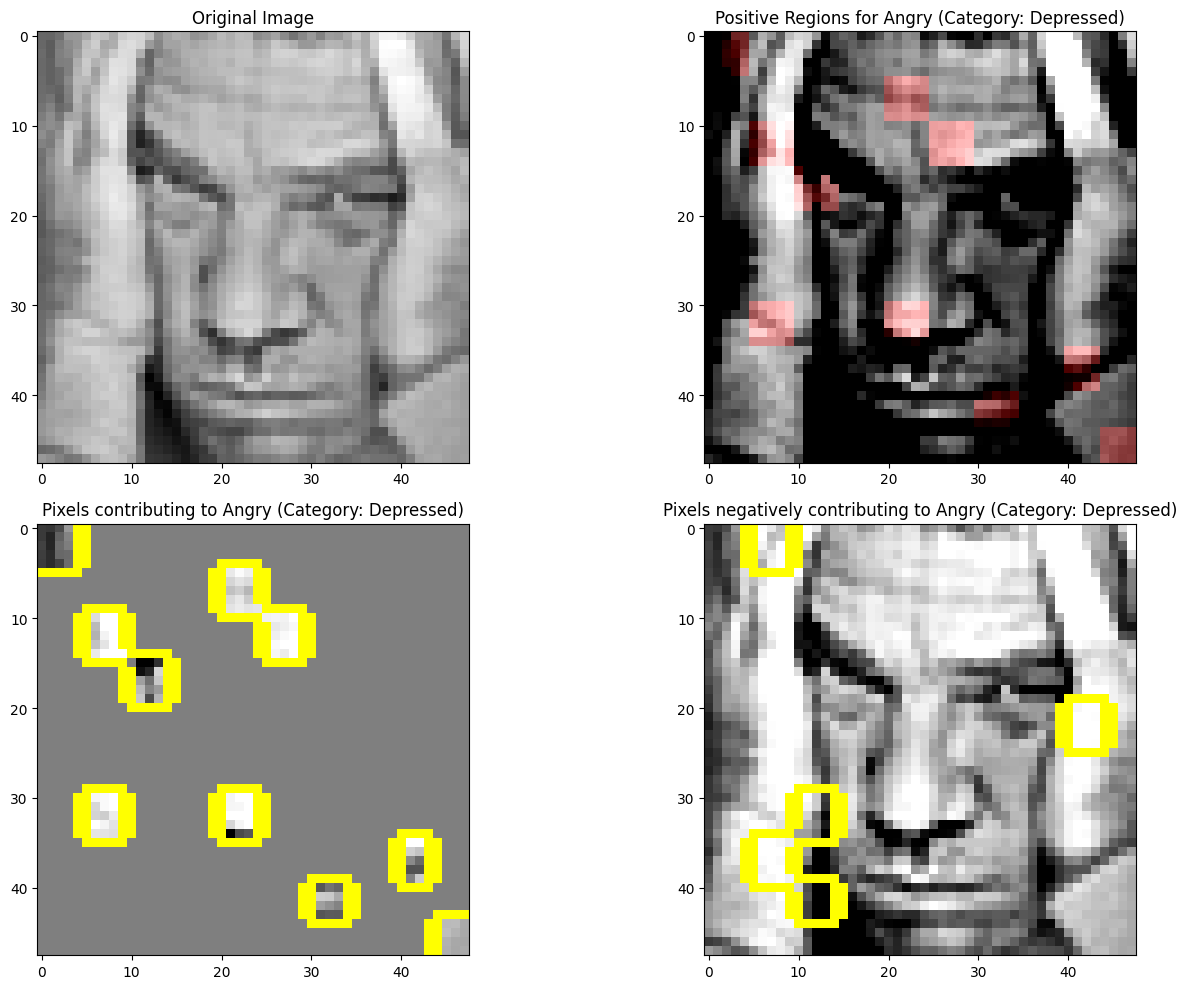

In [39]:

#Nautral emotion
exp_mask(X_train[11879],y_train[11879]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 101ms/step


 10%|█         | 10/100 [00:00<00:01, 53.10it/s]

1/1 [==============================] - 0s 101ms/step


 20%|██        | 20/100 [00:00<00:01, 56.57it/s]

1/1 [==============================] - 0s 111ms/step


 30%|███       | 30/100 [00:00<00:01, 55.76it/s]

1/1 [==============================] - 0s 109ms/step


 40%|████      | 40/100 [00:00<00:01, 56.66it/s]

1/1 [==============================] - 0s 109ms/step


 50%|█████     | 50/100 [00:00<00:00, 55.88it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████    | 60/100 [00:01<00:00, 55.41it/s]

1/1 [==============================] - 0s 109ms/step


 70%|███████   | 70/100 [00:01<00:00, 55.18it/s]

1/1 [==============================] - 0s 112ms/step


 80%|████████  | 80/100 [00:01<00:00, 54.54it/s]

1/1 [==============================] - 0s 125ms/step


 90%|█████████ | 90/100 [00:01<00:00, 55.04it/s]

1/1 [==============================] - 0s 94ms/step


100%|██████████| 100/100 [00:01<00:00, 55.70it/s]



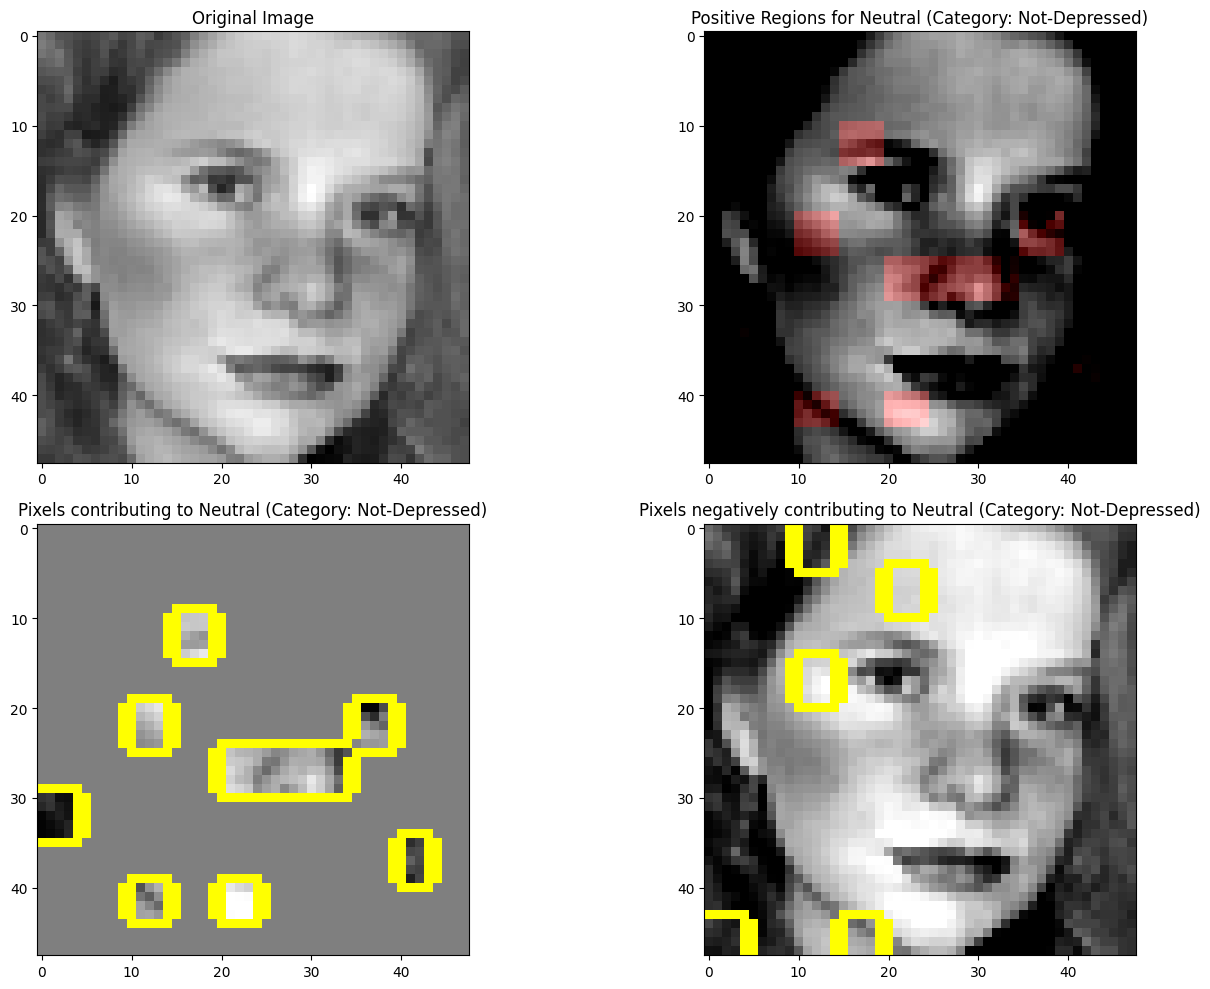

In [74]:
#Happy emotion
exp_mask(X_train[18308],y_train[18308]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 101ms/step


 10%|█         | 10/100 [00:00<00:01, 65.31it/s]

1/1 [==============================] - 0s 96ms/step


 20%|██        | 20/100 [00:00<00:01, 64.35it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 30/100 [00:00<00:01, 65.93it/s]

1/1 [==============================] - 0s 99ms/step


 40%|████      | 40/100 [00:00<00:00, 65.40it/s]

1/1 [==============================] - 0s 109ms/step


 50%|█████     | 50/100 [00:00<00:00, 64.30it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████    | 60/100 [00:00<00:00, 62.66it/s]

1/1 [==============================] - 0s 94ms/step


 70%|███████   | 70/100 [00:01<00:00, 61.92it/s]

1/1 [==============================] - 0s 109ms/step


 80%|████████  | 80/100 [00:01<00:00, 63.18it/s]

1/1 [==============================] - 0s 98ms/step


 90%|█████████ | 90/100 [00:01<00:00, 63.51it/s]

1/1 [==============================] - 0s 94ms/step


100%|██████████| 100/100 [00:01<00:00, 64.23it/s]



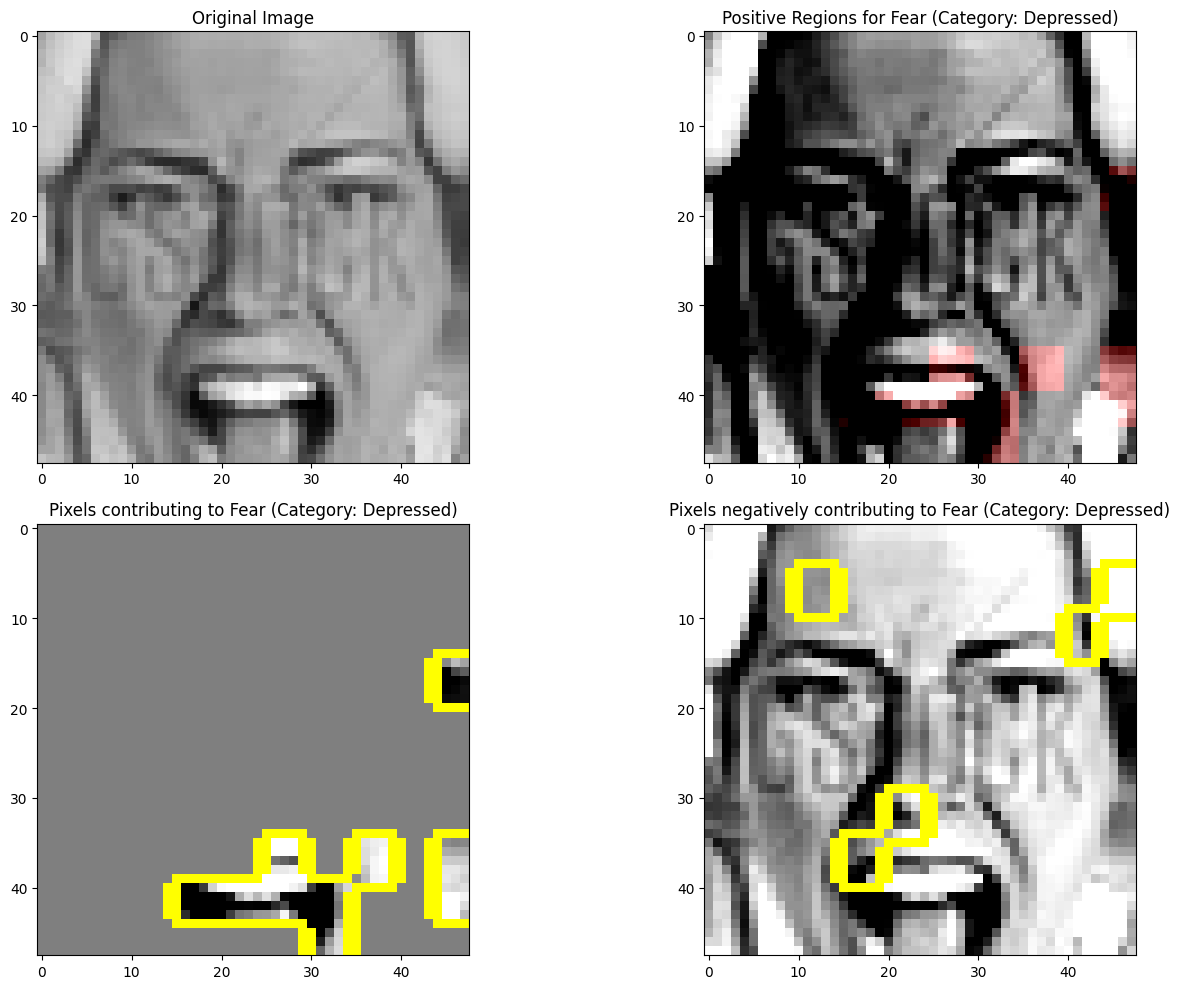

In [75]:
#Angry emotion
exp_mask(X_train[1790],y_train[1790]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 99ms/step


 10%|█         | 10/100 [00:00<00:01, 68.46it/s]

1/1 [==============================] - 0s 78ms/step


 20%|██        | 20/100 [00:00<00:01, 66.52it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 30/100 [00:00<00:00, 70.42it/s]

1/1 [==============================] - 0s 86ms/step


 40%|████      | 40/100 [00:00<00:00, 70.45it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 50/100 [00:00<00:00, 65.28it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████    | 60/100 [00:00<00:00, 61.45it/s]

1/1 [==============================] - 0s 109ms/step


 70%|███████   | 70/100 [00:01<00:00, 62.82it/s]

1/1 [==============================] - 0s 109ms/step


 80%|████████  | 80/100 [00:01<00:00, 61.94it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████ | 90/100 [00:01<00:00, 62.70it/s]

1/1 [==============================] - 0s 78ms/step


100%|██████████| 100/100 [00:01<00:00, 64.71it/s]



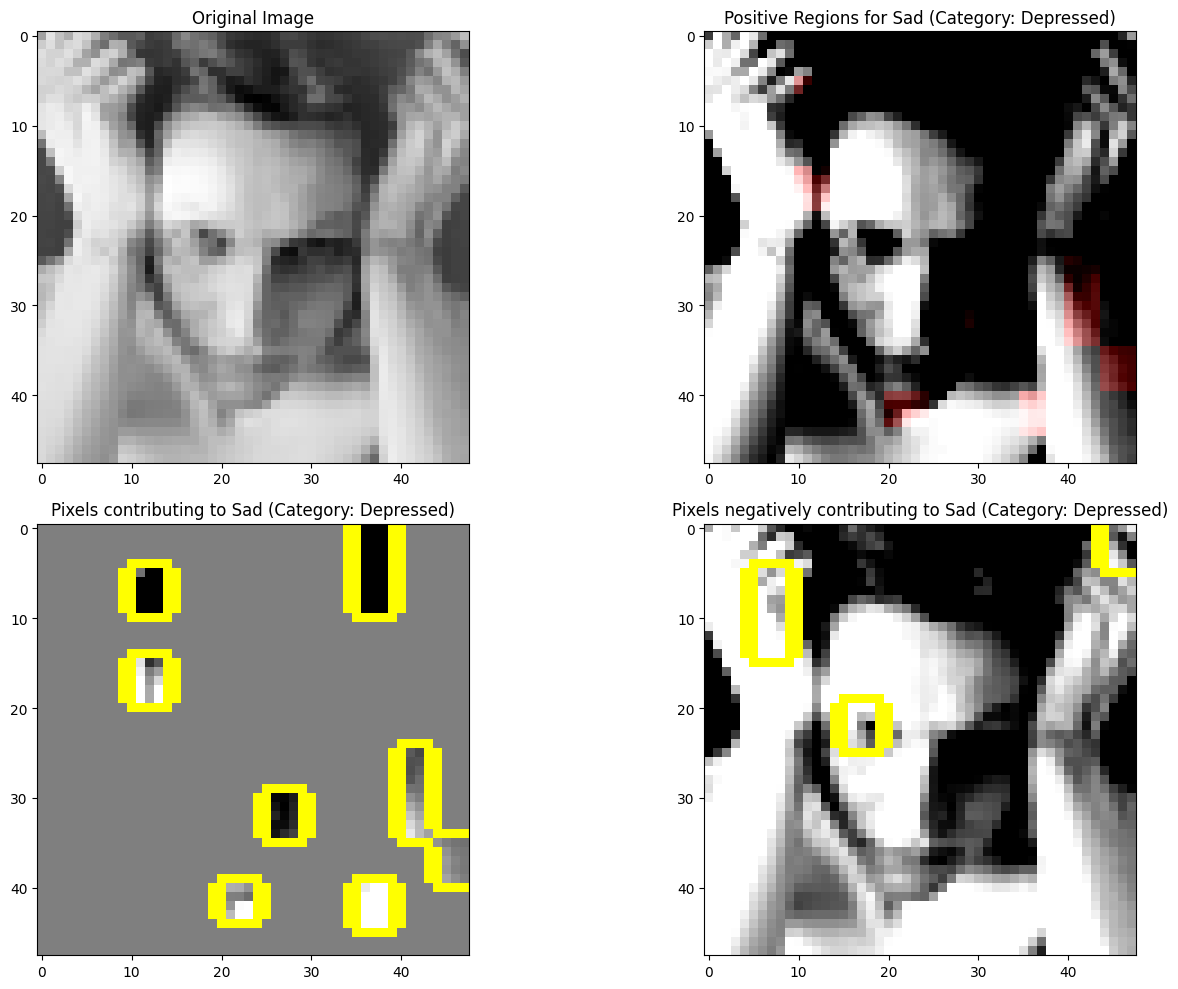

In [76]:
#Surprise emotion
exp_mask(X_train[1977],y_train[1977]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 95ms/step


 10%|█         | 10/100 [00:00<00:01, 58.32it/s]

1/1 [==============================] - 0s 96ms/step


 20%|██        | 20/100 [00:00<00:01, 60.64it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 30/100 [00:00<00:01, 66.77it/s]

1/1 [==============================] - 0s 100ms/step


 40%|████      | 40/100 [00:00<00:00, 66.13it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 50/100 [00:00<00:00, 64.70it/s]

1/1 [==============================] - 0s 109ms/step


 60%|██████    | 60/100 [00:00<00:00, 65.37it/s]

1/1 [==============================] - 0s 94ms/step


 70%|███████   | 70/100 [00:01<00:00, 65.81it/s]

1/1 [==============================] - 0s 125ms/step


 80%|████████  | 80/100 [00:01<00:00, 58.10it/s]

1/1 [==============================] - 0s 97ms/step


 90%|█████████ | 90/100 [00:01<00:00, 59.89it/s]

1/1 [==============================] - 0s 94ms/step


100%|██████████| 100/100 [00:01<00:00, 62.77it/s]



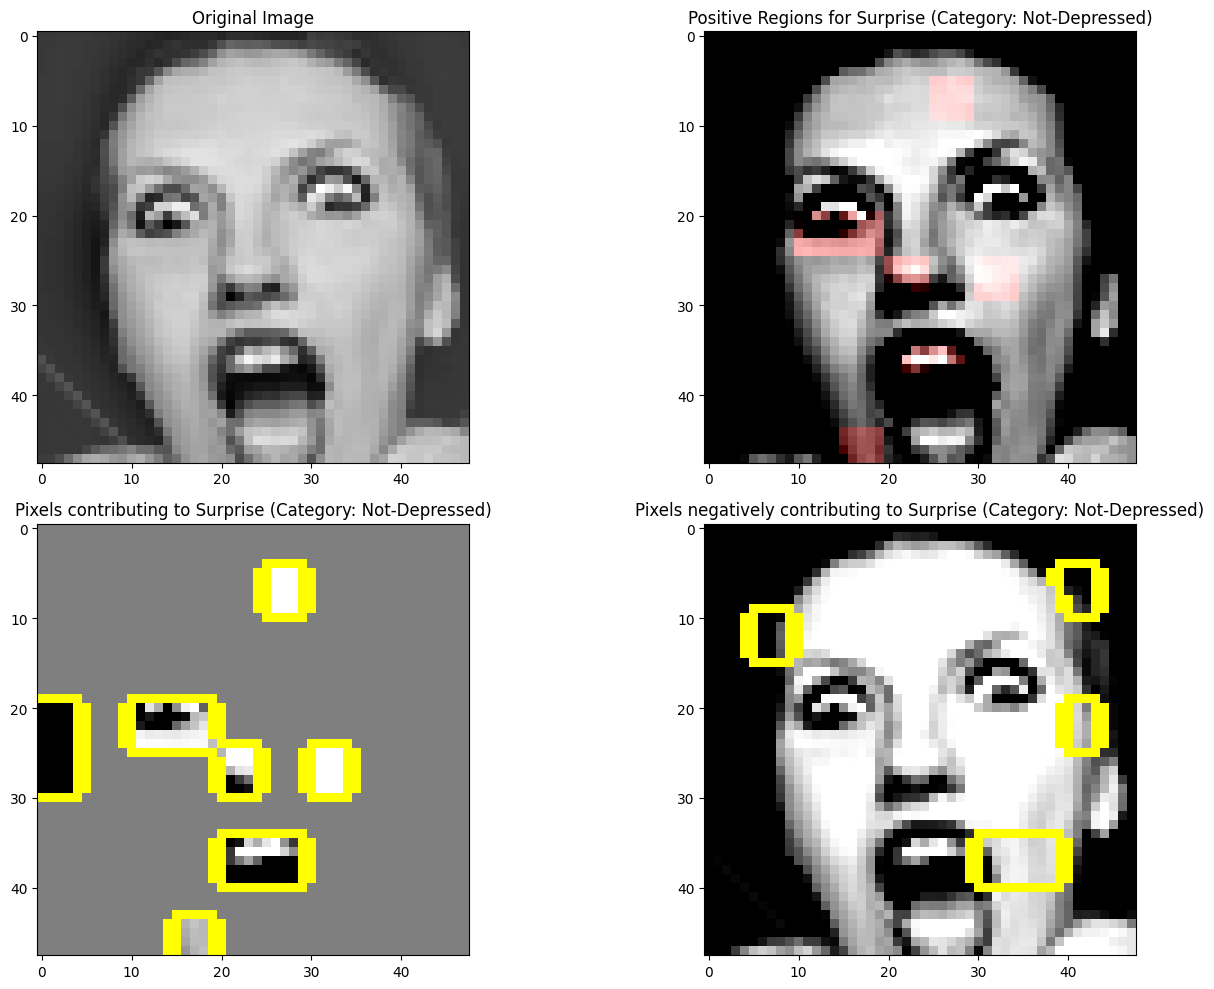

In [77]:
#Fear emotion
exp_mask(X_train[18758],y_train[18758])

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 100ms/step


 10%|█         | 10/100 [00:00<00:01, 57.65it/s]

1/1 [==============================] - 0s 96ms/step


 20%|██        | 20/100 [00:00<00:01, 60.35it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 30/100 [00:00<00:01, 66.32it/s]

1/1 [==============================] - 0s 87ms/step


 40%|████      | 40/100 [00:00<00:00, 65.24it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 50/100 [00:00<00:00, 67.04it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 60/100 [00:00<00:00, 67.02it/s]

1/1 [==============================] - 0s 109ms/step


 70%|███████   | 70/100 [00:01<00:00, 67.06it/s]

1/1 [==============================] - 0s 94ms/step


 80%|████████  | 80/100 [00:01<00:00, 66.75it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 90/100 [00:01<00:00, 65.73it/s]

1/1 [==============================] - 0s 94ms/step


100%|██████████| 100/100 [00:01<00:00, 66.03it/s]



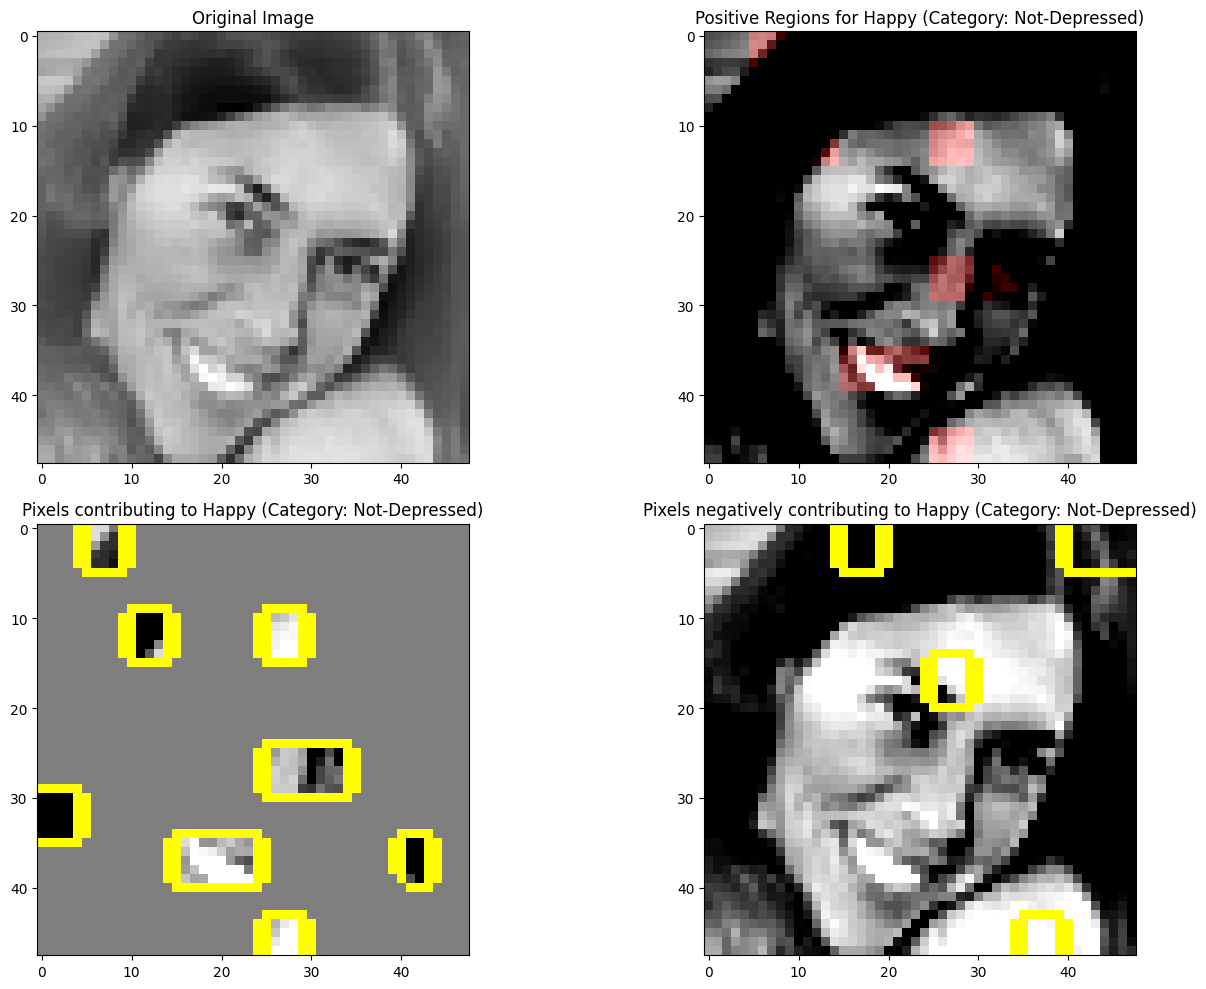

In [78]:
exp_mask(X_train[12838],y_train[12838]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 99ms/step


 10%|█         | 10/100 [00:00<00:01, 58.19it/s]

1/1 [==============================] - 0s 105ms/step


 20%|██        | 20/100 [00:00<00:01, 62.11it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 30/100 [00:00<00:01, 66.31it/s]

1/1 [==============================] - 0s 112ms/step


 40%|████      | 40/100 [00:00<00:00, 66.09it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 50/100 [00:00<00:00, 64.45it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 60/100 [00:00<00:00, 67.37it/s]

1/1 [==============================] - 0s 109ms/step


 70%|███████   | 70/100 [00:01<00:00, 64.95it/s]

1/1 [==============================] - 0s 94ms/step


 80%|████████  | 80/100 [00:01<00:00, 65.33it/s]

1/1 [==============================] - 0s 83ms/step


 90%|█████████ | 90/100 [00:01<00:00, 67.25it/s]

1/1 [==============================] - 0s 78ms/step


100%|██████████| 100/100 [00:01<00:00, 65.44it/s]



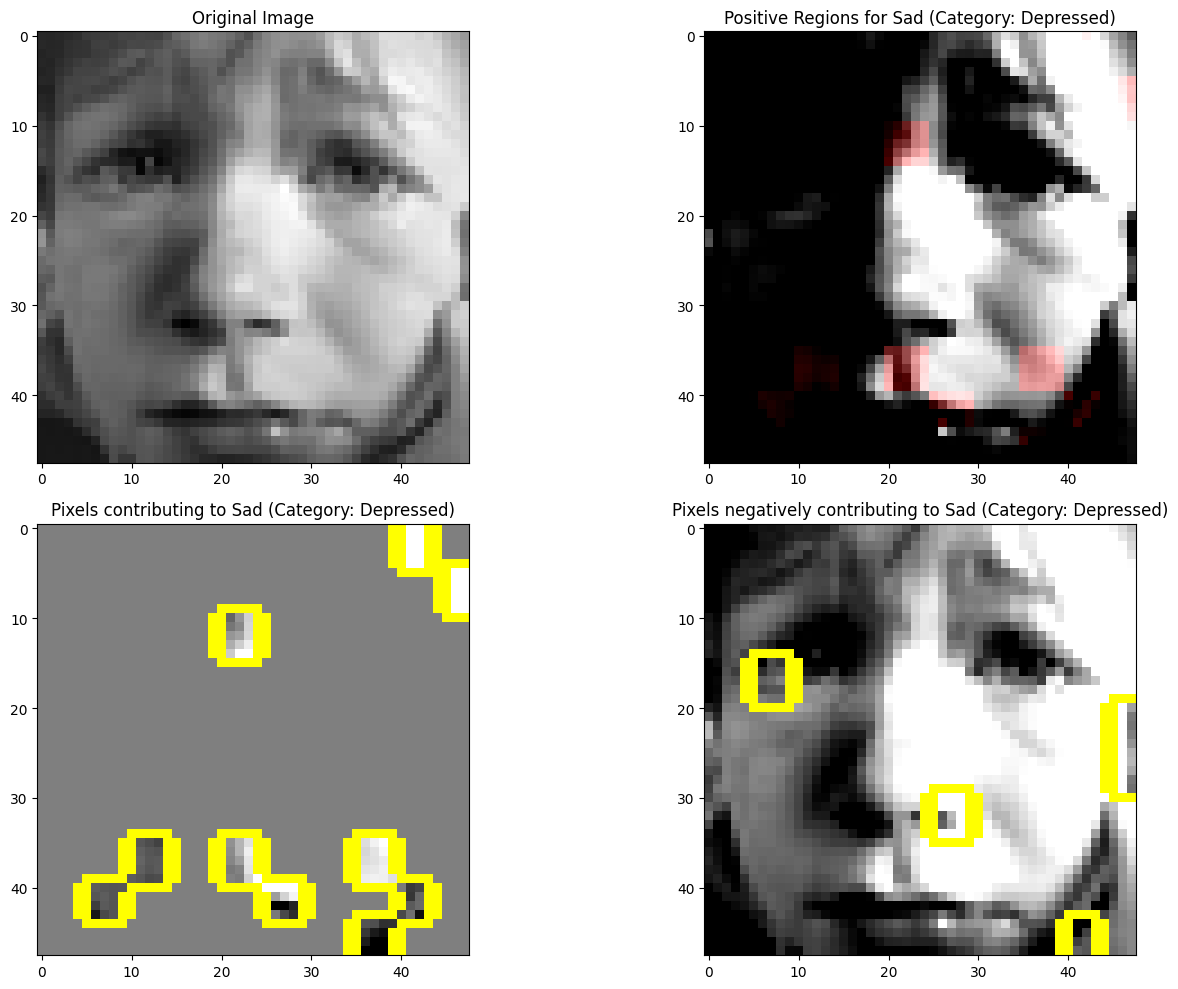

In [79]:
exp_mask(X_train[6],y_train[6]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


 10%|█         | 10/100 [00:00<00:01, 61.11it/s]

1/1 [==============================] - 0s 88ms/step


 20%|██        | 20/100 [00:00<00:01, 65.42it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 30/100 [00:00<00:01, 66.52it/s]

1/1 [==============================] - 0s 83ms/step


 40%|████      | 40/100 [00:00<00:00, 65.89it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 50/100 [00:00<00:00, 67.02it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 60/100 [00:00<00:00, 66.91it/s]

1/1 [==============================] - 0s 94ms/step


 70%|███████   | 70/100 [00:01<00:00, 66.88it/s]

1/1 [==============================] - 0s 94ms/step


 80%|████████  | 80/100 [00:01<00:00, 69.04it/s]

1/1 [==============================] - 0s 107ms/step


 90%|█████████ | 90/100 [00:01<00:00, 66.35it/s]

1/1 [==============================] - 0s 94ms/step


100%|██████████| 100/100 [00:01<00:00, 66.44it/s]



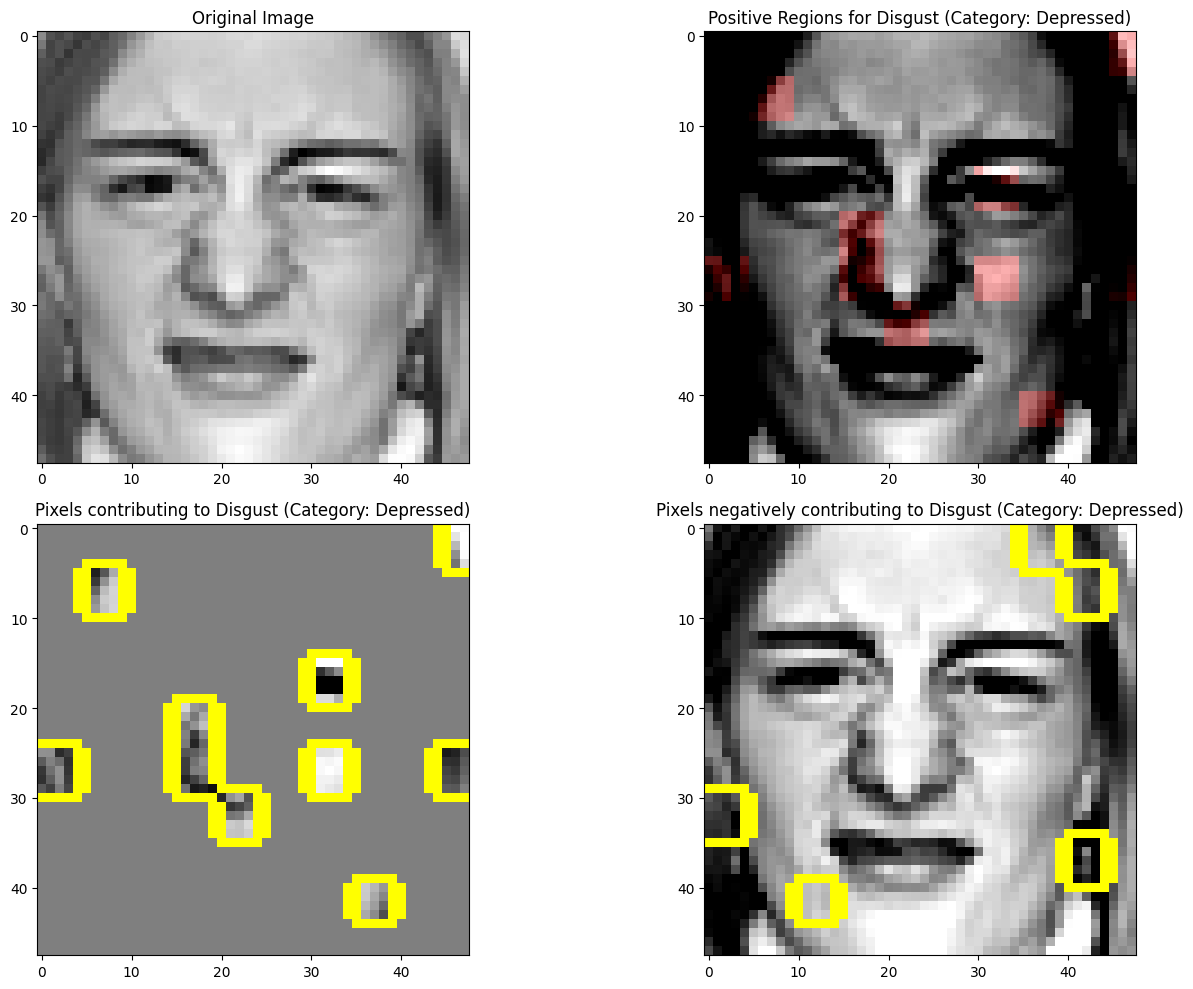

In [80]:
exp_mask(X_train[4052],y_train[4052]) 

Lime Wrong prediction

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 157ms/step


 10%|█         | 10/100 [00:00<00:02, 38.64it/s]

1/1 [==============================] - 0s 123ms/step


 20%|██        | 20/100 [00:00<00:01, 40.59it/s]

1/1 [==============================] - 0s 115ms/step


 30%|███       | 30/100 [00:00<00:01, 41.84it/s]

1/1 [==============================] - 0s 97ms/step


 40%|████      | 40/100 [00:00<00:01, 45.09it/s]

1/1 [==============================] - 0s 112ms/step


 50%|█████     | 50/100 [00:01<00:01, 46.73it/s]

1/1 [==============================] - 0s 112ms/step


 60%|██████    | 60/100 [00:01<00:00, 45.64it/s]

1/1 [==============================] - 0s 124ms/step


 70%|███████   | 70/100 [00:01<00:00, 43.98it/s]

1/1 [==============================] - 0s 120ms/step


 80%|████████  | 80/100 [00:01<00:00, 43.95it/s]

1/1 [==============================] - 0s 125ms/step


 90%|█████████ | 90/100 [00:02<00:00, 45.36it/s]

1/1 [==============================] - 0s 106ms/step


100%|██████████| 100/100 [00:02<00:00, 44.59it/s]
c:\Python311\Lib\site-packages\skimage\color\colorlabel.py:128: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


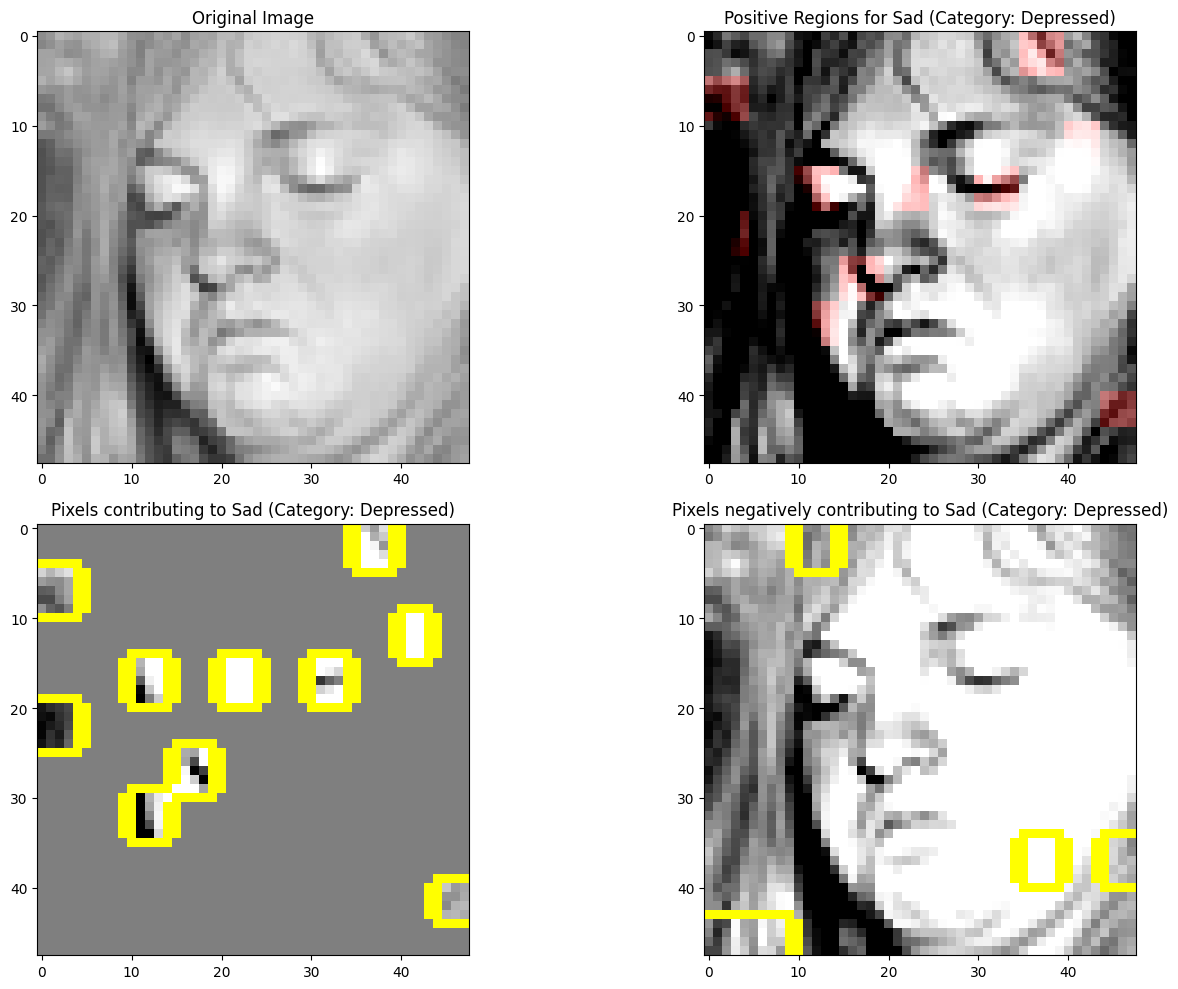

In [40]:
##True Disguest emotion
exp_mask(X_train[11314],y_train[11314]) 

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 127ms/step


 10%|█         | 10/100 [00:00<00:02, 36.79it/s]

1/1 [==============================] - 0s 147ms/step


 20%|██        | 20/100 [00:00<00:01, 41.10it/s]

1/1 [==============================] - 0s 106ms/step


 30%|███       | 30/100 [00:00<00:01, 45.34it/s]

1/1 [==============================] - 0s 167ms/step


 40%|████      | 40/100 [00:00<00:01, 40.13it/s]

1/1 [==============================] - 0s 125ms/step


 50%|█████     | 50/100 [00:01<00:01, 41.79it/s]

1/1 [==============================] - 0s 123ms/step


 60%|██████    | 60/100 [00:01<00:00, 43.32it/s]

1/1 [==============================] - 0s 105ms/step


 70%|███████   | 70/100 [00:01<00:00, 45.57it/s]

1/1 [==============================] - 0s 109ms/step


 80%|████████  | 80/100 [00:01<00:00, 46.91it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████ | 90/100 [00:02<00:00, 48.50it/s]

1/1 [==============================] - 0s 97ms/step


100%|██████████| 100/100 [00:02<00:00, 45.52it/s]
c:\Python311\Lib\site-packages\skimage\color\colorlabel.py:128: UserWarning: Negative intensities in `image` are not supported
  rgb = _label2rgb_overlay(label, image, colors, alpha, bg_label,
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


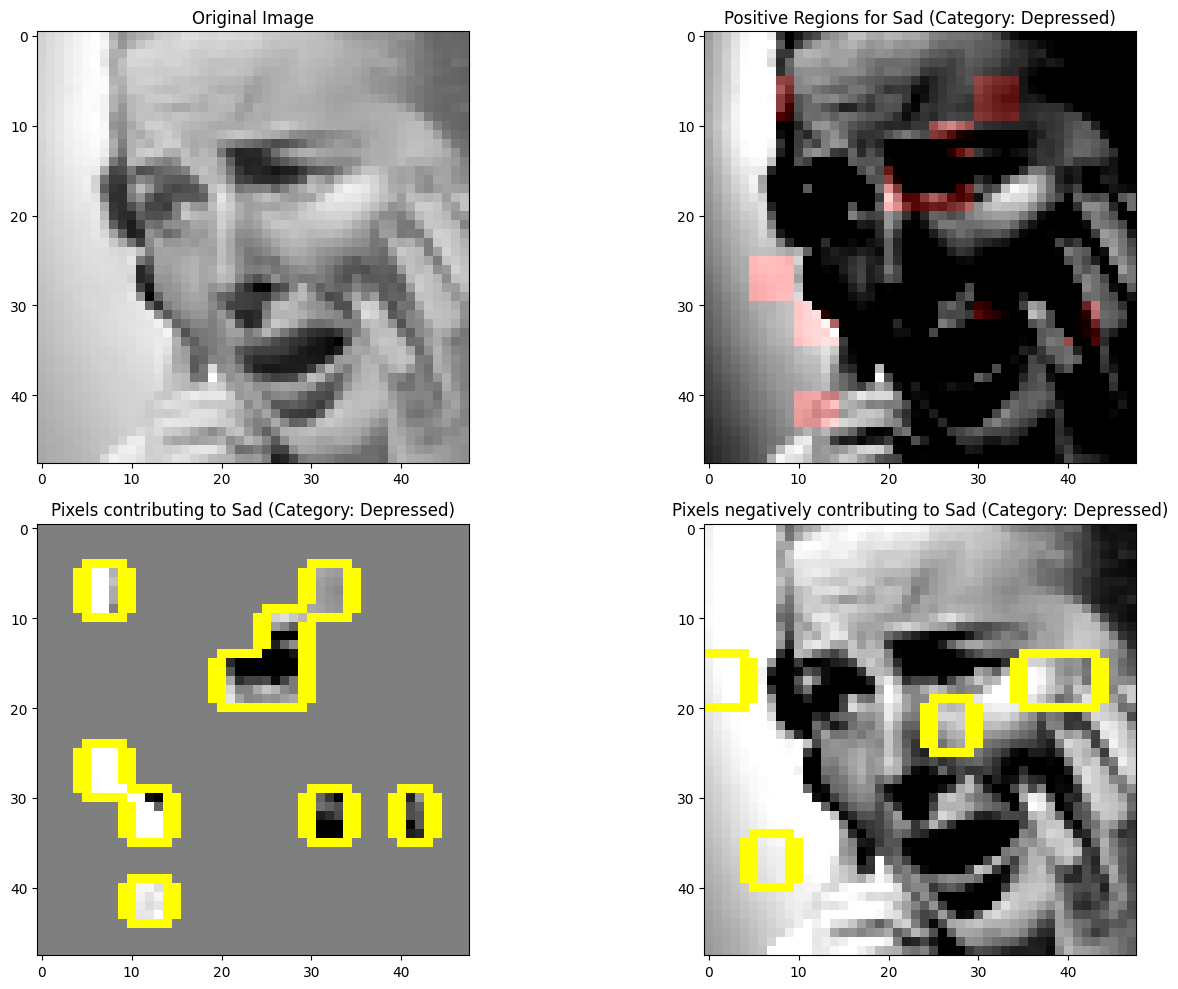

In [ ]:
#True fear emotion
exp_mask(X_train[2090],y_train[2090]) 

## Shap Explainer

In [50]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
import cv2  # for image preprocessing (optional)
import pandas as pd
from pathlib import Path

# Load the trained model
model = load_model('modified_cnn_model.h5')

# Define the emotion labels and corresponding categories
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
emotion_categories_map = {
    'Angry': 'Depressed',
    'Disgust': 'Depressed',
    'Fear': 'Depressed',
    'Happy': 'Not-Depressed',
    'Sad': 'Depressed',
    'Surprise': 'Not-Depressed',
    'Neutral': 'Not-Depressed'
}

def preprocess_image(image):
    """
    Preprocesses an image by converting to RGB if it has 4 channels.
    """
    if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)  # Convert to BGR
    return image

# Assuming you have X_train data available
X_train_preprocessed = np.array([preprocess_image(img) for img in X_train])

# Use X_train_preprocessed for explainer creation
explainer = shap.Explainer(model, masker=shap.maskers.Image("inpaint_telea", X_train_preprocessed.shape[1:]))

# Assuming the image paths are in the 'pixels' column
image_paths = data2['pixels'].values

def load_and_preprocess_image(image_index, target_size=(48, 48)):
    """
    Load and preprocess an image from the fer2013 dataset.
    """
    image_pixels = np.array([int(pixel) for pixel in image_index.split()], dtype=np.uint8)
    image = image_pixels.reshape(target_size + (1,))
    image = np.repeat(image, 3, axis=-1)  # Convert grayscale to RGB
    image = preprocess_image(image)  # Call the preprocess_image function
    return image

def explain_and_visualize(image_index):
    """
    Explains an image using SHAP and visualizes the original and masked image.

    Args:
        image_index (int): Index of the image in X_test to explain.
    """

    image_path = image_paths[image_index]
    original_image = load_and_preprocess_image(image_path)

    image_inter = X_train[image_index].reshape(1, X_train.shape[1], X_train.shape[2], X_train.shape[3])

    # Compute SHAP values
    explanation = explainer(image_inter)
    shap_values = explanation.values

    # Print the SHAP values to investigate if they are all positive or very small
    print(f"SHAP values for image {image_index}:\n{shap_values}")

    # Check if all SHAP values are positive
    all_positive = np.all(shap_values >= 0)
    print(f"Are all SHAP values positive for image {image_index}? {all_positive}")

    # Reshape SHAP values if necessary
    shap_values_array = shap_values.squeeze() if shap_values.shape[0] == 1 else shap_values

    image_array = image_inter[0]

    # Mask the image based on SHAP values
    num_pixels = image_array.size
    shap_values_array_flattened = shap_values_array.flatten()

    # Get explanations per pixel from shap_values_array
    explanations_per_pixel = shap_values_array.shape[-1]

    # Reshape masked_image_flattened back to the original shape
    masked_image_flattened = image_array.flatten()

    # Apply masking based on SHAP values
    chunk_size = num_pixels // explanations_per_pixel
    for i in range(explanations_per_pixel):
        chunk_start = i * chunk_size
        chunk_end = (i + 1) * chunk_size
        masked_image_flattened[chunk_start:chunk_end][shap_values_array_flattened[chunk_start:chunk_end] <= 0] = 0

    masked_image = masked_image_flattened.reshape(image_array.shape)

    # Make prediction on the image
    predicted_label = model.predict(image_inter)
    predicted_emotion = emotion_labels[np.argmax(predicted_label)]

    # Map the predicted emotion to the emotion category
    predicted_category = emotion_categories_map[predicted_emotion]

    # Plot the SHAP values for the image
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # Original image
    ax[0].imshow(original_image)
    ax[0].set_title('Original Image', fontsize=16)
    ax[0].axis('on')

    # Masked image
    ax[1].imshow(masked_image)
    ax[1].set_title(f'Masked Image', fontsize=16)
    ax[1].axis('off')

    # Plot the SHAP values as a heatmap
    shap_heatmap = None
    if shap_values_array.shape[-1] == 1:  # Single output channel
        shap_heatmap = ax[2].imshow(shap_values_array.squeeze(-1), cmap='coolwarm')
    else:  # Multiple output channels
        shap_values_combined = np.sum(shap_values_array, axis=-1)
        shap_heatmap = ax[2].imshow(shap_values_combined, cmap='coolwarm')

    if shap_heatmap is not None:
        ax[2].set_title(f'SHAP Value Heatmap', fontsize=16)
        fig.colorbar(shap_heatmap, ax=ax[2])

    # Add a title with the predicted emotion and category
    plt.suptitle(f'Predicted Emotion: {predicted_emotion} (Category: {predicted_category})', fontsize=16)

    plt.tight_layout()
    plt.show()

# Explain and visualize a specific image

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


PartitionExplainer explainer: 2it [00:11, 11.45s/it]               


SHAP values for image 11879:
[[[[[-2.80466001e-06 -1.68241422e-04  3.13247216e-04 ...
      3.70278115e-04 -8.84731957e-05 -4.35195329e-04]]

   [[-2.80466001e-06 -1.68241422e-04  3.13247216e-04 ...
      3.70278115e-04 -8.84731957e-05 -4.35195329e-04]]

   [[-2.80466001e-06 -1.68241422e-04  3.13247216e-04 ...
      3.70278115e-04 -8.84731957e-05 -4.35195329e-04]]

   ...

   [[ 1.11450065e-06 -5.71379384e-07  1.00832416e-04 ...
      1.72124842e-04 -5.34167118e-05 -2.79552910e-04]]

   [[ 1.11450065e-06 -5.71379384e-07  1.00832416e-04 ...
      1.72124842e-04 -5.34167118e-05 -2.79552910e-04]]

   [[ 1.11450065e-06 -5.71379384e-07  1.00832416e-04 ...
      1.72124842e-04 -5.34167118e-05 -2.79552910e-04]]]


  [[[-2.80466001e-06 -1.68241422e-04  3.13247216e-04 ...
      3.70278115e-04 -8.84731957e-05 -4.35195329e-04]]

   [[-2.80466001e-06 -1.68241422e-04  3.13247216e-04 ...
      3.70278115e-04 -8.84731957e-05 -4.35195329e-04]]

   [[-2.80466001e-06 -1.68241422e-04  3.13247216e-04 ...


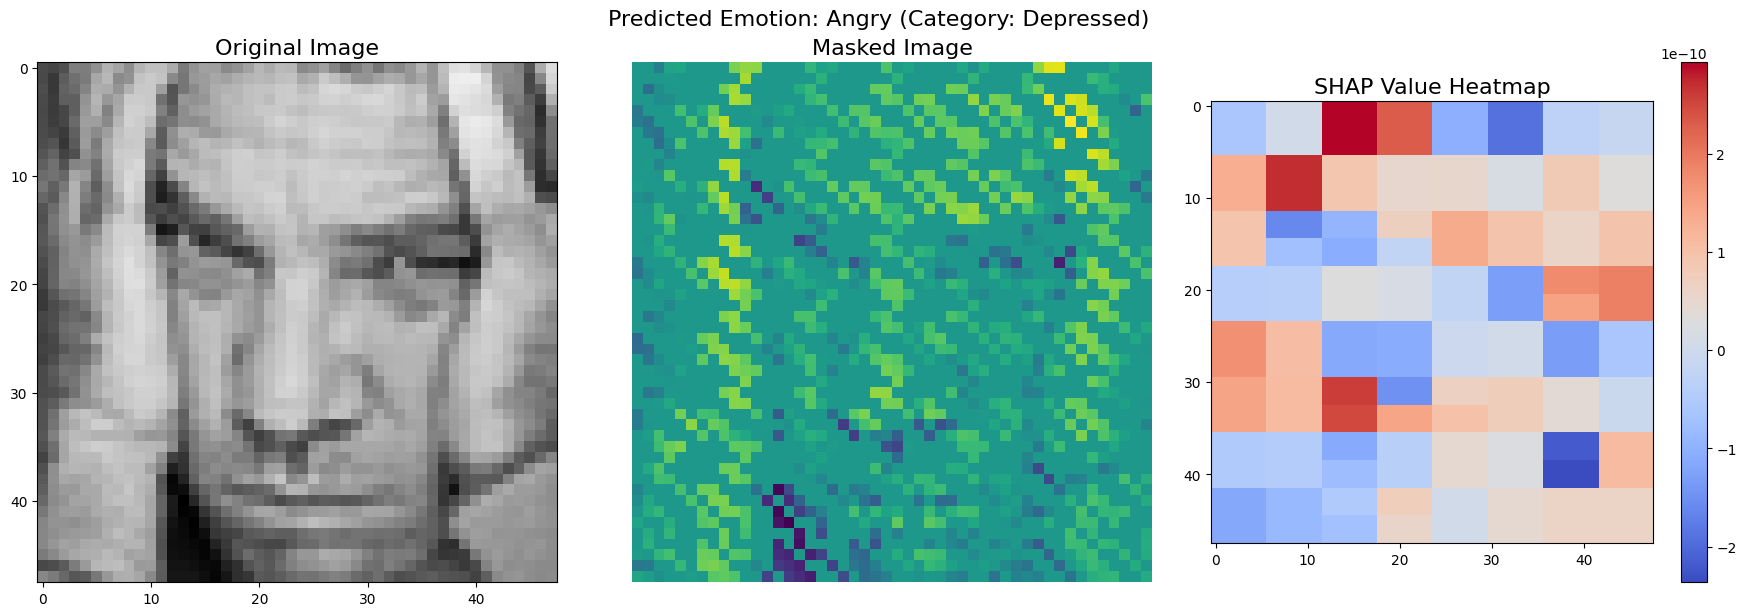

In [51]:
explain_and_visualize(11879)

SHAP values for image 18758:
[[[[[-1.52023809e-04 -1.90097645e-04  3.48060837e-04 ...
      3.34242830e-04 -1.36873282e-05 -3.22577130e-04]]

   [[-1.52023809e-04 -1.90097645e-04  3.48060837e-04 ...
      3.34242830e-04 -1.36873282e-05 -3.22577130e-04]]

   [[-1.52023809e-04 -1.90097645e-04  3.48060837e-04 ...
      3.34242830e-04 -1.36873282e-05 -3.22577130e-04]]

   ...

   [[ 2.09908696e-06  8.24743438e-05  3.90451202e-04 ...
     -2.29835867e-04 -1.36872340e-05 -2.27398110e-04]]

   [[ 2.09908696e-06  8.24743438e-05  3.90451202e-04 ...
     -2.29835867e-04 -1.36872340e-05 -2.27398110e-04]]

   [[ 2.09908696e-06  8.24743438e-05  3.90451202e-04 ...
     -2.29835867e-04 -1.36872340e-05 -2.27398110e-04]]]


  [[[-1.52023809e-04 -1.90097645e-04  3.48060837e-04 ...
      3.34242830e-04 -1.36873282e-05 -3.22577130e-04]]

   [[-1.52023809e-04 -1.90097645e-04  3.48060837e-04 ...
      3.34242830e-04 -1.36873282e-05 -3.22577130e-04]]

   [[-1.52023809e-04 -1.90097645e-04  3.48060837e-04 ...


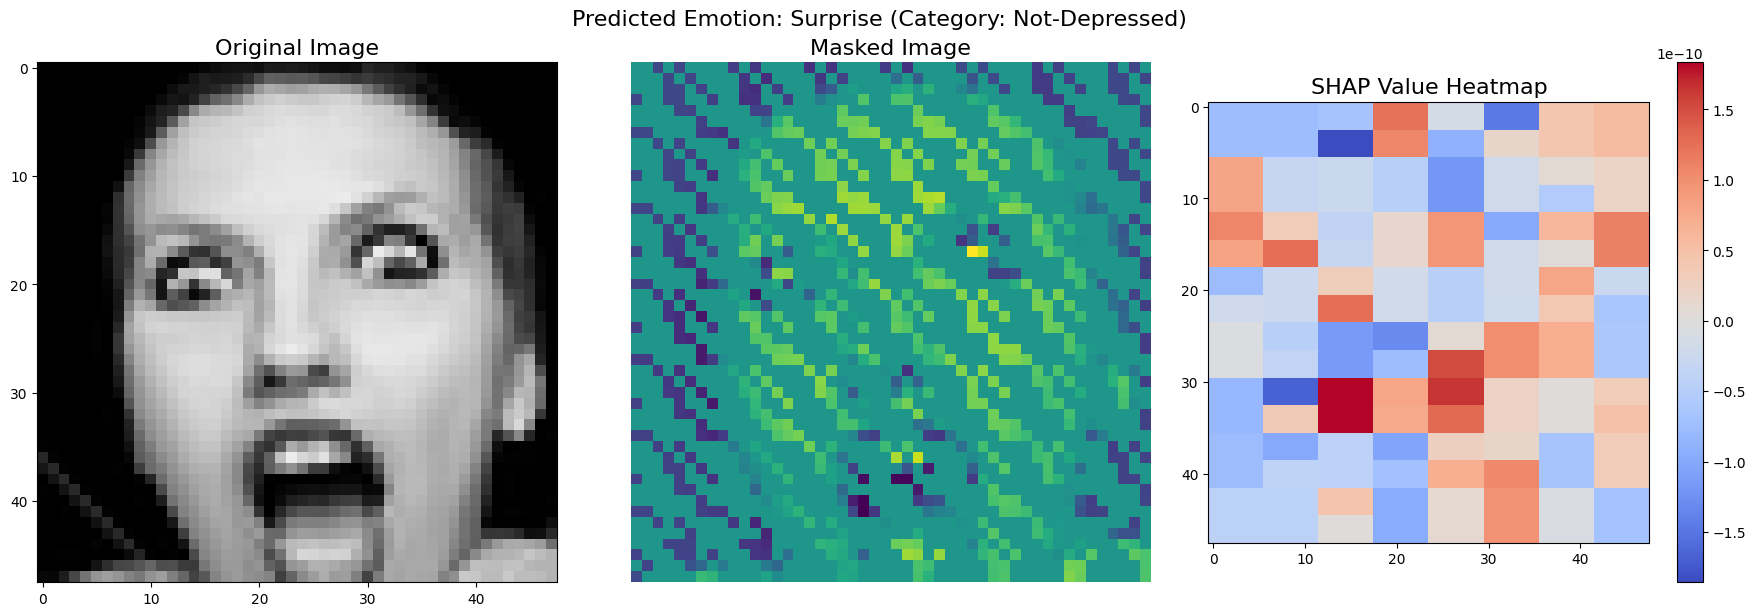

In [82]:
explain_and_visualize(18758)

SHAP values for image 18308:
[[[[[-3.62439047e-04 -7.00472872e-06  3.27037082e-04 ...
     -6.04821151e-05 -3.64955604e-06  1.34456723e-04]]

   [[-3.62439047e-04 -7.00472872e-06  3.27037082e-04 ...
     -6.04821151e-05 -3.64955604e-06  1.34456723e-04]]

   [[-3.62439047e-04 -7.00472872e-06  3.27037082e-04 ...
     -6.04821151e-05 -3.64955604e-06  1.34456723e-04]]

   ...

   [[ 3.53069628e-06 -6.61741114e-08 -4.11941976e-06 ...
      6.40934037e-06  2.19605990e-05 -1.61600765e-05]]

   [[ 3.53069628e-06 -6.61741114e-08 -4.11941976e-06 ...
      6.40934037e-06  2.19605990e-05 -1.61600765e-05]]

   [[ 3.53069628e-06 -6.61741114e-08 -4.11941976e-06 ...
      6.40934037e-06  2.19605990e-05 -1.61600765e-05]]]


  [[[-3.62439047e-04 -7.00472872e-06  3.27037082e-04 ...
     -6.04821151e-05 -3.64955604e-06  1.34456723e-04]]

   [[-3.62439047e-04 -7.00472872e-06  3.27037082e-04 ...
     -6.04821151e-05 -3.64955604e-06  1.34456723e-04]]

   [[-3.62439047e-04 -7.00472872e-06  3.27037082e-04 ...


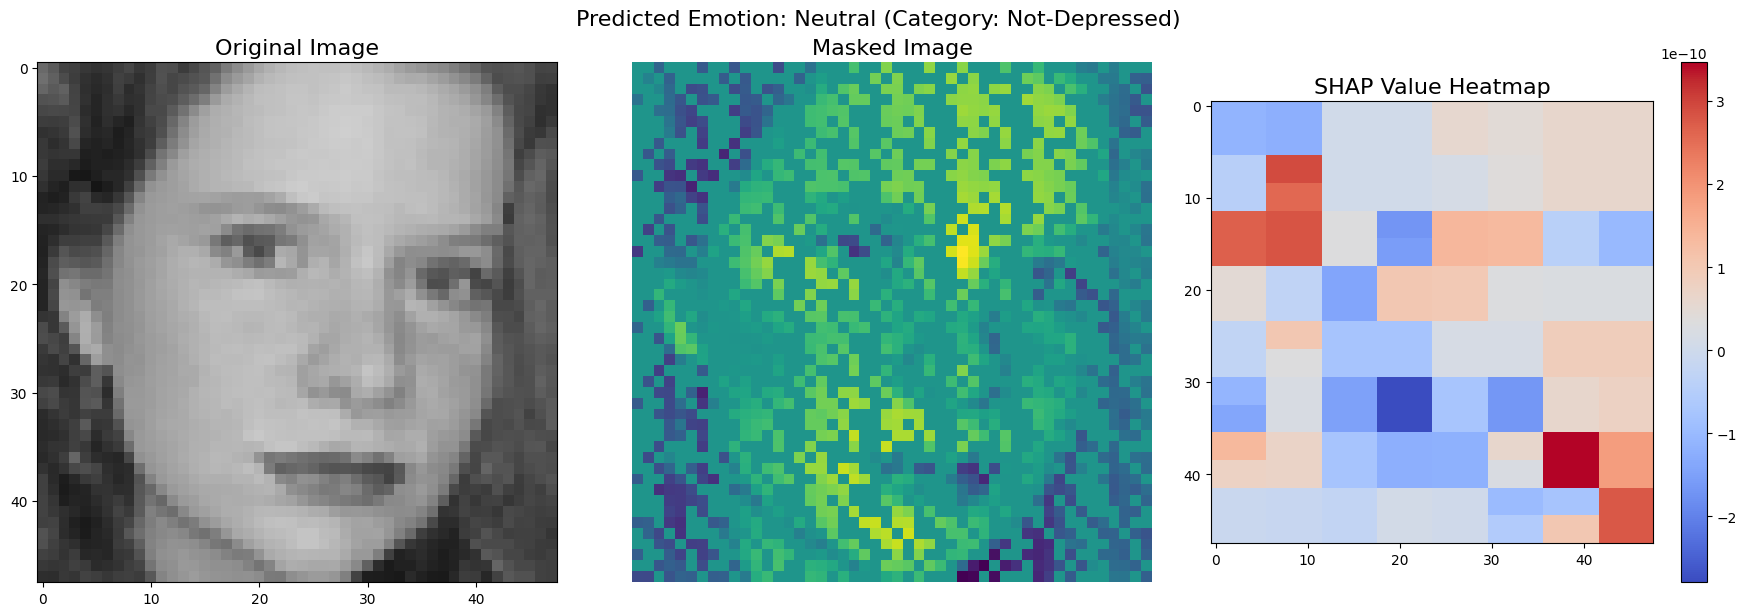

In [83]:
#Happy emotion
explain_and_visualize(18308)

SHAP values for image 12838:
[[[[[-7.32595286e-05 -1.85792331e-04 -2.39968300e-06 ...
      2.49625956e-04  1.10665549e-05  3.07214156e-06]]

   [[-7.32595286e-05 -1.85792331e-04 -2.39968300e-06 ...
      2.49625956e-04  1.10665549e-05  3.07214156e-06]]

   [[-7.32595286e-05 -1.85792331e-04 -2.39968300e-06 ...
      2.49625956e-04  1.10665549e-05  3.07214156e-06]]

   ...

   [[ 4.91320122e-04  1.26448399e-05 -4.49784547e-05 ...
     -1.34812803e-04 -1.18328714e-05 -3.06072826e-04]]

   [[ 4.91320122e-04  1.26448399e-05 -4.49784547e-05 ...
     -1.34812803e-04 -1.18328714e-05 -3.06072826e-04]]

   [[ 4.91320122e-04  1.26448399e-05 -4.49784547e-05 ...
     -1.34812803e-04 -1.18328714e-05 -3.06072826e-04]]]


  [[[-7.32595286e-05 -1.85792331e-04 -2.39968300e-06 ...
      2.49625956e-04  1.10665549e-05  3.07214156e-06]]

   [[-7.32595286e-05 -1.85792331e-04 -2.39968300e-06 ...
      2.49625956e-04  1.10665549e-05  3.07214156e-06]]

   [[-7.32595286e-05 -1.85792331e-04 -2.39968300e-06 ...


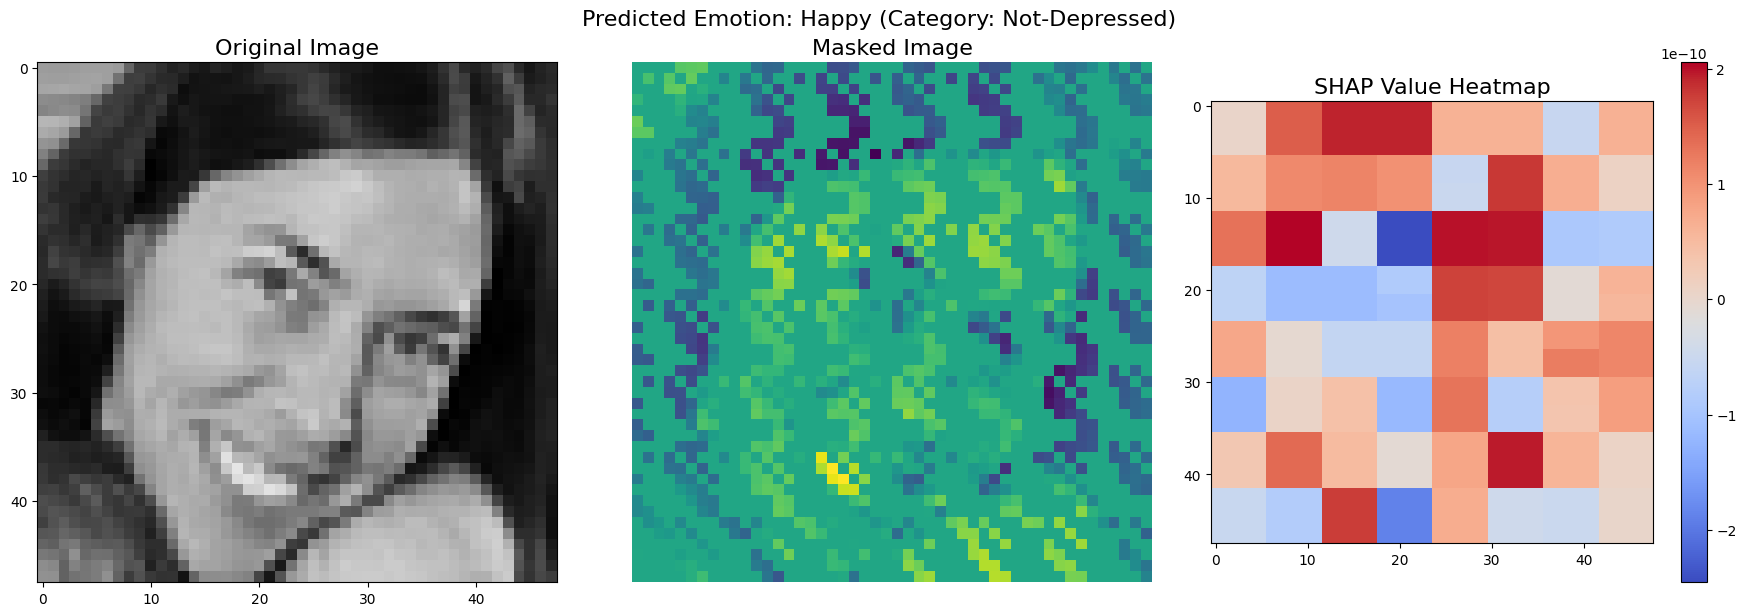

In [52]:
#Fear emotion
explain_and_visualize(12838)

SHAP values for image 1790:
[[[[[ 9.41422535e-06  5.72487757e-08  3.22188203e-04 ...
      4.27932596e-04 -9.23415817e-05 -7.01576203e-04]]

   [[ 9.41422535e-06  5.72487757e-08  3.22188203e-04 ...
      4.27932596e-04 -9.23415817e-05 -7.01576203e-04]]

   [[ 9.41422535e-06  5.72487757e-08  3.22188203e-04 ...
      4.27932596e-04 -9.23415817e-05 -7.01576203e-04]]

   ...

   [[ 2.95132836e-07  8.67736405e-09  2.73591281e-04 ...
      7.60933043e-05 -6.74954723e-05 -3.04201145e-04]]

   [[ 2.95132836e-07  8.67736405e-09  2.73591281e-04 ...
      7.60933043e-05 -6.74954723e-05 -3.04201145e-04]]

   [[ 2.95132836e-07  8.67736405e-09  2.73591281e-04 ...
      7.60933043e-05 -6.74954723e-05 -3.04201145e-04]]]


  [[[ 9.41422535e-06  5.72487757e-08  3.22188203e-04 ...
      4.27932596e-04 -9.23415817e-05 -7.01576203e-04]]

   [[ 9.41422535e-06  5.72487757e-08  3.22188203e-04 ...
      4.27932596e-04 -9.23415817e-05 -7.01576203e-04]]

   [[ 9.41422535e-06  5.72487757e-08  3.22188203e-04 ...
 

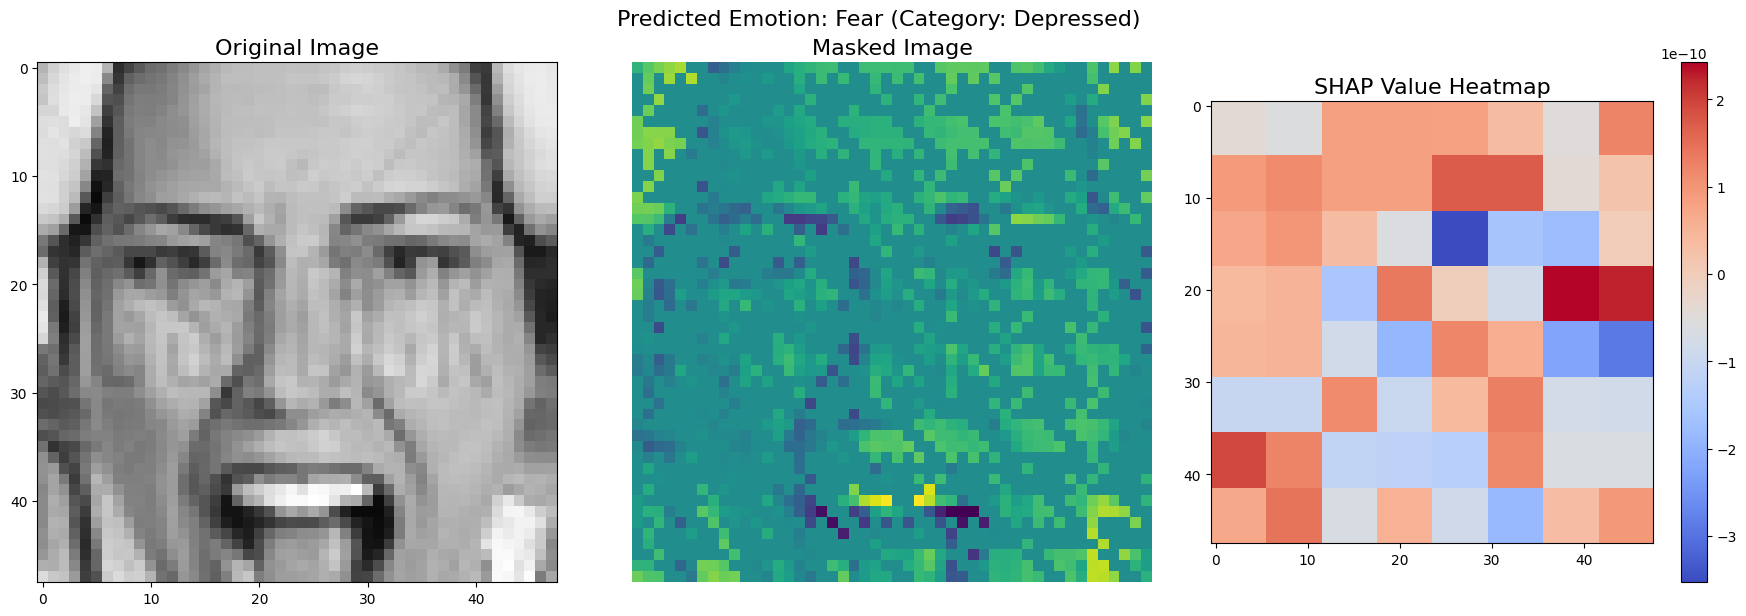

In [85]:
#Angry emotion
explain_and_visualize(1790)

SHAP values for image 60:
[[[[[-5.23035816e-05 -5.62030731e-05  9.82061290e-05 ...
     -1.18801228e-05  1.24130478e-05  2.37858125e-06]]

   [[-5.23035816e-05 -5.62030731e-05  9.82061290e-05 ...
     -1.18801228e-05  1.24130478e-05  2.37858125e-06]]

   [[-5.23035816e-05 -5.62030731e-05  9.82061290e-05 ...
     -1.18801228e-05  1.24130478e-05  2.37858125e-06]]

   ...

   [[ 2.00929574e-04 -5.86561685e-05  2.64552561e-04 ...
     -6.31091638e-05 -1.47840082e-05 -2.78523363e-04]]

   [[ 2.00929574e-04 -5.86561685e-05  2.64552561e-04 ...
     -6.31091638e-05 -1.47840082e-05 -2.78523363e-04]]

   [[ 2.00929574e-04 -5.86561685e-05  2.64552561e-04 ...
     -6.31091638e-05 -1.47840082e-05 -2.78523363e-04]]]


  [[[-5.23035816e-05 -5.62030731e-05  9.82061290e-05 ...
     -1.18801228e-05  1.24130478e-05  2.37858125e-06]]

   [[-5.23035816e-05 -5.62030731e-05  9.82061290e-05 ...
     -1.18801228e-05  1.24130478e-05  2.37858125e-06]]

   [[-5.23035816e-05 -5.62030731e-05  9.82061290e-05 ...
   

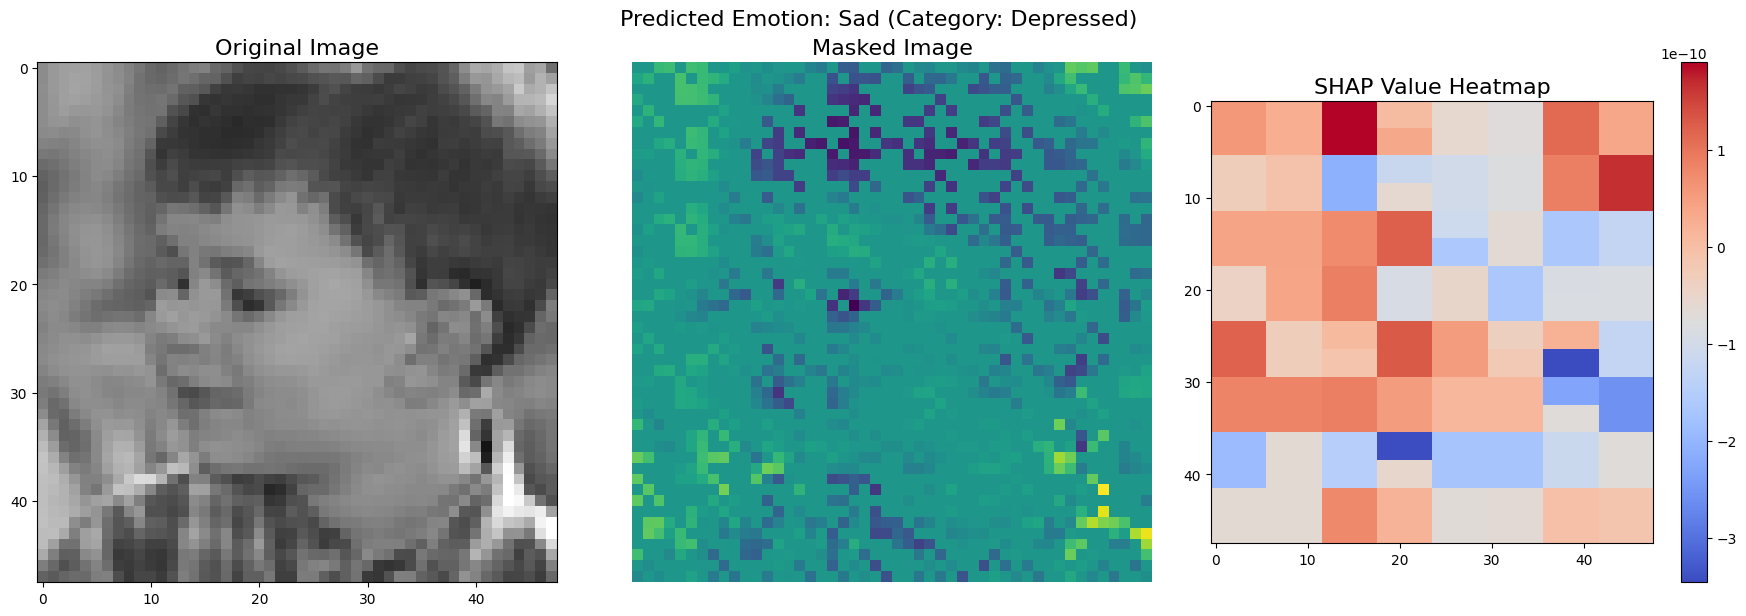

In [86]:
#Sad emotion
explain_and_visualize(60)

SHAP values for image 1977:
[[[[[-8.70539653e-05 -2.04893179e-05  3.17599478e-04 ...
      1.08450982e-04 -3.38889972e-05 -2.82739519e-04]]

   [[-8.70539653e-05 -2.04893179e-05  3.17599478e-04 ...
      1.08450982e-04 -3.38889972e-05 -2.82739519e-04]]

   [[-8.70539653e-05 -2.04893179e-05  3.17599478e-04 ...
      1.08450982e-04 -3.38889972e-05 -2.82739519e-04]]

   ...

   [[ 1.02705922e-04  3.10781628e-04 -2.67614721e-05 ...
     -3.64342843e-05 -3.40364480e-05 -3.11276147e-04]]

   [[ 1.02705922e-04  3.10781628e-04 -2.67614721e-05 ...
     -3.64342843e-05 -3.40364480e-05 -3.11276147e-04]]

   [[ 1.02705922e-04  3.10781628e-04 -2.67614721e-05 ...
     -3.64342843e-05 -3.40364480e-05 -3.11276147e-04]]]


  [[[-8.70539653e-05 -2.04893179e-05  3.17599478e-04 ...
      1.08450982e-04 -3.38889972e-05 -2.82739519e-04]]

   [[-8.70539653e-05 -2.04893179e-05  3.17599478e-04 ...
      1.08450982e-04 -3.38889972e-05 -2.82739519e-04]]

   [[-8.70539653e-05 -2.04893179e-05  3.17599478e-04 ...
 

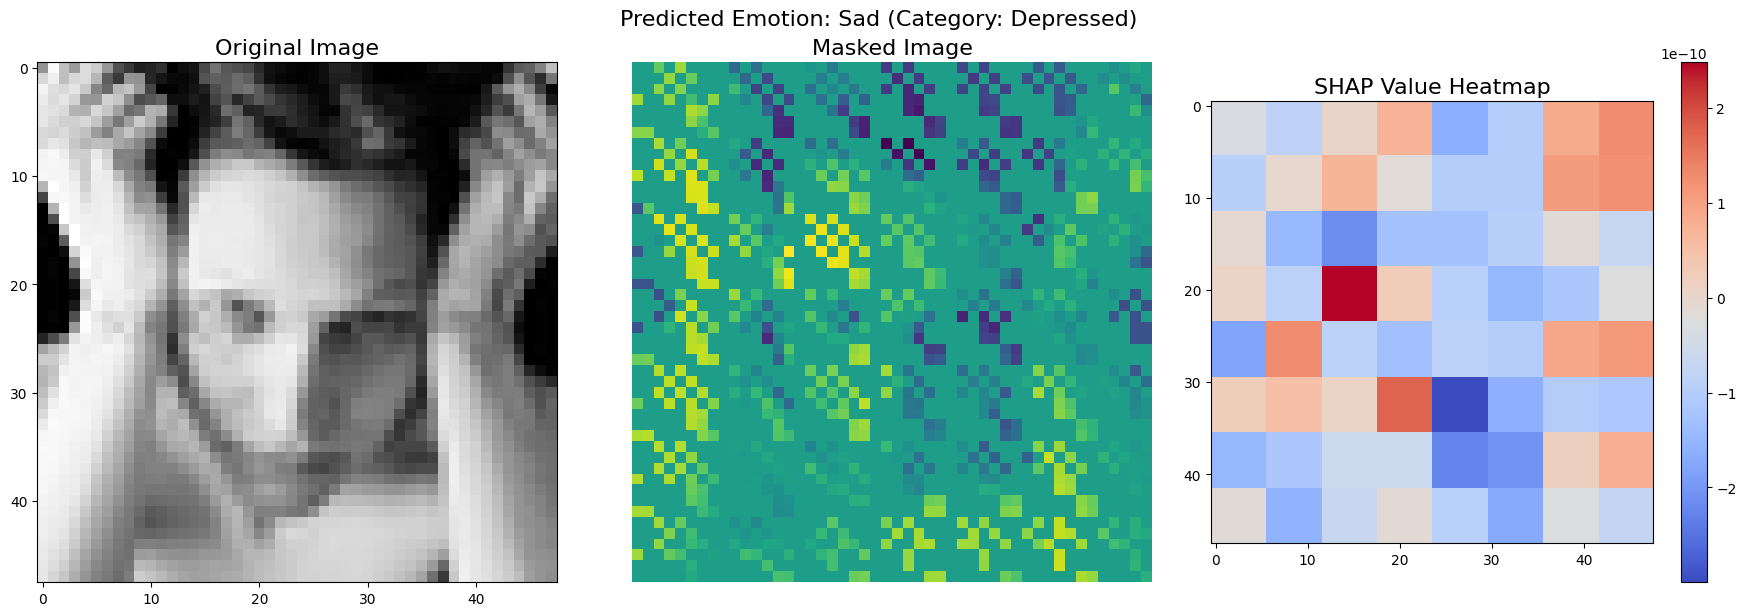

In [87]:
#Surprise emotion
explain_and_visualize(1977)

SHAP values for image 4052:
[[[[[ 1.40548126e-03  6.73112341e-04 -9.55370758e-05 ...
     -1.27590839e-03 -6.10686580e-05 -6.34245315e-04]]

   [[ 1.40548126e-03  6.73112341e-04 -9.55370758e-05 ...
     -1.27590839e-03 -6.10686580e-05 -6.34245315e-04]]

   [[ 1.40548126e-03  6.73112341e-04 -9.55370758e-05 ...
     -1.27590839e-03 -6.10686580e-05 -6.34245315e-04]]

   ...

   [[ 1.24340792e-06  2.15787937e-06 -4.23973135e-05 ...
      3.33803945e-05 -8.16675629e-06  1.06182525e-05]]

   [[ 1.24340792e-06  2.15787937e-06 -4.23973135e-05 ...
      3.33803945e-05 -8.16675629e-06  1.06182525e-05]]

   [[ 1.24340792e-06  2.15787937e-06 -4.23973135e-05 ...
      3.33803945e-05 -8.16675629e-06  1.06182525e-05]]]


  [[[ 1.40548126e-03  6.73112341e-04 -9.55370758e-05 ...
     -1.27590839e-03 -6.10686580e-05 -6.34245315e-04]]

   [[ 1.40548126e-03  6.73112341e-04 -9.55370758e-05 ...
     -1.27590839e-03 -6.10686580e-05 -6.34245315e-04]]

   [[ 1.40548126e-03  6.73112341e-04 -9.55370758e-05 ...
 

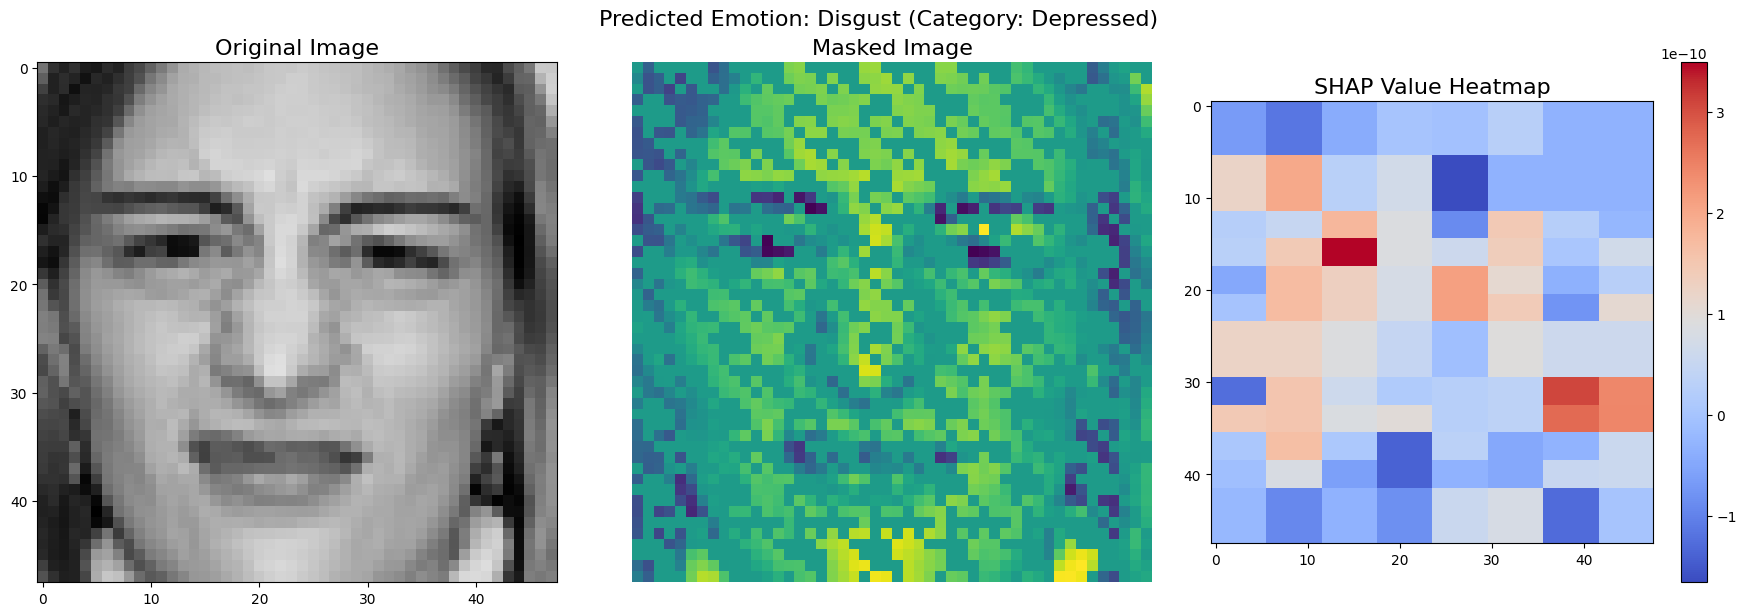

In [88]:
#Disgust emotion
explain_and_visualize(4052)

Shap Wrong prediction

PartitionExplainer explainer: 2it [00:10, 10.62s/it]               


SHAP values for image 11314:
[[[[[-7.48968996e-07  5.23558938e-08 -1.77757073e-04 ...
      1.71146627e-04 -9.19281115e-05  9.33391663e-05]]

   [[-7.48968996e-07  5.23558938e-08 -1.77757073e-04 ...
      1.71146627e-04 -9.19281115e-05  9.33391663e-05]]

   [[-7.48968996e-07  5.23558938e-08 -1.77757073e-04 ...
      1.71146627e-04 -9.19281115e-05  9.33391663e-05]]

   ...

   [[ 3.40448799e-06 -8.70132090e-08  3.12900312e-04 ...
     -2.05258391e-04 -9.09219770e-05  3.56258198e-06]]

   [[ 3.40448799e-06 -8.70132090e-08  3.12900312e-04 ...
     -2.05258391e-04 -9.09219770e-05  3.56258198e-06]]

   [[ 3.40448799e-06 -8.70132090e-08  3.12900312e-04 ...
     -2.05258391e-04 -9.09219770e-05  3.56258198e-06]]]


  [[[-7.48968996e-07  5.23558938e-08 -1.77757073e-04 ...
      1.71146627e-04 -9.19281115e-05  9.33391663e-05]]

   [[-7.48968996e-07  5.23558938e-08 -1.77757073e-04 ...
      1.71146627e-04 -9.19281115e-05  9.33391663e-05]]

   [[-7.48968996e-07  5.23558938e-08 -1.77757073e-04 ...


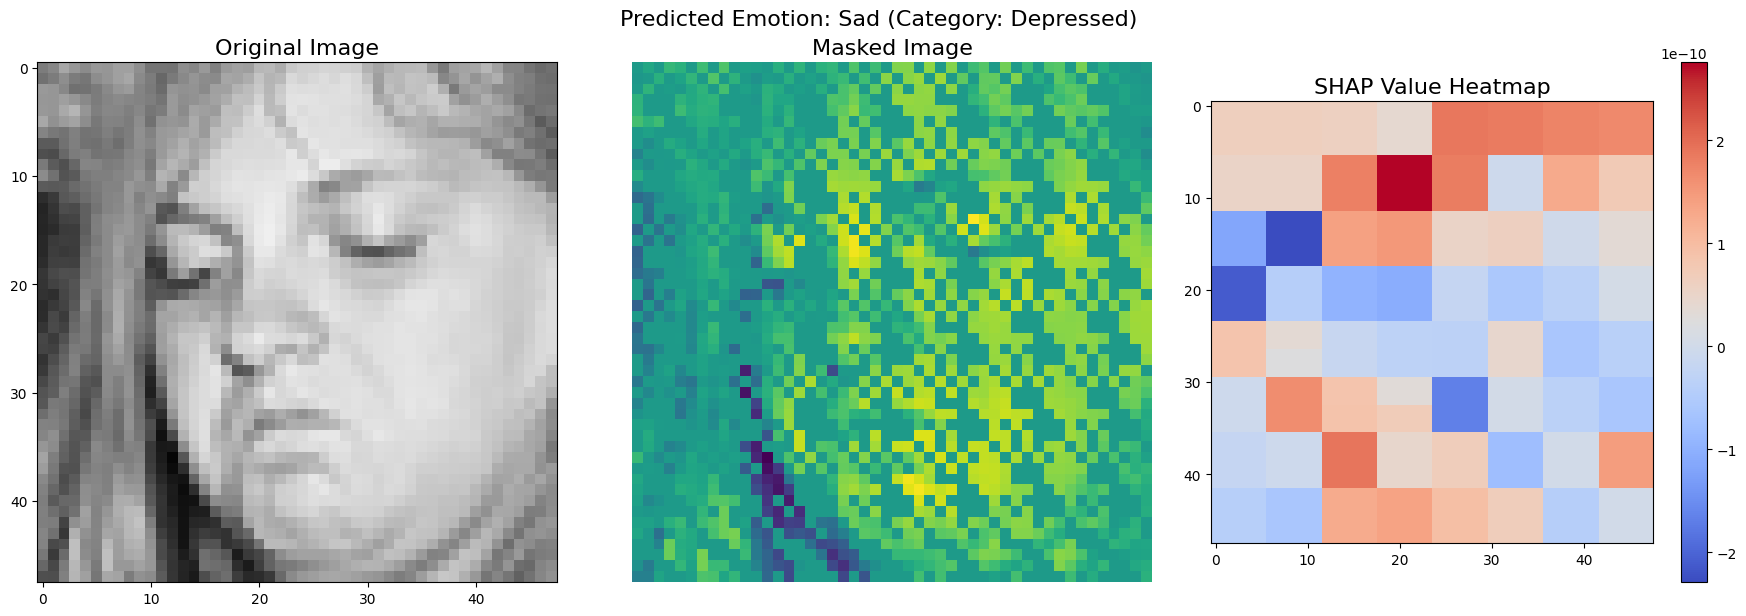

In [60]:
#True disgust
explain_and_visualize(11314)

SHAP values for image 2090:
[[[[[-2.40366742e-07  6.20050501e-08  3.59303399e-04 ...
      3.26045944e-04 -5.51688828e-05 -5.98620603e-04]]

   [[-2.40366742e-07  6.20050501e-08  3.59303399e-04 ...
      3.26045944e-04 -5.51688828e-05 -5.98620603e-04]]

   [[-2.40366742e-07  6.20050501e-08  3.59303399e-04 ...
      3.26045944e-04 -5.51688828e-05 -5.98620603e-04]]

   ...

   [[ 2.77316797e-04 -1.32384018e-08 -4.90210046e-06 ...
     -2.87547027e-04 -1.09471134e-05  7.31048744e-05]]

   [[ 2.77316797e-04 -1.32384018e-08 -4.90210046e-06 ...
     -2.87547027e-04 -1.09471134e-05  7.31048744e-05]]

   [[ 2.77316797e-04 -1.32384018e-08 -4.90210046e-06 ...
     -2.87547027e-04 -1.09471134e-05  7.31048744e-05]]]


  [[[-2.40366742e-07  6.20050501e-08  3.59303399e-04 ...
      3.26045944e-04 -5.51688828e-05 -5.98620603e-04]]

   [[-2.40366742e-07  6.20050501e-08  3.59303399e-04 ...
      3.26045944e-04 -5.51688828e-05 -5.98620603e-04]]

   [[-2.40366742e-07  6.20050501e-08  3.59303399e-04 ...
 

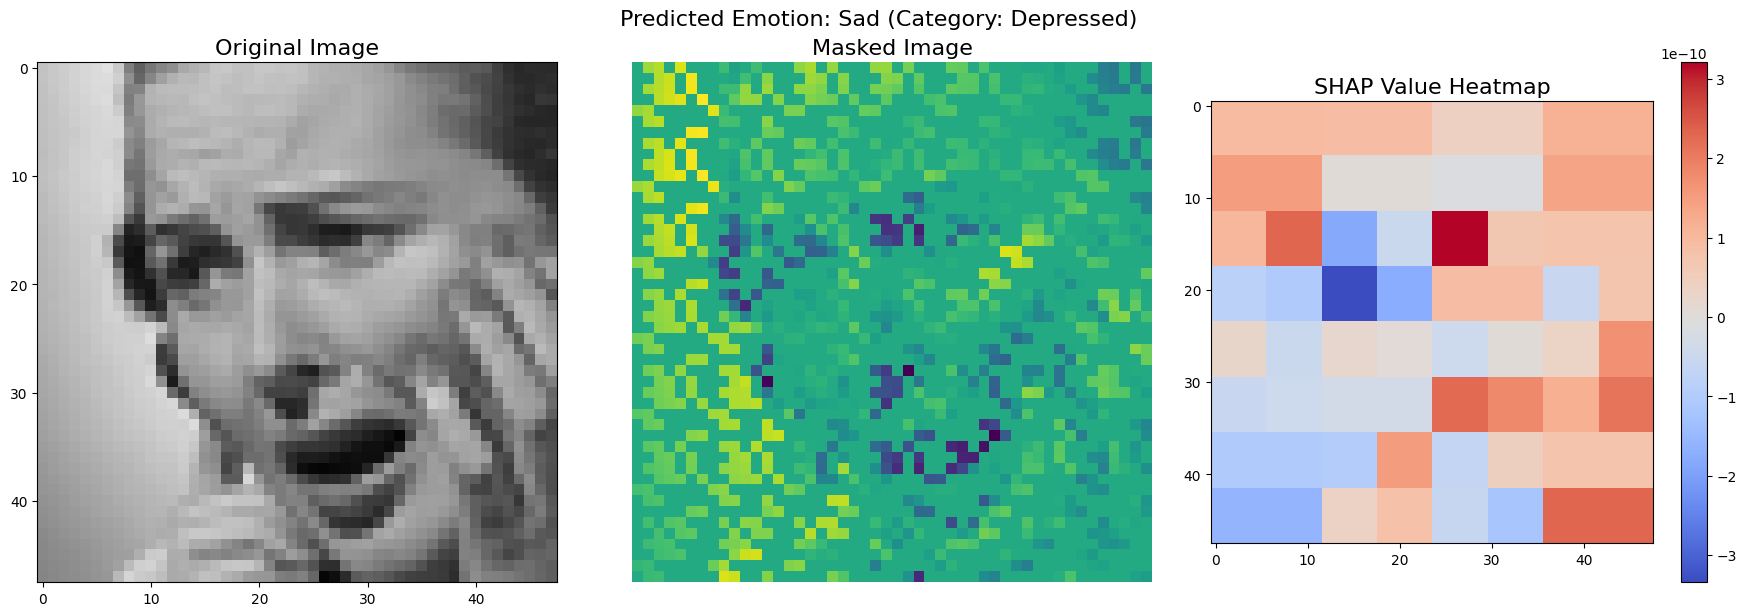

In [61]:
#True Fear
explain_and_visualize(2090)